## Import Required Libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os, datetime
from matplotlib import pyplot as plt
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np

## Import Dataset and Create DataLoader

In [2]:
train_df = pd.read_csv("../split_datasets/train.csv")
train_df = train_df.drop(columns="id")
train_df = train_df.drop(columns="last_scraped")
train_df = train_df.drop(columns="amenities")

val_df = pd.read_csv("../split_datasets/val.csv")
val_df = val_df.drop(columns="id")
val_df = val_df.drop(columns="last_scraped")
val_df = val_df.drop(columns="amenities")

test_df = pd.read_csv("../split_datasets/test.csv")
test_df = test_df.drop(columns="id")
test_df = test_df.drop(columns="last_scraped")
test_df = test_df.drop(columns="amenities")

In [3]:
class airbnb_dataset (Dataset):
    def __init__(self, df, purpose):
        self.price = torch.from_numpy(df["price"].to_numpy())
        self.data = torch.from_numpy(df.drop(columns="price").to_numpy())
        self.purpose = purpose
        
    def __len__(self):
        return len(self.price)
    
    def __getitem__(self, index):
        # Returns specific sample as a dict
        if torch.is_tensor(index):
            index = index.tolist()
        sample = self.data[index]
        label = self.price[index]
        return {"sample": sample, "label": label}
#print(train_df)
    
train_ds = airbnb_dataset(train_df, "train")
val_ds = airbnb_dataset(val_df, "val")
test_ds = airbnb_dataset(test_df, "test")

train_loader = DataLoader(train_ds, batch_size=1000, shuffle=True, num_workers=1)
test_loader = DataLoader(test_ds, batch_size=1000, shuffle=True, num_workers=1)
val_loader = DataLoader(val_ds, batch_size=1000, shuffle=True, num_workers=1)

In [4]:
train_ds[[0, 1]]

{'sample': tensor([[ 0.0000, -0.3965,  0.2151, -0.4445, -0.6869, -0.5980, -0.4362, -0.3533,
          -0.6507,  0.0000,  1.1606,  1.0000,  1.0000,  1.0000,  1.0000,  0.0000,
           1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  1.0000,  1.0000,
           1.0000,  0.0000,  1.0000,  1.0000,  0.0000,  1.0000,  0.0000,  0.2933,
           0.0000,  1.0000,  1.0000,  1.0000,  1.6382,  0.0000,  0.0000,  0.0000,
          -0.4106],
         [ 0.0000, -0.8415,  0.0960,  1.1820, -0.6869, -0.5980, -0.4362, -0.3533,
          -0.6507,  0.0000, -1.1258,  1.0000,  1.0000,  1.0000,  1.0000,  0.0000,
           1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  1.0000,  1.0000,
           0.0000,  1.0000,  1.0000,  1.0000,  0.0000,  1.0000,  0.0000,  0.2933,
           0.0000,  1.0000,  0.0000,  1.0000,  0.7915,  0.0000,  0.0000,  0.0000,
          -0.4106]], dtype=torch.float64),
 'label': tensor([0.4385, 2.6233], dtype=torch.float64)}

#### Visualize Data Samples

In [5]:
pd.set_option('display.max_columns', None)
train_df.head(5)

host_is_superhost  latitude  longitude  property_type  room_type  \
0                  0 -0.396491   0.215068      -0.444532  -0.686927   
1                  0 -0.841516   0.095963       1.182045  -0.686927   
2                  0 -0.725178  -0.909397      -0.444532   1.329375   
3                  0 -0.048882   0.086232      -0.444532  -0.686927   
4                  0 -0.635052   0.094278      -0.444532  -0.686927   

   accommodates  bathrooms  bedrooms      beds     price  instant_bookable  \
0     -0.597957  -0.436242 -0.353343 -0.650700  0.438466                 0   
1     -0.597957  -0.436242 -0.353343 -0.650700  2.623250                 0   
2     -0.597957  -0.436242 -0.353343 -0.650700 -1.027833                 1   
3     -0.597957  -0.436242 -1.660357 -0.650700  1.171615                 0   
4     -0.030463  -0.436242  0.953672  0.389812  1.010322                 0   

   cancellation_policy  amenities_Kitchen  amenities_Heating  \
0             1.160642                  1                  1   
1            -1.125796                  1                  1   
2            -1.125796                  1                  1   
3            -0.422277                  1                  1   
4             1.160642                  1                  1   

   amenities_Washer  amenities_Wifi  amenities_Indoor fireplace  \
0                 1               1                           0   
1                 1               1                           0   
2                 1               1                           0   
3                 1               1                           0   
4                 1               1                           0   

   amenities_Iron  amenities_Laptop friendly workspace  amenities_Crib  \
0               1                                    1               0   
1               1                                    1               0   
2               0                                    0               0   
3               0                                    0               0   
4               1                                    1               0   

   amenities_Self check-in  amenities_Carbon monoxide detector  \
0                        0                                   0   
1                        0                                   0   
2                        0                                   0   
3                        0                                   0   
4                        0                                   1   

   amenities_Shampoo  amenities_Air conditioning  amenities_Dryer  \
0                  1                           1                1   
1                  1                           1                1   
2                  1                           1                1   
3                  0                           1                1   
4                  0                           1                1   

   amenities_Breakfast  amenities_Hangers  amenities_Hair dryer  amenities_TV  \
0                    1                  0                     1             1   
1                    0                  1                     1             1   
2                    0                  0                     0             1   
3                    0                  1                     0             1   
4                    0                  1                     1             1   

   amenities_High chair  amenities_Smoke detector  amenities_Private bathroom  \
0                     0                         1                           0   
1                     0                         1                           0   
2                     0                         1                           0   
3                     0                         1                           0   
4                     0                         1                           0   

   amenities_count  facilities_Free parking on premises  facilities_Gym  \
0         0.2

#### Import Mean and Std File

In [6]:
mean_std = pd.read_csv("../data_processing/mean_std.csv", index_col=0)
mean_std

mean        std
price                120.097102  68.198942
latitude              43.677492   0.046110
longitude            -79.398326   0.059359
property_type          2.819879   1.844364
room_type              0.340686   0.495957
accommodates           3.053679   1.762132
bathrooms              1.200374   0.459320
bedrooms               1.270343   0.765102
beds                   1.625366   0.961066
cancellation_policy    7.400940   5.685699
amenities_count       12.185917   2.775618
facilities_count       1.065138   1.181071
house_rules_count      0.184610   0.449641

## Define Model

In [7]:
class airbnb_net (nn.Module):
    def __init__(self):
        super(airbnb_net, self).__init__()
        self.layer1 = nn.Linear(41, 41*2)
        self.layer2 = nn.Linear(41*2, 41*3)
        self.layer3 = nn.Linear(41*3, 41*2)
        self.layer4 = nn.Linear(41*2, 41*1)
        self.layer5 = nn.Linear(41*1, 1)
        
        #self.dropout1 = nn.Dropout(p=0.8)
        self.dropout2 = nn.Dropout(p=0.5)
    
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.dropout2(x)
        x = torch.relu(self.layer3(x))
        x = self.dropout2(x)
        x = torch.relu(self.layer4(x))
        return self.layer5(x)

## Training Function

In [8]:
def train(net, train_loader, val_loader, folder, lr, num_epoch):
    criterion = nn.L1Loss()
    optimizer = optim.Adam(net.parameters(), lr=lr)
    
    print("Starting Training...")
    start_time = time.time()
    epochs, losses = [], []
    epochs2, train_error, val_error, train_acc, val_acc = [], [], [], [[],[],[]], [[],[],[]]
    
    for epoch in range(num_epoch):
        epoch_loss = 0
        epoch_time = time.time()
        batch_loss = 0
        batch_time = time.time()
        #print("hello")
        for i, data in enumerate(train_loader):
            #print(i)
            #print((data))
            sample = data["sample"].float()
            label = data["label"].float().view(-1)
            output = net(sample).view(-1)
            #print(output.shape)
            #print(label.shape)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            batch_loss += loss.item()
            epoch_loss += loss.item()
            if i % 10 == 9:
                batch_loss = batch_loss/10
                print("---[ITER %d] loss: %.6f  time: %.3f" % (i+1, batch_loss, time.time()-batch_time))
                batch_loss = 0
                batch_time = time.time()
        epoch_loss /= len(train_loader)
        
        # Record Loss
        epochs.append(epoch)
        losses.append(epoch_loss)
        
        # Record Error, Accuracy 
        if epoch % 10 == 9:
            epochs2.append(epoch)
            avg_train_error, avg_train_acc, avg_val_error, avg_val_acc = get_error(net, train_loader, val_loader, [10, 20, 30])
            train_error.append(avg_train_error)
            val_error.append(avg_val_error)
            for i in range(3):
                train_acc[i].append(avg_train_acc[i])
                val_acc[i].append(avg_val_acc[i])
                
            torch.save({
                    'epoch' : epoch,
                    'model_state_dict' : net.state_dict(),
                    'optimizer_state_dict' : optimizer.state_dict(),
                    'epochs' : epochs,
                    'losses' : losses,
                    'epochs2': epochs2,
                    'train_error': train_error,
                    'train_acc': train_acc,
                    'val_error': val_error,
                    'val_acc' : val_acc,
                    'lr' : lr
                }, folder+"/checkpoint/checkpoint_"+'{:04d}'.format(epoch)+".tar")
        
        print("[EPOCH %d] loss: %.6f  time: %.3f" % (epoch+1, epoch_loss, time.time()-epoch_time))
        
        if epoch % 10 == 9:
            plot_statistics(epochs, losses, epochs2, train_error, val_error, train_acc, val_acc, folder, last=False)

    print("=========================================")
    print("Training Completed...")
    print("[FINAL] loss: %.6f  time: %.3f" % (epoch_loss, time.time()-start_time))
          
    # plot loss, error, accuracy
    plot_statistics(epochs, losses, epochs2, train_error, val_error, train_acc, val_acc, folder, last=True)
    
    torch.save({
        'epoch' : epoch,
        'model_state_dict' : net.state_dict(),
        'optimizer_state_dict' : optimizer.state_dict(),
        'epochs' : epochs,
        'losses' : losses,
        'epochs2': epochs2,
        'train_error': train_error,
        'train_acc': train_acc,
        'val_error': val_error,
        'val_acc' : val_acc,
        'lr' : lr
    }, folder+"/final/checkpoint_final.tar")

## Plotting Function

In [9]:
def plot_statistics(epochs, losses, epochs2, train_error, val_error, train_acc, val_acc, folder, last = False):
    # plot loss curve
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    
    if last == False:
        plt.savefig(folder+"/lossplot/lossplot"+'{:04d}'.format(epochs[-1])+".png", dpi=150)
    else:
        plt.savefig(folder+"/final/lossplot_final.png", dpi=150)
    plt.show()
    plt.close()
    
    # plot error curve
    plt.title("Training Error Curve")
    plt.plot(epochs2, train_error, label="Train")
    plt.plot(epochs2, val_error, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Absolute Error (in $)")
    plt.legend(loc='best')

    if last == False:
        plt.savefig(folder+"/errorplot/errorplot"+'{:04d}'.format(epochs[-1])+".png", dpi=150)
    else:
        plt.savefig(folder+"/final/errorplot_final.png", dpi=150)
    plt.show()
    plt.close()

    # plot accuracy curve
    plt.title("Training Accuracy Curve")
    for i in range(3):
        plt.plot(epochs2, train_acc[i], label="Train - Thresh: "+str(i*10+10))
        plt.plot(epochs2, val_acc[i], label="Validation - Thresh: "+str(i*10+10))
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    
    if last == False:
        plt.savefig(folder+"/accplot/accplot"+'{:04d}'.format(epochs[-1])+".png", dpi=150)
    else:
        plt.savefig(folder+"/final/accplot_final.png", dpi=150)
    
    plt.show()
    plt.close()

    return None

## Error Calculation Function

In [10]:
def get_error(model, train_loader, val_loader, threshold):
    train_samples = 0
    train_error = 0
    train_accuracy = [0 for i in threshold]
    for i, data in enumerate(train_loader):
        sample = data["sample"].float()
        label = data["label"].float().view(-1)
        output = net(sample).view(-1)
        error = abs(label-output)*mean_std["std"]["price"]
        for j in range(len(threshold)):
            accurate = error < float(threshold[j])
            train_accuracy[j] += accurate.sum().item()
        train_samples += len(label)
        train_error += error.sum().item()
    avg_train_error = float(train_error)/float(train_samples)
    avg_train_accuracy = [float(a)/float(train_samples) for a in train_accuracy]
    
    val_samples = 0
    val_error = 0
    val_accuracy = [0 for i in threshold]
    for i, data in enumerate(val_loader):
        sample = data["sample"].float()
        label = data["label"].float().view(-1)
        output = net(sample).view(-1)
        error = abs(label-output)*mean_std["std"]["price"]
        for j in range(len(threshold)):
            accurate = error < float(threshold[j])
            val_accuracy[j] += accurate.sum().item()
        val_samples += len(label)
        val_error += error.sum().item()
    avg_val_error = float(val_error)/float(val_samples)
    avg_val_accuracy = [float(a)/float(val_samples) for a in val_accuracy]

    return avg_train_error, avg_train_accuracy, avg_val_error, avg_val_accuracy

## Training

Starting Training...
---[ITER 10] loss: 0.797832  time: 0.421
---[ITER 20] loss: 0.788676  time: 0.186
---[ITER 30] loss: 0.774166  time: 0.179
---[ITER 40] loss: 0.762279  time: 0.156
---[ITER 50] loss: 0.763551  time: 0.218
---[ITER 60] loss: 0.738359  time: 0.170
---[ITER 70] loss: 0.729445  time: 0.176
---[ITER 80] loss: 0.697196  time: 0.192
---[ITER 90] loss: 0.685413  time: 0.206
---[ITER 100] loss: 0.665362  time: 0.172
---[ITER 110] loss: 0.644854  time: 0.201
---[ITER 120] loss: 0.628030  time: 0.173
---[ITER 130] loss: 0.616240  time: 0.204
---[ITER 140] loss: 0.598133  time: 0.158
---[ITER 150] loss: 0.581798  time: 0.178
---[ITER 160] loss: 0.585554  time: 0.149
[EPOCH 1] loss: 0.685270  time: 3.302
---[ITER 10] loss: 0.568300  time: 0.391
---[ITER 20] loss: 0.549381  time: 0.159
---[ITER 30] loss: 0.560321  time: 0.435
---[ITER 40] loss: 0.558893  time: 0.292
---[ITER 50] loss: 0.543403  time: 0.284
---[ITER 60] loss: 0.542078  time: 0.163
---[ITER 70] loss: 0.538839  tim

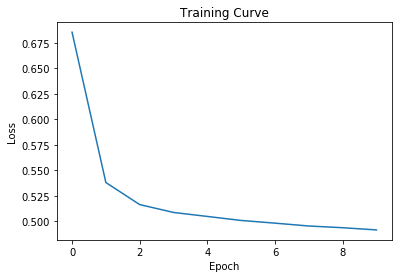

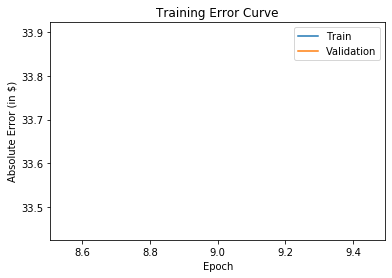

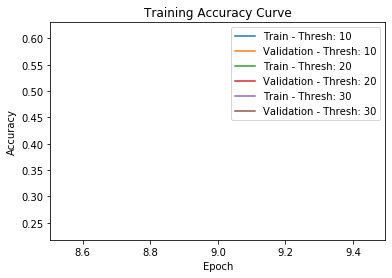

---[ITER 10] loss: 0.488222  time: 0.344
---[ITER 20] loss: 0.496836  time: 0.222
---[ITER 30] loss: 0.496360  time: 0.345
---[ITER 40] loss: 0.487322  time: 0.350
---[ITER 50] loss: 0.493217  time: 0.419
---[ITER 60] loss: 0.484849  time: 0.320
---[ITER 70] loss: 0.492170  time: 0.328
---[ITER 80] loss: 0.497992  time: 0.235
---[ITER 90] loss: 0.484904  time: 0.284
---[ITER 100] loss: 0.497050  time: 0.192
---[ITER 110] loss: 0.488117  time: 0.173
---[ITER 120] loss: 0.488300  time: 0.178
---[ITER 130] loss: 0.484761  time: 0.170
---[ITER 140] loss: 0.485674  time: 0.196
---[ITER 150] loss: 0.490332  time: 0.243
---[ITER 160] loss: 0.490655  time: 0.181
[EPOCH 11] loss: 0.490300  time: 4.323
---[ITER 10] loss: 0.486715  time: 0.297
---[ITER 20] loss: 0.489922  time: 0.246
---[ITER 30] loss: 0.483799  time: 0.371
---[ITER 40] loss: 0.487922  time: 0.268
---[ITER 50] loss: 0.491657  time: 0.235
---[ITER 60] loss: 0.487488  time: 0.220
---[ITER 70] loss: 0.478977  time: 0.243
---[ITER 80

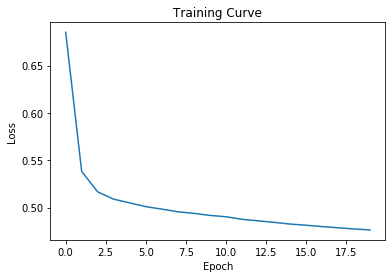

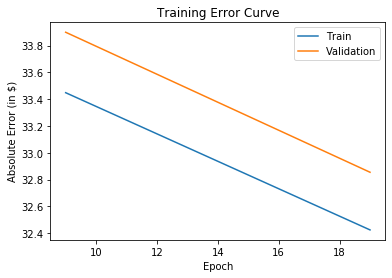

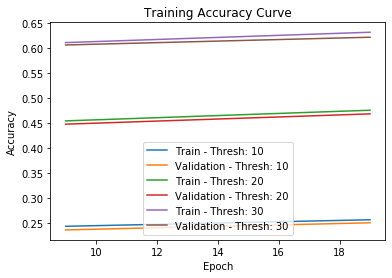

---[ITER 10] loss: 0.476299  time: 0.421
---[ITER 20] loss: 0.474982  time: 0.443
---[ITER 30] loss: 0.479952  time: 0.364
---[ITER 40] loss: 0.466380  time: 0.284
---[ITER 50] loss: 0.465726  time: 0.199
---[ITER 60] loss: 0.475238  time: 0.167
---[ITER 70] loss: 0.472304  time: 0.193
---[ITER 80] loss: 0.486259  time: 0.221
---[ITER 90] loss: 0.470366  time: 0.158
---[ITER 100] loss: 0.475571  time: 0.175
---[ITER 110] loss: 0.477630  time: 0.174
---[ITER 120] loss: 0.475705  time: 0.174
---[ITER 130] loss: 0.470504  time: 0.180
---[ITER 140] loss: 0.475642  time: 0.177
---[ITER 150] loss: 0.478464  time: 0.170
---[ITER 160] loss: 0.472764  time: 0.170
[EPOCH 21] loss: 0.474684  time: 3.784
---[ITER 10] loss: 0.474730  time: 0.250
---[ITER 20] loss: 0.476694  time: 0.286
---[ITER 30] loss: 0.480283  time: 0.169
---[ITER 40] loss: 0.476152  time: 0.177
---[ITER 50] loss: 0.465115  time: 0.150
---[ITER 60] loss: 0.472683  time: 0.169
---[ITER 70] loss: 0.475483  time: 0.156
---[ITER 80

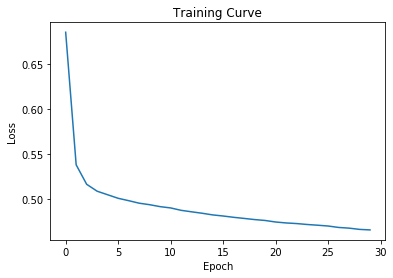

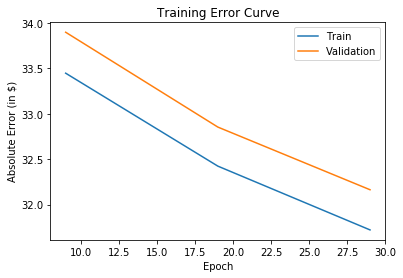

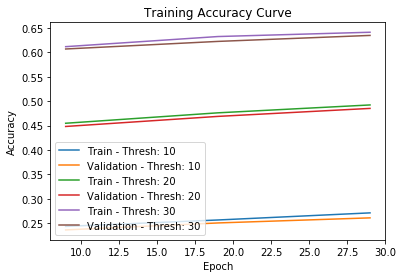

---[ITER 10] loss: 0.468667  time: 0.407
---[ITER 20] loss: 0.470122  time: 0.241
---[ITER 30] loss: 0.458073  time: 0.247
---[ITER 40] loss: 0.461927  time: 0.277
---[ITER 50] loss: 0.466934  time: 0.202
---[ITER 60] loss: 0.462931  time: 0.239
---[ITER 70] loss: 0.467286  time: 0.183
---[ITER 80] loss: 0.464749  time: 0.206
---[ITER 90] loss: 0.463765  time: 0.357
---[ITER 100] loss: 0.455294  time: 0.539
---[ITER 110] loss: 0.466629  time: 0.523
---[ITER 120] loss: 0.469086  time: 0.578
---[ITER 130] loss: 0.472994  time: 0.414
---[ITER 140] loss: 0.459016  time: 0.379
---[ITER 150] loss: 0.470440  time: 0.240
---[ITER 160] loss: 0.464868  time: 0.155
[EPOCH 31] loss: 0.465164  time: 5.571
---[ITER 10] loss: 0.464698  time: 0.543
---[ITER 20] loss: 0.458389  time: 0.171
---[ITER 30] loss: 0.463828  time: 0.214
---[ITER 40] loss: 0.463315  time: 0.206
---[ITER 50] loss: 0.472840  time: 0.195
---[ITER 60] loss: 0.457300  time: 0.221
---[ITER 70] loss: 0.457893  time: 0.183
---[ITER 80

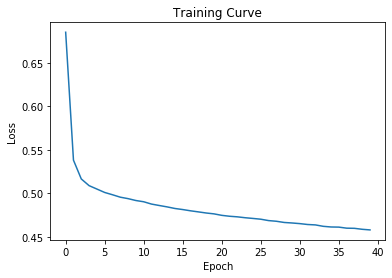

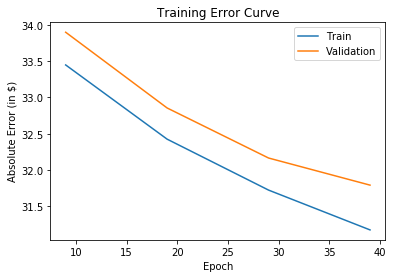

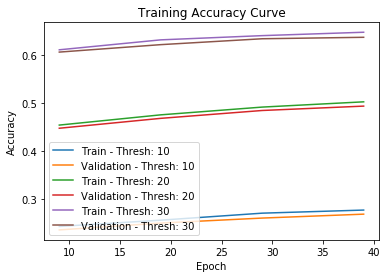

---[ITER 10] loss: 0.460849  time: 0.274
---[ITER 20] loss: 0.451589  time: 0.177
---[ITER 30] loss: 0.462340  time: 0.207
---[ITER 40] loss: 0.445051  time: 0.242
---[ITER 50] loss: 0.449053  time: 0.151
---[ITER 60] loss: 0.459932  time: 0.187
---[ITER 70] loss: 0.452725  time: 0.165
---[ITER 80] loss: 0.455724  time: 0.197
---[ITER 90] loss: 0.454797  time: 0.163
---[ITER 100] loss: 0.455349  time: 0.169
---[ITER 110] loss: 0.464121  time: 0.240
---[ITER 120] loss: 0.450031  time: 0.160
---[ITER 130] loss: 0.461742  time: 0.177
---[ITER 140] loss: 0.465277  time: 0.154
---[ITER 150] loss: 0.455794  time: 0.185
---[ITER 160] loss: 0.458179  time: 0.171
[EPOCH 41] loss: 0.456891  time: 3.174
---[ITER 10] loss: 0.451862  time: 0.269
---[ITER 20] loss: 0.449845  time: 0.173
---[ITER 30] loss: 0.455050  time: 0.179
---[ITER 40] loss: 0.451431  time: 0.255
---[ITER 50] loss: 0.465940  time: 0.154
---[ITER 60] loss: 0.451753  time: 0.180
---[ITER 70] loss: 0.459217  time: 0.164
---[ITER 80

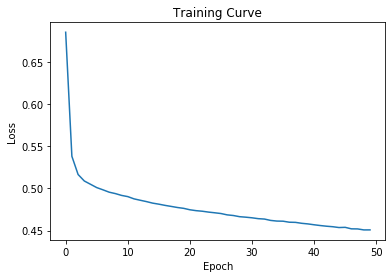

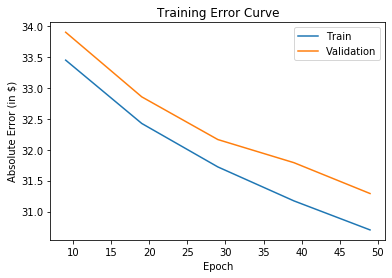

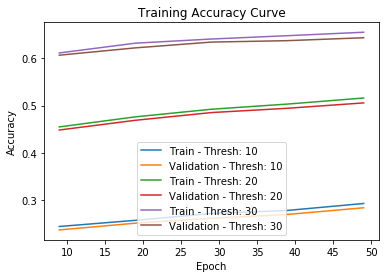

---[ITER 10] loss: 0.441018  time: 0.540
---[ITER 20] loss: 0.449226  time: 0.203
---[ITER 30] loss: 0.447058  time: 0.356
---[ITER 40] loss: 0.455667  time: 0.533
---[ITER 50] loss: 0.447542  time: 0.175
---[ITER 60] loss: 0.449978  time: 0.403
---[ITER 70] loss: 0.454944  time: 0.287
---[ITER 80] loss: 0.449936  time: 0.164
---[ITER 90] loss: 0.457678  time: 0.193
---[ITER 100] loss: 0.452245  time: 0.214
---[ITER 110] loss: 0.450133  time: 0.192
---[ITER 120] loss: 0.446605  time: 0.693
---[ITER 130] loss: 0.443539  time: 0.164
---[ITER 140] loss: 0.448957  time: 0.238
---[ITER 150] loss: 0.451802  time: 0.204
---[ITER 160] loss: 0.443940  time: 0.193
[EPOCH 51] loss: 0.449570  time: 5.024
---[ITER 10] loss: 0.450126  time: 0.248
---[ITER 20] loss: 0.447112  time: 0.174
---[ITER 30] loss: 0.447326  time: 0.254
---[ITER 40] loss: 0.443840  time: 0.176
---[ITER 50] loss: 0.456372  time: 0.201
---[ITER 60] loss: 0.451674  time: 0.248
---[ITER 70] loss: 0.454690  time: 0.167
---[ITER 80

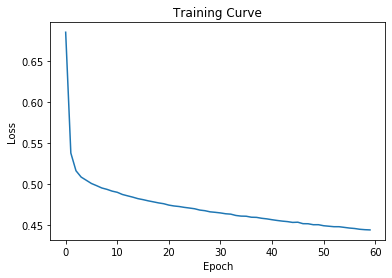

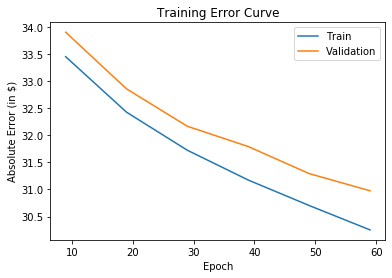

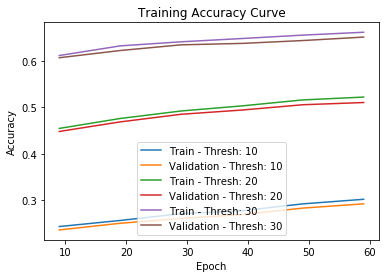

---[ITER 10] loss: 0.434877  time: 0.237
---[ITER 20] loss: 0.444499  time: 0.281
---[ITER 30] loss: 0.440815  time: 0.149
---[ITER 40] loss: 0.442664  time: 0.164
---[ITER 50] loss: 0.440862  time: 0.227
---[ITER 60] loss: 0.444705  time: 0.160
---[ITER 70] loss: 0.442323  time: 0.258
---[ITER 80] loss: 0.438372  time: 0.157
---[ITER 90] loss: 0.447042  time: 0.205
---[ITER 100] loss: 0.448170  time: 0.195
---[ITER 110] loss: 0.445119  time: 0.166
---[ITER 120] loss: 0.449739  time: 0.172
---[ITER 130] loss: 0.448108  time: 0.190
---[ITER 140] loss: 0.441428  time: 0.149
---[ITER 150] loss: 0.440838  time: 0.156
---[ITER 160] loss: 0.441733  time: 0.168
[EPOCH 61] loss: 0.443538  time: 3.161
---[ITER 10] loss: 0.439162  time: 0.240
---[ITER 20] loss: 0.443221  time: 0.258
---[ITER 30] loss: 0.446883  time: 0.151
---[ITER 40] loss: 0.438613  time: 0.160
---[ITER 50] loss: 0.436470  time: 0.183
---[ITER 60] loss: 0.437273  time: 0.153
---[ITER 70] loss: 0.446652  time: 0.174
---[ITER 80

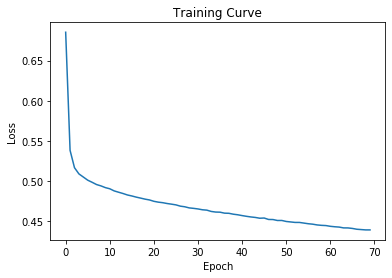

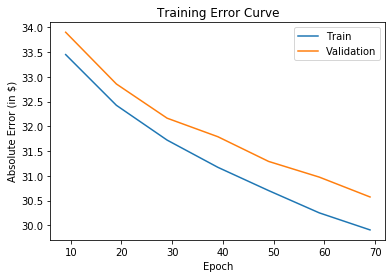

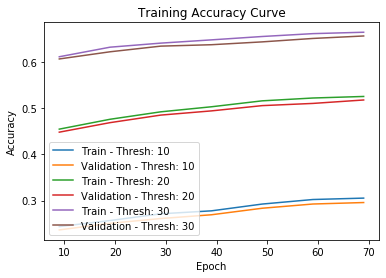

---[ITER 10] loss: 0.432219  time: 0.358
---[ITER 20] loss: 0.432708  time: 0.186
---[ITER 30] loss: 0.445911  time: 0.249
---[ITER 40] loss: 0.431224  time: 0.159
---[ITER 50] loss: 0.429752  time: 0.161
---[ITER 60] loss: 0.436332  time: 0.167
---[ITER 70] loss: 0.445207  time: 0.162
---[ITER 80] loss: 0.442633  time: 0.162
---[ITER 90] loss: 0.442404  time: 0.168
---[ITER 100] loss: 0.438565  time: 0.164
---[ITER 110] loss: 0.439810  time: 0.176
---[ITER 120] loss: 0.443366  time: 0.176
---[ITER 130] loss: 0.443878  time: 0.173
---[ITER 140] loss: 0.445914  time: 0.147
---[ITER 150] loss: 0.438470  time: 0.184
---[ITER 160] loss: 0.434139  time: 0.142
[EPOCH 71] loss: 0.438684  time: 3.063
---[ITER 10] loss: 0.437953  time: 0.358
---[ITER 20] loss: 0.434366  time: 0.159
---[ITER 30] loss: 0.436503  time: 0.193
---[ITER 40] loss: 0.430322  time: 0.152
---[ITER 50] loss: 0.439268  time: 0.161
---[ITER 60] loss: 0.444404  time: 0.159
---[ITER 70] loss: 0.433570  time: 0.169
---[ITER 80

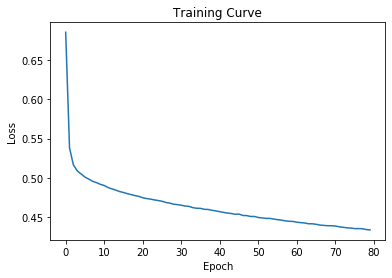

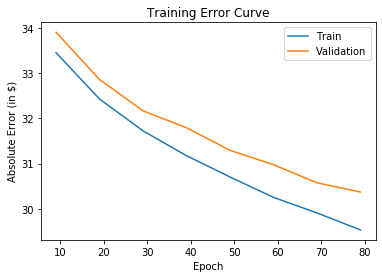

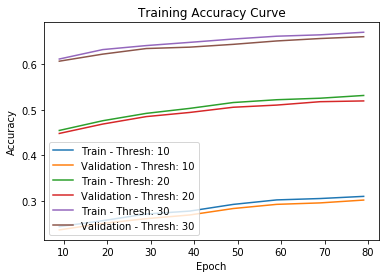

---[ITER 10] loss: 0.425533  time: 0.239
---[ITER 20] loss: 0.433623  time: 0.173
---[ITER 30] loss: 0.442811  time: 0.352
---[ITER 40] loss: 0.430813  time: 0.297
---[ITER 50] loss: 0.438786  time: 0.179
---[ITER 60] loss: 0.430556  time: 0.179
---[ITER 70] loss: 0.431375  time: 0.157
---[ITER 80] loss: 0.441006  time: 0.183
---[ITER 90] loss: 0.437767  time: 0.146
---[ITER 100] loss: 0.433403  time: 0.160
---[ITER 110] loss: 0.435077  time: 0.164
---[ITER 120] loss: 0.430427  time: 0.169
---[ITER 130] loss: 0.431218  time: 0.213
---[ITER 140] loss: 0.437186  time: 0.170
---[ITER 150] loss: 0.434438  time: 0.192
---[ITER 160] loss: 0.431450  time: 0.188
[EPOCH 81] loss: 0.433548  time: 3.296
---[ITER 10] loss: 0.434722  time: 0.238
---[ITER 20] loss: 0.438004  time: 0.253
---[ITER 30] loss: 0.426205  time: 0.257
---[ITER 40] loss: 0.434846  time: 0.160
---[ITER 50] loss: 0.432395  time: 0.156
---[ITER 60] loss: 0.426415  time: 0.152
---[ITER 70] loss: 0.434890  time: 0.177
---[ITER 80

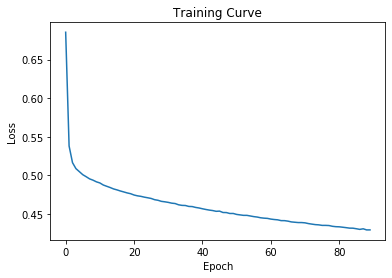

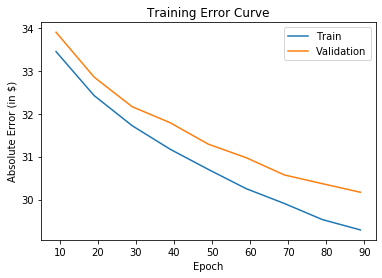

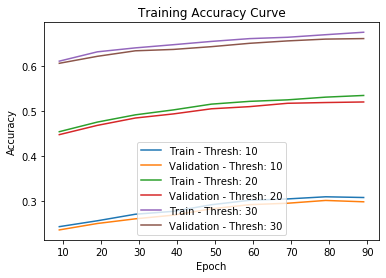

---[ITER 10] loss: 0.428864  time: 0.254
---[ITER 20] loss: 0.428270  time: 0.244
---[ITER 30] loss: 0.426328  time: 0.190
---[ITER 40] loss: 0.435047  time: 0.172
---[ITER 50] loss: 0.438340  time: 0.156
---[ITER 60] loss: 0.424413  time: 0.175
---[ITER 70] loss: 0.435054  time: 0.144
---[ITER 80] loss: 0.428353  time: 0.155
---[ITER 90] loss: 0.423596  time: 0.154
---[ITER 100] loss: 0.425124  time: 0.163
---[ITER 110] loss: 0.429994  time: 0.166
---[ITER 120] loss: 0.426664  time: 0.158
---[ITER 130] loss: 0.423649  time: 0.182
---[ITER 140] loss: 0.430389  time: 0.178
---[ITER 150] loss: 0.428857  time: 0.161
---[ITER 160] loss: 0.430812  time: 0.180
[EPOCH 91] loss: 0.429516  time: 2.946
---[ITER 10] loss: 0.415832  time: 0.249
---[ITER 20] loss: 0.434099  time: 0.254
---[ITER 30] loss: 0.437710  time: 0.171
---[ITER 40] loss: 0.425804  time: 0.200
---[ITER 50] loss: 0.421513  time: 0.222
---[ITER 60] loss: 0.422040  time: 0.196
---[ITER 70] loss: 0.436846  time: 0.153
---[ITER 80

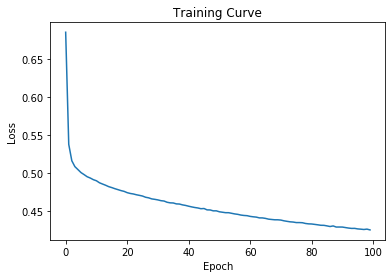

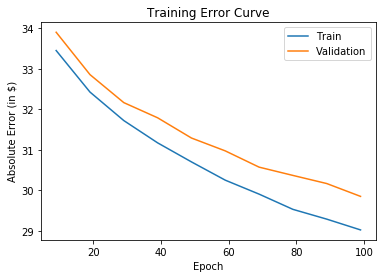

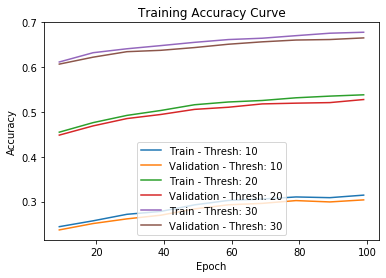

---[ITER 10] loss: 0.423846  time: 0.471
---[ITER 20] loss: 0.427109  time: 0.279
---[ITER 30] loss: 0.432167  time: 0.280
---[ITER 40] loss: 0.424559  time: 0.291
---[ITER 50] loss: 0.423937  time: 0.261
---[ITER 60] loss: 0.425687  time: 0.271
---[ITER 70] loss: 0.426061  time: 0.275
---[ITER 80] loss: 0.419887  time: 0.247
---[ITER 90] loss: 0.426598  time: 0.232
---[ITER 100] loss: 0.417250  time: 0.266
---[ITER 110] loss: 0.423939  time: 0.279
---[ITER 120] loss: 0.429435  time: 0.253
---[ITER 130] loss: 0.426751  time: 0.278
---[ITER 140] loss: 0.425342  time: 0.185
---[ITER 150] loss: 0.422396  time: 0.340
---[ITER 160] loss: 0.428147  time: 0.278
[EPOCH 101] loss: 0.425286  time: 4.695
---[ITER 10] loss: 0.418024  time: 0.477
---[ITER 20] loss: 0.431625  time: 0.270
---[ITER 30] loss: 0.428602  time: 0.208
---[ITER 40] loss: 0.429567  time: 0.200
---[ITER 50] loss: 0.429118  time: 0.190
---[ITER 60] loss: 0.424778  time: 0.139
---[ITER 70] loss: 0.428569  time: 0.192
---[ITER 8

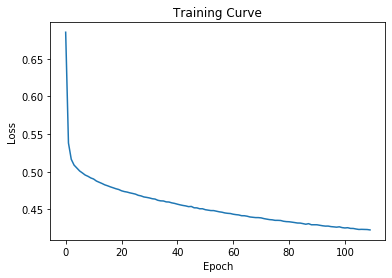

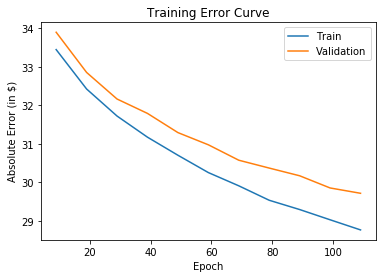

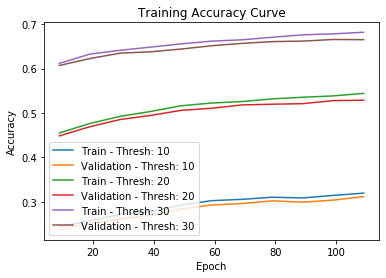

---[ITER 10] loss: 0.420184  time: 0.626
---[ITER 20] loss: 0.426536  time: 0.411
---[ITER 30] loss: 0.424526  time: 0.267
---[ITER 40] loss: 0.418657  time: 0.476
---[ITER 50] loss: 0.420593  time: 0.298
---[ITER 60] loss: 0.424928  time: 0.199
---[ITER 70] loss: 0.425276  time: 0.278
---[ITER 80] loss: 0.422266  time: 0.303
---[ITER 90] loss: 0.424883  time: 0.281
---[ITER 100] loss: 0.434552  time: 0.548
---[ITER 110] loss: 0.426344  time: 0.566
---[ITER 120] loss: 0.416763  time: 0.771
---[ITER 130] loss: 0.411887  time: 0.412
---[ITER 140] loss: 0.415814  time: 0.234
---[ITER 150] loss: 0.416453  time: 0.263
---[ITER 160] loss: 0.417122  time: 0.294
[EPOCH 111] loss: 0.421588  time: 6.365
---[ITER 10] loss: 0.414176  time: 0.443
---[ITER 20] loss: 0.422071  time: 0.177
---[ITER 30] loss: 0.421491  time: 0.188
---[ITER 40] loss: 0.428032  time: 0.166
---[ITER 50] loss: 0.421825  time: 0.316
---[ITER 60] loss: 0.417475  time: 0.192
---[ITER 70] loss: 0.423080  time: 0.191
---[ITER 8

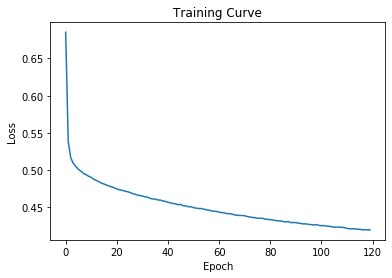

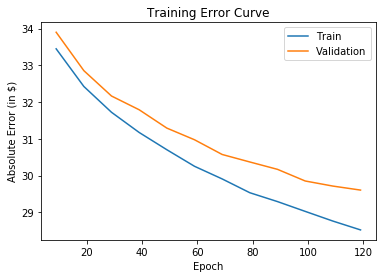

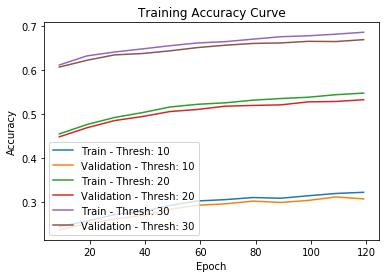

---[ITER 10] loss: 0.423279  time: 0.381
---[ITER 20] loss: 0.426477  time: 0.330
---[ITER 30] loss: 0.421506  time: 0.339
---[ITER 40] loss: 0.413532  time: 0.254
---[ITER 50] loss: 0.418922  time: 0.279
---[ITER 60] loss: 0.427189  time: 0.214
---[ITER 70] loss: 0.420131  time: 0.242
---[ITER 80] loss: 0.412339  time: 0.205
---[ITER 90] loss: 0.416675  time: 0.269
---[ITER 100] loss: 0.414317  time: 0.241
---[ITER 110] loss: 0.415914  time: 0.229
---[ITER 120] loss: 0.424844  time: 0.316
---[ITER 130] loss: 0.412996  time: 0.237
---[ITER 140] loss: 0.419356  time: 0.303
---[ITER 150] loss: 0.419307  time: 0.209
---[ITER 160] loss: 0.414130  time: 0.177
[EPOCH 121] loss: 0.418835  time: 4.443
---[ITER 10] loss: 0.431581  time: 0.378
---[ITER 20] loss: 0.414571  time: 0.244
---[ITER 30] loss: 0.414989  time: 0.371
---[ITER 40] loss: 0.413469  time: 0.264
---[ITER 50] loss: 0.421404  time: 0.297
---[ITER 60] loss: 0.414606  time: 0.231
---[ITER 70] loss: 0.421126  time: 0.435
---[ITER 8

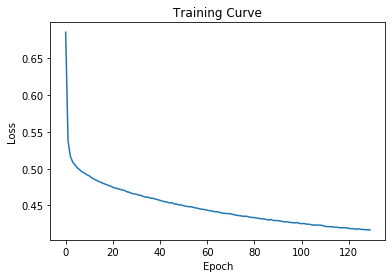

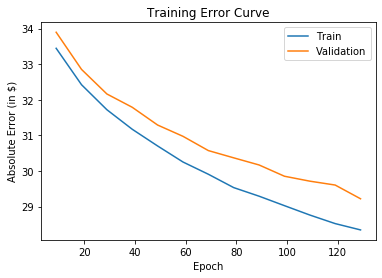

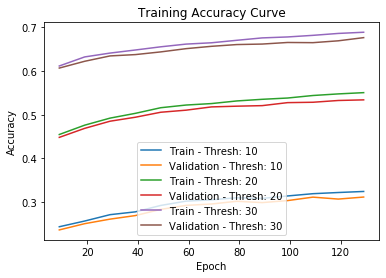

---[ITER 10] loss: 0.422653  time: 0.350
---[ITER 20] loss: 0.418689  time: 0.322
---[ITER 30] loss: 0.413896  time: 0.503
---[ITER 40] loss: 0.411733  time: 0.286
---[ITER 50] loss: 0.416303  time: 0.186
---[ITER 60] loss: 0.419310  time: 0.192
---[ITER 70] loss: 0.414034  time: 0.186
---[ITER 80] loss: 0.417513  time: 0.180
---[ITER 90] loss: 0.409487  time: 0.172
---[ITER 100] loss: 0.413747  time: 0.248
---[ITER 110] loss: 0.421833  time: 0.294
---[ITER 120] loss: 0.410683  time: 0.287
---[ITER 130] loss: 0.419842  time: 0.277
---[ITER 140] loss: 0.412380  time: 0.302
---[ITER 150] loss: 0.406149  time: 0.199
---[ITER 160] loss: 0.428568  time: 0.272
[EPOCH 131] loss: 0.416355  time: 4.426
---[ITER 10] loss: 0.416635  time: 0.344
---[ITER 20] loss: 0.409370  time: 0.293
---[ITER 30] loss: 0.415561  time: 0.222
---[ITER 40] loss: 0.413764  time: 0.239
---[ITER 50] loss: 0.417730  time: 0.263
---[ITER 60] loss: 0.416050  time: 0.256
---[ITER 70] loss: 0.426105  time: 0.258
---[ITER 8

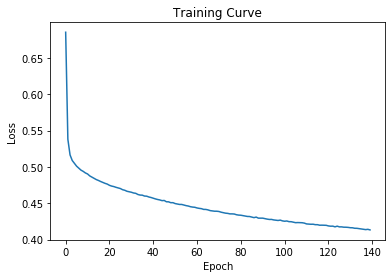

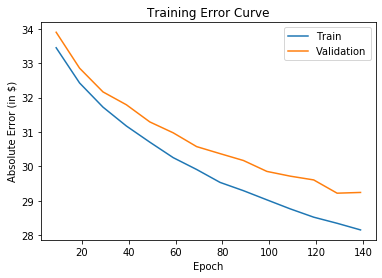

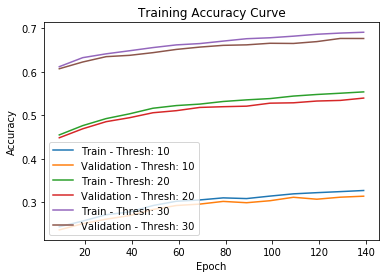

---[ITER 10] loss: 0.412385  time: 0.361
---[ITER 20] loss: 0.412804  time: 0.151
---[ITER 30] loss: 0.412204  time: 0.226
---[ITER 40] loss: 0.415235  time: 0.171
---[ITER 50] loss: 0.406132  time: 0.169
---[ITER 60] loss: 0.412993  time: 0.168
---[ITER 70] loss: 0.415259  time: 0.177
---[ITER 80] loss: 0.418526  time: 0.183
---[ITER 90] loss: 0.416469  time: 0.181
---[ITER 100] loss: 0.411168  time: 0.157
---[ITER 110] loss: 0.413883  time: 0.198
---[ITER 120] loss: 0.418547  time: 0.161
---[ITER 130] loss: 0.410616  time: 0.357
---[ITER 140] loss: 0.420690  time: 0.310
---[ITER 150] loss: 0.409336  time: 0.235
---[ITER 160] loss: 0.410823  time: 0.245
[EPOCH 141] loss: 0.413428  time: 3.613
---[ITER 10] loss: 0.407662  time: 0.406
---[ITER 20] loss: 0.413515  time: 0.155
---[ITER 30] loss: 0.412015  time: 0.173
---[ITER 40] loss: 0.407138  time: 0.158
---[ITER 50] loss: 0.413523  time: 0.201
---[ITER 60] loss: 0.407304  time: 0.183
---[ITER 70] loss: 0.416185  time: 0.187
---[ITER 8

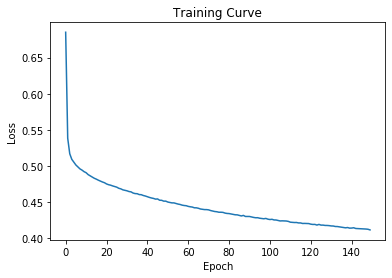

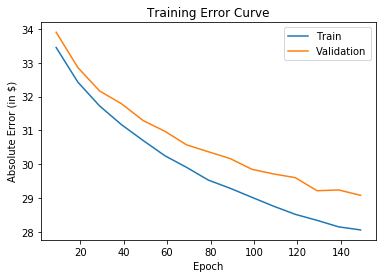

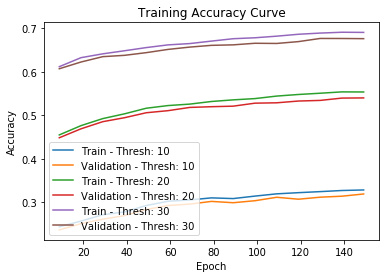

---[ITER 10] loss: 0.409837  time: 0.269
---[ITER 20] loss: 0.410216  time: 0.181
---[ITER 30] loss: 0.408211  time: 0.172
---[ITER 40] loss: 0.413811  time: 0.314
---[ITER 50] loss: 0.414630  time: 0.162
---[ITER 60] loss: 0.402148  time: 0.195
---[ITER 70] loss: 0.410424  time: 0.158
---[ITER 80] loss: 0.412881  time: 0.165
---[ITER 90] loss: 0.412495  time: 0.186
---[ITER 100] loss: 0.414607  time: 0.185
---[ITER 110] loss: 0.413827  time: 0.183
---[ITER 120] loss: 0.414560  time: 0.215
---[ITER 130] loss: 0.414979  time: 0.176
---[ITER 140] loss: 0.413905  time: 0.174
---[ITER 150] loss: 0.414154  time: 0.189
---[ITER 160] loss: 0.403471  time: 0.163
[EPOCH 151] loss: 0.411652  time: 3.216
---[ITER 10] loss: 0.417481  time: 0.254
---[ITER 20] loss: 0.413187  time: 0.147
---[ITER 30] loss: 0.417752  time: 0.256
---[ITER 40] loss: 0.417016  time: 0.231
---[ITER 50] loss: 0.409615  time: 0.154
---[ITER 60] loss: 0.413044  time: 0.191
---[ITER 70] loss: 0.409962  time: 0.155
---[ITER 8

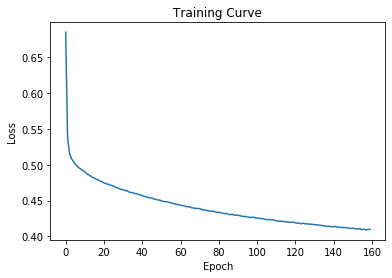

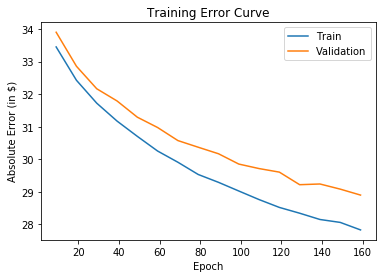

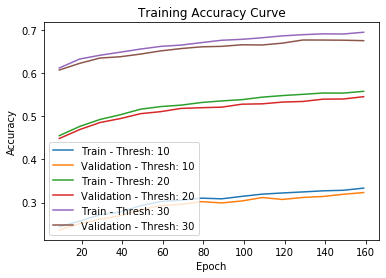

---[ITER 10] loss: 0.415292  time: 0.250
---[ITER 20] loss: 0.419758  time: 0.158
---[ITER 30] loss: 0.410343  time: 0.276
---[ITER 40] loss: 0.402727  time: 0.164
---[ITER 50] loss: 0.404678  time: 0.184
---[ITER 60] loss: 0.406272  time: 0.158
---[ITER 70] loss: 0.408488  time: 0.143
---[ITER 80] loss: 0.416685  time: 0.186
---[ITER 90] loss: 0.402971  time: 0.160
---[ITER 100] loss: 0.410432  time: 0.173
---[ITER 110] loss: 0.410948  time: 0.164
---[ITER 120] loss: 0.396941  time: 0.160
---[ITER 130] loss: 0.408544  time: 0.154
---[ITER 140] loss: 0.403541  time: 0.178
---[ITER 150] loss: 0.413064  time: 0.171
---[ITER 160] loss: 0.410080  time: 0.140
[EPOCH 161] loss: 0.408954  time: 3.062
---[ITER 10] loss: 0.409156  time: 0.227
---[ITER 20] loss: 0.412868  time: 0.149
---[ITER 30] loss: 0.404969  time: 0.280
---[ITER 40] loss: 0.408409  time: 0.162
---[ITER 50] loss: 0.410055  time: 0.159
---[ITER 60] loss: 0.408271  time: 0.164
---[ITER 70] loss: 0.409665  time: 0.148
---[ITER 8

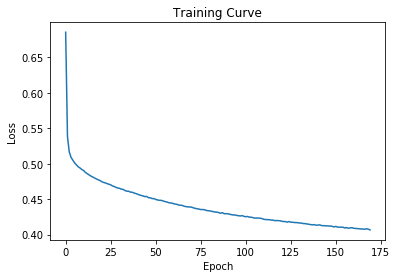

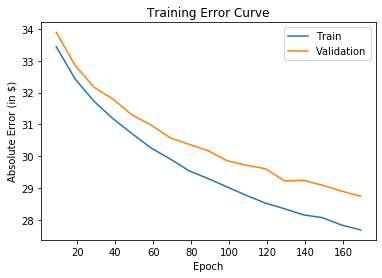

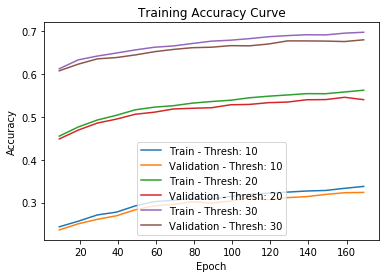

---[ITER 10] loss: 0.401757  time: 0.341
---[ITER 20] loss: 0.411673  time: 0.290
---[ITER 30] loss: 0.404367  time: 0.322
---[ITER 40] loss: 0.415535  time: 0.329
---[ITER 50] loss: 0.406132  time: 0.247
---[ITER 60] loss: 0.400676  time: 0.250
---[ITER 70] loss: 0.411792  time: 0.303
---[ITER 80] loss: 0.393031  time: 0.201
---[ITER 90] loss: 0.407062  time: 0.198
---[ITER 100] loss: 0.406574  time: 0.171
---[ITER 110] loss: 0.407633  time: 0.263
---[ITER 120] loss: 0.406589  time: 0.199
---[ITER 130] loss: 0.405744  time: 0.233
---[ITER 140] loss: 0.407517  time: 0.183
---[ITER 150] loss: 0.411204  time: 0.233
---[ITER 160] loss: 0.416672  time: 0.195
[EPOCH 171] loss: 0.407138  time: 4.261
---[ITER 10] loss: 0.402771  time: 0.503
---[ITER 20] loss: 0.402883  time: 0.407
---[ITER 30] loss: 0.407683  time: 0.173
---[ITER 40] loss: 0.395144  time: 0.190
---[ITER 50] loss: 0.402714  time: 0.490
---[ITER 60] loss: 0.406141  time: 0.611
---[ITER 70] loss: 0.411455  time: 0.586
---[ITER 8

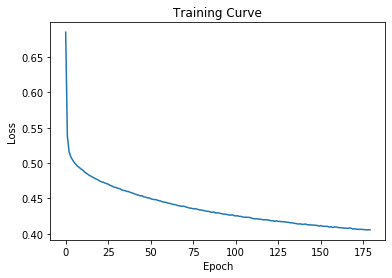

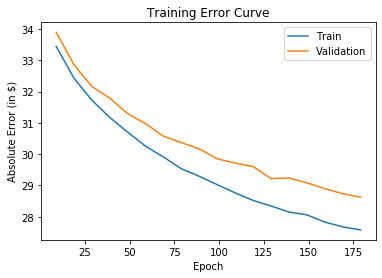

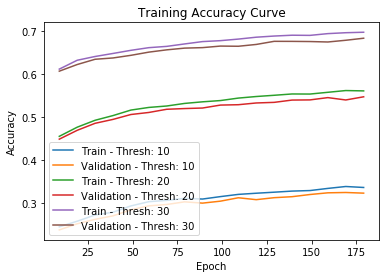

---[ITER 10] loss: 0.402630  time: 0.446
---[ITER 20] loss: 0.407036  time: 0.138
---[ITER 30] loss: 0.408329  time: 0.148
---[ITER 40] loss: 0.409323  time: 0.433
---[ITER 50] loss: 0.398607  time: 0.358
---[ITER 60] loss: 0.401652  time: 0.456
---[ITER 70] loss: 0.406502  time: 0.221
---[ITER 80] loss: 0.404525  time: 0.134
---[ITER 90] loss: 0.411213  time: 0.142
---[ITER 100] loss: 0.403243  time: 0.232
---[ITER 110] loss: 0.403388  time: 0.170
---[ITER 120] loss: 0.405017  time: 0.253
---[ITER 130] loss: 0.410611  time: 0.185
---[ITER 140] loss: 0.402358  time: 0.200
---[ITER 150] loss: 0.403961  time: 0.168
---[ITER 160] loss: 0.404562  time: 0.174
[EPOCH 181] loss: 0.405098  time: 3.987
---[ITER 10] loss: 0.402000  time: 0.359
---[ITER 20] loss: 0.403077  time: 0.153
---[ITER 30] loss: 0.397930  time: 0.221
---[ITER 40] loss: 0.393848  time: 0.362
---[ITER 50] loss: 0.405453  time: 0.285
---[ITER 60] loss: 0.405808  time: 0.182
---[ITER 70] loss: 0.408576  time: 0.188
---[ITER 8

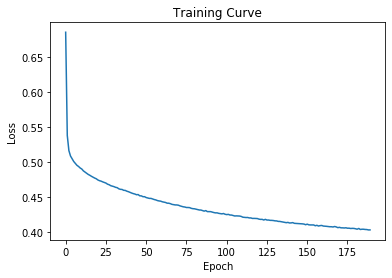

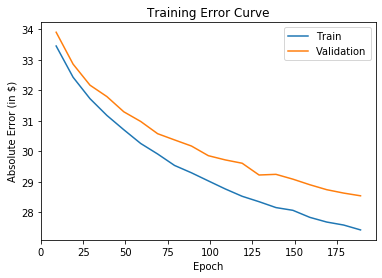

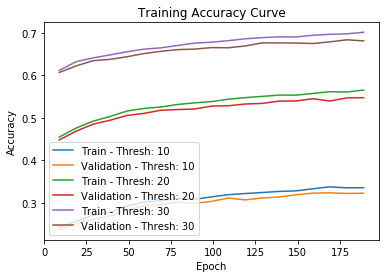

---[ITER 10] loss: 0.406952  time: 0.229
---[ITER 20] loss: 0.396757  time: 0.137
---[ITER 30] loss: 0.404161  time: 0.210
---[ITER 40] loss: 0.397760  time: 0.139
---[ITER 50] loss: 0.405550  time: 0.147
---[ITER 60] loss: 0.401723  time: 0.132
---[ITER 70] loss: 0.401135  time: 0.138
---[ITER 80] loss: 0.404397  time: 0.138
---[ITER 90] loss: 0.399287  time: 0.134
---[ITER 100] loss: 0.409882  time: 0.129
---[ITER 110] loss: 0.412253  time: 0.137
---[ITER 120] loss: 0.408694  time: 0.136
---[ITER 130] loss: 0.395297  time: 0.140
---[ITER 140] loss: 0.407533  time: 0.136
---[ITER 150] loss: 0.407238  time: 0.180
---[ITER 160] loss: 0.406211  time: 0.132
[EPOCH 191] loss: 0.403823  time: 2.517
---[ITER 10] loss: 0.393367  time: 0.197
---[ITER 20] loss: 0.402801  time: 0.148
---[ITER 30] loss: 0.397280  time: 0.220
---[ITER 40] loss: 0.397923  time: 0.146
---[ITER 50] loss: 0.406810  time: 0.135
---[ITER 60] loss: 0.403206  time: 0.133
---[ITER 70] loss: 0.400600  time: 0.136
---[ITER 8

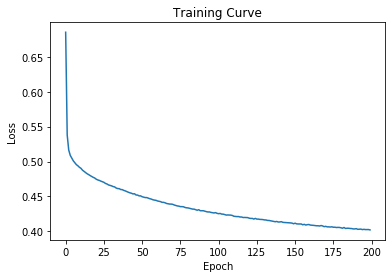

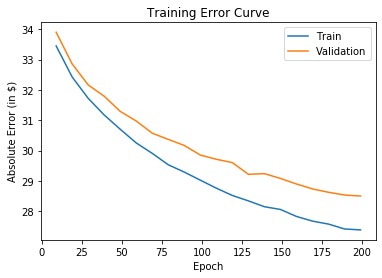

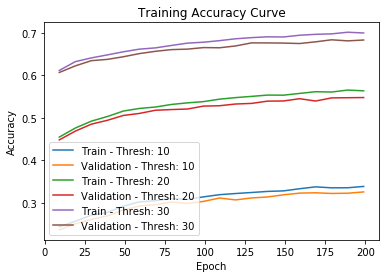

---[ITER 10] loss: 0.398730  time: 0.193
---[ITER 20] loss: 0.398634  time: 0.222
---[ITER 30] loss: 0.402892  time: 0.150
---[ITER 40] loss: 0.399506  time: 0.136
---[ITER 50] loss: 0.408661  time: 0.164
---[ITER 60] loss: 0.400686  time: 0.140
---[ITER 70] loss: 0.398822  time: 0.131
---[ITER 80] loss: 0.398971  time: 0.134
---[ITER 90] loss: 0.405043  time: 0.133
---[ITER 100] loss: 0.408458  time: 0.135
---[ITER 110] loss: 0.402456  time: 0.140
---[ITER 120] loss: 0.397517  time: 0.135
---[ITER 130] loss: 0.403497  time: 0.134
---[ITER 140] loss: 0.404651  time: 0.191
---[ITER 150] loss: 0.402028  time: 0.118
---[ITER 160] loss: 0.395096  time: 0.137
[EPOCH 201] loss: 0.401678  time: 2.512
---[ITER 10] loss: 0.402692  time: 0.200
---[ITER 20] loss: 0.397072  time: 0.229
---[ITER 30] loss: 0.400811  time: 0.473
---[ITER 40] loss: 0.393978  time: 0.194
---[ITER 50] loss: 0.404469  time: 0.208
---[ITER 60] loss: 0.394901  time: 0.169
---[ITER 70] loss: 0.400964  time: 0.190
---[ITER 8

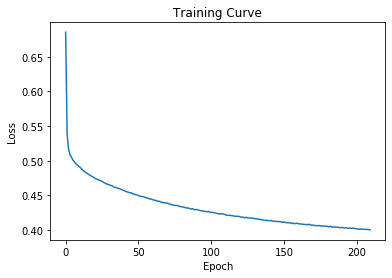

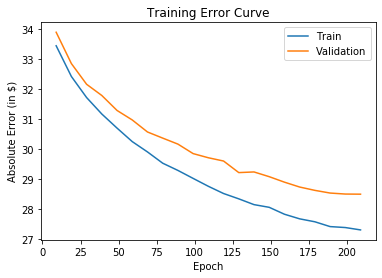

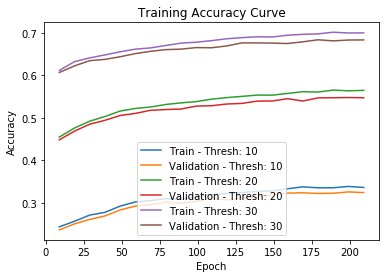

---[ITER 10] loss: 0.402391  time: 0.310
---[ITER 20] loss: 0.407627  time: 0.131
---[ITER 30] loss: 0.400362  time: 0.138
---[ITER 40] loss: 0.400154  time: 0.137
---[ITER 50] loss: 0.397038  time: 0.141
---[ITER 60] loss: 0.398562  time: 0.137
---[ITER 70] loss: 0.410804  time: 0.130
---[ITER 80] loss: 0.396164  time: 0.139
---[ITER 90] loss: 0.399669  time: 0.135
---[ITER 100] loss: 0.398110  time: 0.185
---[ITER 110] loss: 0.398754  time: 0.122
---[ITER 120] loss: 0.398727  time: 0.134
---[ITER 130] loss: 0.396990  time: 0.170
---[ITER 140] loss: 0.393379  time: 0.139
---[ITER 150] loss: 0.406930  time: 0.136
---[ITER 160] loss: 0.395366  time: 0.144
[EPOCH 211] loss: 0.400216  time: 2.541
---[ITER 10] loss: 0.403444  time: 0.302
---[ITER 20] loss: 0.398463  time: 0.132
---[ITER 30] loss: 0.405693  time: 0.132
---[ITER 40] loss: 0.401741  time: 0.136
---[ITER 50] loss: 0.391658  time: 0.136
---[ITER 60] loss: 0.396099  time: 0.135
---[ITER 70] loss: 0.404794  time: 0.145
---[ITER 8

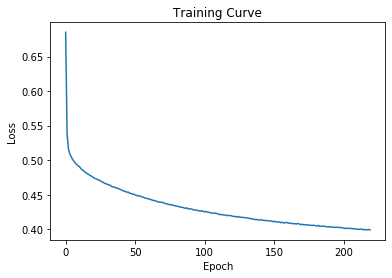

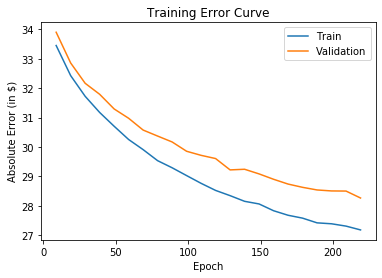

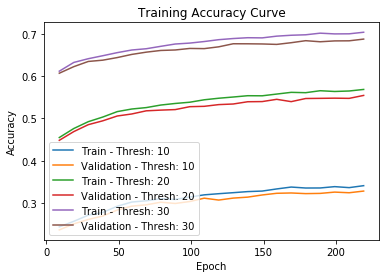

---[ITER 10] loss: 0.395652  time: 0.306
---[ITER 20] loss: 0.401119  time: 0.157
---[ITER 30] loss: 0.393666  time: 0.144
---[ITER 40] loss: 0.400488  time: 0.137
---[ITER 50] loss: 0.403354  time: 0.133
---[ITER 60] loss: 0.397226  time: 0.140
---[ITER 70] loss: 0.396892  time: 0.147
---[ITER 80] loss: 0.400080  time: 0.140
---[ITER 90] loss: 0.400340  time: 0.132
---[ITER 100] loss: 0.396073  time: 0.141
---[ITER 110] loss: 0.399188  time: 0.142
---[ITER 120] loss: 0.399198  time: 0.168
---[ITER 130] loss: 0.396361  time: 0.137
---[ITER 140] loss: 0.403671  time: 0.137
---[ITER 150] loss: 0.403193  time: 0.167
---[ITER 160] loss: 0.399956  time: 0.138
[EPOCH 221] loss: 0.399115  time: 2.588
---[ITER 10] loss: 0.400807  time: 0.308
---[ITER 20] loss: 0.392809  time: 0.135
---[ITER 30] loss: 0.397852  time: 0.150
---[ITER 40] loss: 0.400455  time: 0.137
---[ITER 50] loss: 0.393057  time: 0.138
---[ITER 60] loss: 0.397338  time: 0.142
---[ITER 70] loss: 0.395649  time: 0.136
---[ITER 8

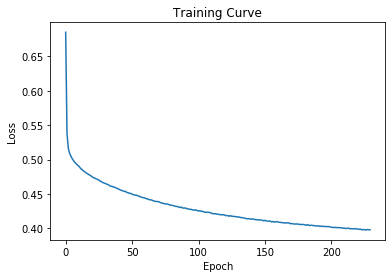

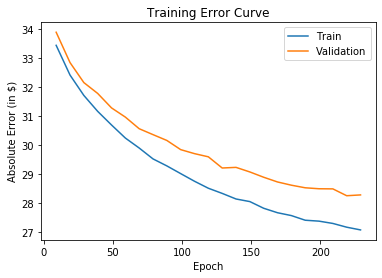

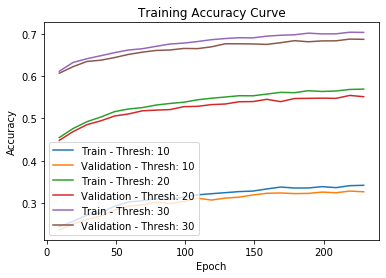

---[ITER 10] loss: 0.399555  time: 0.198
---[ITER 20] loss: 0.393464  time: 0.135
---[ITER 30] loss: 0.401767  time: 0.245
---[ITER 40] loss: 0.402770  time: 0.140
---[ITER 50] loss: 0.395526  time: 0.175
---[ITER 60] loss: 0.402505  time: 0.122
---[ITER 70] loss: 0.402445  time: 0.134
---[ITER 80] loss: 0.394629  time: 0.133
---[ITER 90] loss: 0.394042  time: 0.142
---[ITER 100] loss: 0.399563  time: 0.143
---[ITER 110] loss: 0.394169  time: 0.138
---[ITER 120] loss: 0.394943  time: 0.131
---[ITER 130] loss: 0.400238  time: 0.140
---[ITER 140] loss: 0.393513  time: 0.163
---[ITER 150] loss: 0.394128  time: 0.139
---[ITER 160] loss: 0.394561  time: 0.139
[EPOCH 231] loss: 0.397049  time: 2.540
---[ITER 10] loss: 0.399492  time: 0.195
---[ITER 20] loss: 0.404722  time: 0.194
---[ITER 30] loss: 0.401979  time: 0.209
---[ITER 40] loss: 0.401331  time: 0.138
---[ITER 50] loss: 0.391571  time: 0.138
---[ITER 60] loss: 0.385304  time: 0.133
---[ITER 70] loss: 0.400438  time: 0.142
---[ITER 8

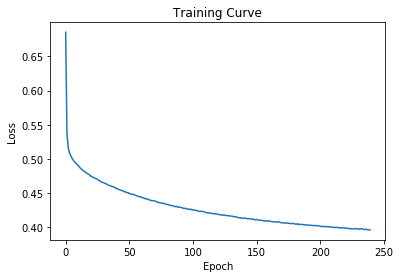

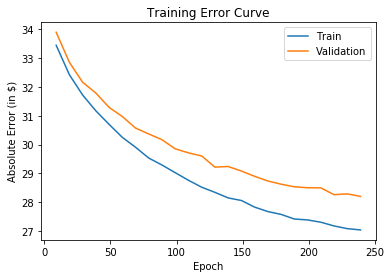

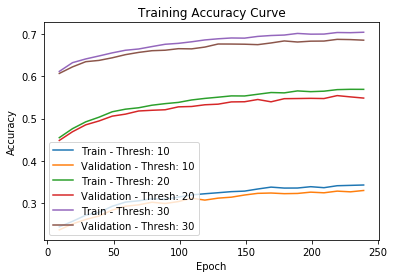

---[ITER 10] loss: 0.400157  time: 0.204
---[ITER 20] loss: 0.394622  time: 0.251
---[ITER 30] loss: 0.397494  time: 0.130
---[ITER 40] loss: 0.393700  time: 0.149
---[ITER 50] loss: 0.389166  time: 0.132
---[ITER 60] loss: 0.398850  time: 0.142
---[ITER 70] loss: 0.397637  time: 0.134
---[ITER 80] loss: 0.395882  time: 0.138
---[ITER 90] loss: 0.392463  time: 0.135
---[ITER 100] loss: 0.387473  time: 0.136
---[ITER 110] loss: 0.393442  time: 0.135
---[ITER 120] loss: 0.396297  time: 0.152
---[ITER 130] loss: 0.405658  time: 0.166
---[ITER 140] loss: 0.399874  time: 0.134
---[ITER 150] loss: 0.403208  time: 0.135
---[ITER 160] loss: 0.393529  time: 0.175
[EPOCH 241] loss: 0.396628  time: 2.559
---[ITER 10] loss: 0.401861  time: 0.202
---[ITER 20] loss: 0.397838  time: 0.235
---[ITER 30] loss: 0.395396  time: 0.132
---[ITER 40] loss: 0.399624  time: 0.139
---[ITER 50] loss: 0.394354  time: 0.136
---[ITER 60] loss: 0.403084  time: 0.133
---[ITER 70] loss: 0.390187  time: 0.191
---[ITER 8

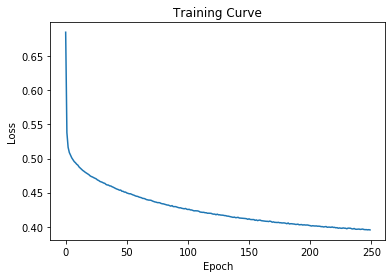

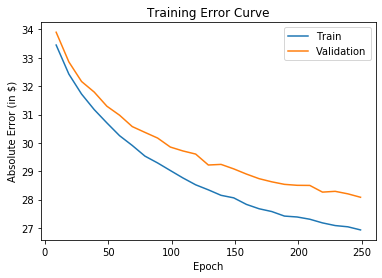

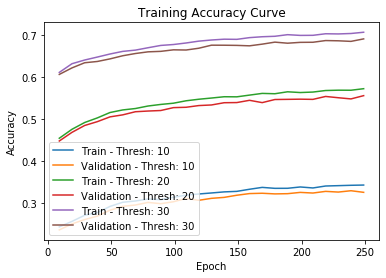

---[ITER 10] loss: 0.391060  time: 0.304
---[ITER 20] loss: 0.390474  time: 0.139
---[ITER 30] loss: 0.398260  time: 0.136
---[ITER 40] loss: 0.400599  time: 0.134
---[ITER 50] loss: 0.396103  time: 0.140
---[ITER 60] loss: 0.394945  time: 0.137
---[ITER 70] loss: 0.403011  time: 0.136
---[ITER 80] loss: 0.396951  time: 0.132
---[ITER 90] loss: 0.399897  time: 0.140
---[ITER 100] loss: 0.387490  time: 0.138
---[ITER 110] loss: 0.394748  time: 0.134
---[ITER 120] loss: 0.393927  time: 0.134
---[ITER 130] loss: 0.390537  time: 0.197
---[ITER 140] loss: 0.398037  time: 0.126
---[ITER 150] loss: 0.403384  time: 0.138
---[ITER 160] loss: 0.394807  time: 0.142
[EPOCH 251] loss: 0.395403  time: 2.525
---[ITER 10] loss: 0.393766  time: 0.298
---[ITER 20] loss: 0.393014  time: 0.138
---[ITER 30] loss: 0.399002  time: 0.142
---[ITER 40] loss: 0.397250  time: 0.134
---[ITER 50] loss: 0.402828  time: 0.141
---[ITER 60] loss: 0.399601  time: 0.139
---[ITER 70] loss: 0.395241  time: 0.137
---[ITER 8

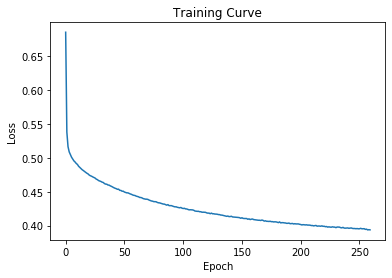

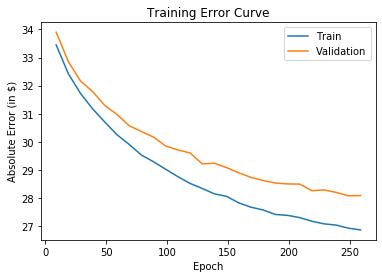

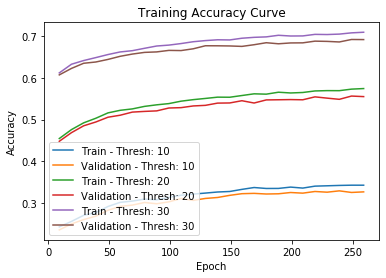

---[ITER 10] loss: 0.396101  time: 0.261
---[ITER 20] loss: 0.390503  time: 0.125
---[ITER 30] loss: 0.401898  time: 0.233
---[ITER 40] loss: 0.399457  time: 0.152
---[ITER 50] loss: 0.392411  time: 0.139
---[ITER 60] loss: 0.395476  time: 0.137
---[ITER 70] loss: 0.395802  time: 0.143
---[ITER 80] loss: 0.396835  time: 0.138
---[ITER 90] loss: 0.393844  time: 0.139
---[ITER 100] loss: 0.395403  time: 0.136
---[ITER 110] loss: 0.386625  time: 0.138
---[ITER 120] loss: 0.390322  time: 0.137
---[ITER 130] loss: 0.392706  time: 0.163
---[ITER 140] loss: 0.398373  time: 0.137
---[ITER 150] loss: 0.394288  time: 0.181
---[ITER 160] loss: 0.396161  time: 0.134
[EPOCH 261] loss: 0.394561  time: 2.614
---[ITER 10] loss: 0.394761  time: 0.203
---[ITER 20] loss: 0.394904  time: 0.141
---[ITER 30] loss: 0.399717  time: 0.138
---[ITER 40] loss: 0.397650  time: 0.229
---[ITER 50] loss: 0.395873  time: 0.136
---[ITER 60] loss: 0.397345  time: 0.141
---[ITER 70] loss: 0.389120  time: 0.139
---[ITER 8

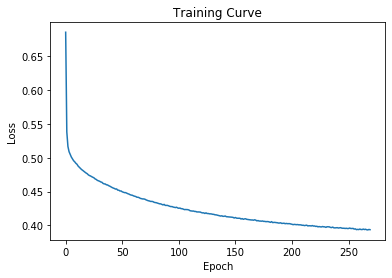

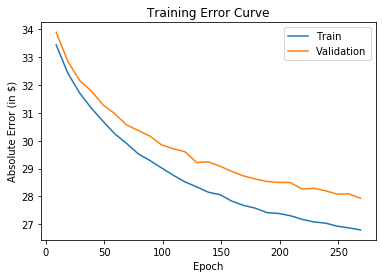

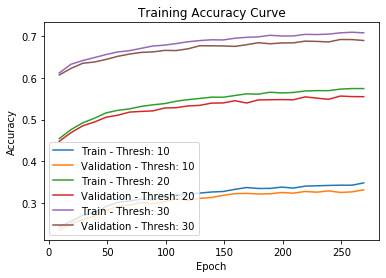

---[ITER 10] loss: 0.390563  time: 0.232
---[ITER 20] loss: 0.394818  time: 0.137
---[ITER 30] loss: 0.387262  time: 0.229
---[ITER 40] loss: 0.400414  time: 0.134
---[ITER 50] loss: 0.387650  time: 0.135
---[ITER 60] loss: 0.393795  time: 0.137
---[ITER 70] loss: 0.395220  time: 0.138
---[ITER 80] loss: 0.388970  time: 0.146
---[ITER 90] loss: 0.393379  time: 0.134
---[ITER 100] loss: 0.396456  time: 0.137
---[ITER 110] loss: 0.394688  time: 0.130
---[ITER 120] loss: 0.397740  time: 0.138
---[ITER 130] loss: 0.390077  time: 0.144
---[ITER 140] loss: 0.385440  time: 0.168
---[ITER 150] loss: 0.399648  time: 0.141
---[ITER 160] loss: 0.396811  time: 0.138
[EPOCH 271] loss: 0.393237  time: 2.535
---[ITER 10] loss: 0.390742  time: 0.193
---[ITER 20] loss: 0.397330  time: 0.141
---[ITER 30] loss: 0.400322  time: 0.228
---[ITER 40] loss: 0.393277  time: 0.136
---[ITER 50] loss: 0.388133  time: 0.145
---[ITER 60] loss: 0.396888  time: 0.141
---[ITER 70] loss: 0.387566  time: 0.139
---[ITER 8

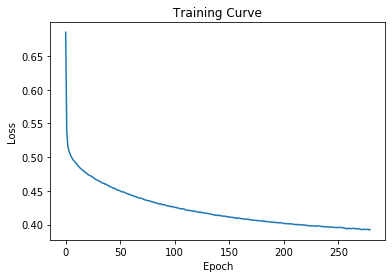

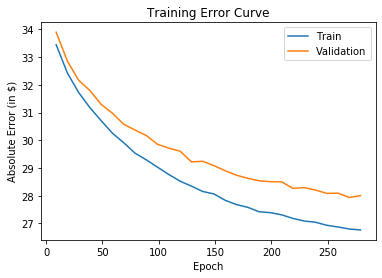

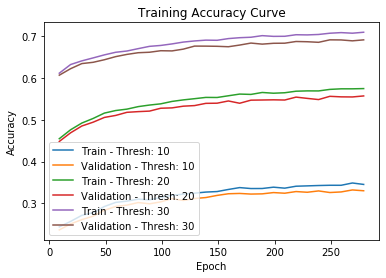

---[ITER 10] loss: 0.387296  time: 0.196
---[ITER 20] loss: 0.393590  time: 0.232
---[ITER 30] loss: 0.394285  time: 0.151
---[ITER 40] loss: 0.395023  time: 0.145
---[ITER 50] loss: 0.391046  time: 0.138
---[ITER 60] loss: 0.392116  time: 0.153
---[ITER 70] loss: 0.394089  time: 0.150
---[ITER 80] loss: 0.395732  time: 0.134
---[ITER 90] loss: 0.387731  time: 0.198
---[ITER 100] loss: 0.394516  time: 0.140
---[ITER 110] loss: 0.387095  time: 0.140
---[ITER 120] loss: 0.395008  time: 0.145
---[ITER 130] loss: 0.391624  time: 0.174
---[ITER 140] loss: 0.397914  time: 0.162
---[ITER 150] loss: 0.388704  time: 0.130
---[ITER 160] loss: 0.395570  time: 0.152
[EPOCH 281] loss: 0.392283  time: 2.673
---[ITER 10] loss: 0.395647  time: 0.195
---[ITER 20] loss: 0.393552  time: 0.242
---[ITER 30] loss: 0.386659  time: 0.152
---[ITER 40] loss: 0.390222  time: 0.137
---[ITER 50] loss: 0.392060  time: 0.137
---[ITER 60] loss: 0.389542  time: 0.137
---[ITER 70] loss: 0.392923  time: 0.134
---[ITER 8

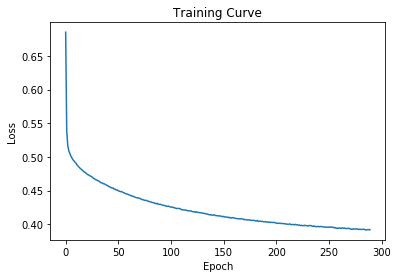

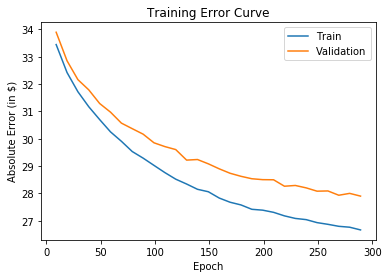

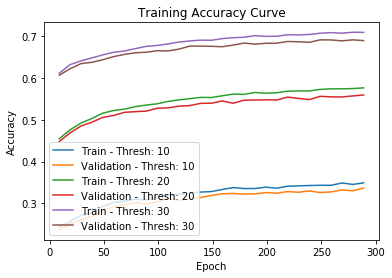

---[ITER 10] loss: 0.388869  time: 0.300
---[ITER 20] loss: 0.399676  time: 0.138
---[ITER 30] loss: 0.385130  time: 0.138
---[ITER 40] loss: 0.391189  time: 0.136
---[ITER 50] loss: 0.392028  time: 0.140
---[ITER 60] loss: 0.393852  time: 0.142
---[ITER 70] loss: 0.388617  time: 0.129
---[ITER 80] loss: 0.385606  time: 0.135
---[ITER 90] loss: 0.392953  time: 0.137
---[ITER 100] loss: 0.390424  time: 0.143
---[ITER 110] loss: 0.397890  time: 0.132
---[ITER 120] loss: 0.391512  time: 0.200
---[ITER 130] loss: 0.385346  time: 0.130
---[ITER 140] loss: 0.382956  time: 0.139
---[ITER 150] loss: 0.396592  time: 0.136
---[ITER 160] loss: 0.395981  time: 0.138
[EPOCH 291] loss: 0.390929  time: 2.536
---[ITER 10] loss: 0.393597  time: 0.314
---[ITER 20] loss: 0.401188  time: 0.130
---[ITER 30] loss: 0.387847  time: 0.148
---[ITER 40] loss: 0.398105  time: 0.130
---[ITER 50] loss: 0.397700  time: 0.138
---[ITER 60] loss: 0.386473  time: 0.144
---[ITER 70] loss: 0.393311  time: 0.131
---[ITER 8

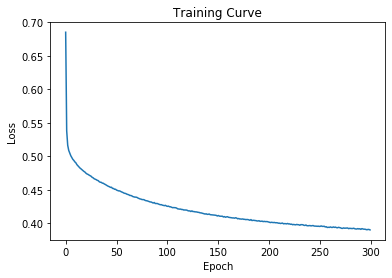

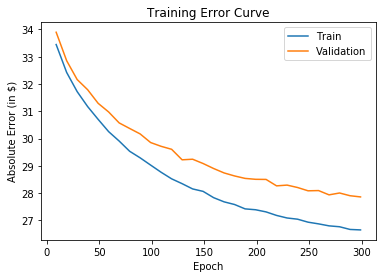

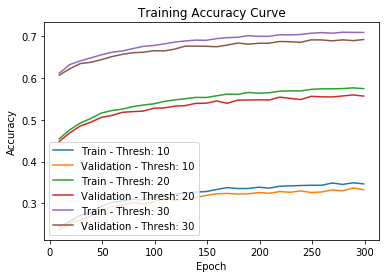

---[ITER 10] loss: 0.399115  time: 0.198
---[ITER 20] loss: 0.391213  time: 0.147
---[ITER 30] loss: 0.387996  time: 0.230
---[ITER 40] loss: 0.401092  time: 0.137
---[ITER 50] loss: 0.386223  time: 0.135
---[ITER 60] loss: 0.388104  time: 0.132
---[ITER 70] loss: 0.400536  time: 0.137
---[ITER 80] loss: 0.382790  time: 0.134
---[ITER 90] loss: 0.376250  time: 0.144
---[ITER 100] loss: 0.391850  time: 0.139
---[ITER 110] loss: 0.394131  time: 0.138
---[ITER 120] loss: 0.392055  time: 0.141
---[ITER 130] loss: 0.395584  time: 0.135
---[ITER 140] loss: 0.395202  time: 0.132
---[ITER 150] loss: 0.384112  time: 0.170
---[ITER 160] loss: 0.394175  time: 0.143
[EPOCH 301] loss: 0.391250  time: 2.515
---[ITER 10] loss: 0.401811  time: 0.238
---[ITER 20] loss: 0.388129  time: 0.135
---[ITER 30] loss: 0.391302  time: 0.220
---[ITER 40] loss: 0.391083  time: 0.137
---[ITER 50] loss: 0.395988  time: 0.161
---[ITER 60] loss: 0.395705  time: 0.134
---[ITER 70] loss: 0.382272  time: 0.152
---[ITER 8

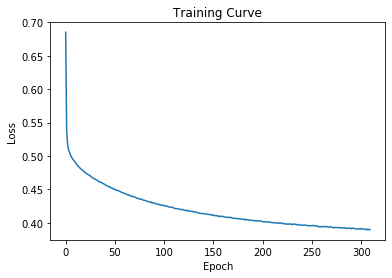

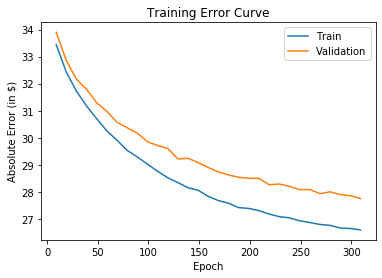

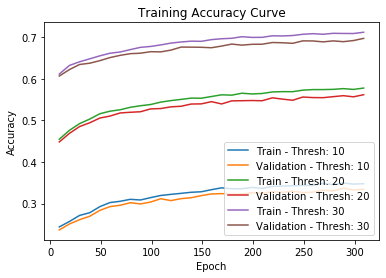

---[ITER 10] loss: 0.397668  time: 0.195
---[ITER 20] loss: 0.388565  time: 0.233
---[ITER 30] loss: 0.388738  time: 0.151
---[ITER 40] loss: 0.388071  time: 0.128
---[ITER 50] loss: 0.393012  time: 0.138
---[ITER 60] loss: 0.387757  time: 0.138
---[ITER 70] loss: 0.390633  time: 0.134
---[ITER 80] loss: 0.389089  time: 0.144
---[ITER 90] loss: 0.388659  time: 0.137
---[ITER 100] loss: 0.391086  time: 0.137
---[ITER 110] loss: 0.383319  time: 0.134
---[ITER 120] loss: 0.394550  time: 0.136
---[ITER 130] loss: 0.394769  time: 0.136
---[ITER 140] loss: 0.389167  time: 0.168
---[ITER 150] loss: 0.396193  time: 0.134
---[ITER 160] loss: 0.375803  time: 0.137
[EPOCH 311] loss: 0.389679  time: 2.505
---[ITER 10] loss: 0.383343  time: 0.207
---[ITER 20] loss: 0.391919  time: 0.233
---[ITER 30] loss: 0.393385  time: 0.136
---[ITER 40] loss: 0.390834  time: 0.148
---[ITER 50] loss: 0.388566  time: 0.133
---[ITER 60] loss: 0.393283  time: 0.188
---[ITER 70] loss: 0.384502  time: 0.121
---[ITER 8

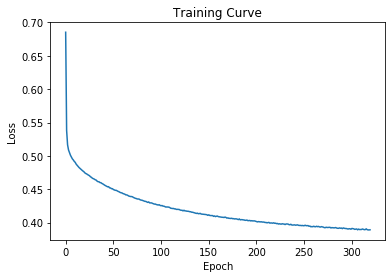

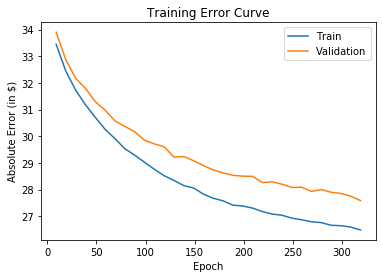

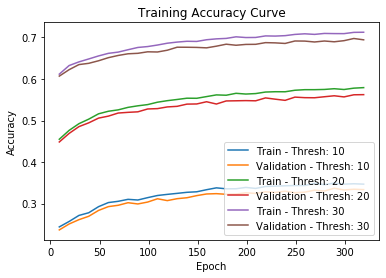

---[ITER 10] loss: 0.387790  time: 0.307
---[ITER 20] loss: 0.384986  time: 0.142
---[ITER 30] loss: 0.388614  time: 0.132
---[ITER 40] loss: 0.386130  time: 0.138
---[ITER 50] loss: 0.391376  time: 0.136
---[ITER 60] loss: 0.387781  time: 0.150
---[ITER 70] loss: 0.387875  time: 0.135
---[ITER 80] loss: 0.385932  time: 0.134
---[ITER 90] loss: 0.394427  time: 0.134
---[ITER 100] loss: 0.387005  time: 0.137
---[ITER 110] loss: 0.384818  time: 0.144
---[ITER 120] loss: 0.388195  time: 0.131
---[ITER 130] loss: 0.397470  time: 0.170
---[ITER 140] loss: 0.392912  time: 0.148
---[ITER 150] loss: 0.390116  time: 0.146
---[ITER 160] loss: 0.386969  time: 0.140
[EPOCH 321] loss: 0.389237  time: 2.545
---[ITER 10] loss: 0.386414  time: 0.306
---[ITER 20] loss: 0.394595  time: 0.136
---[ITER 30] loss: 0.396643  time: 0.137
---[ITER 40] loss: 0.389420  time: 0.137
---[ITER 50] loss: 0.388872  time: 0.138
---[ITER 60] loss: 0.389615  time: 0.132
---[ITER 70] loss: 0.386640  time: 0.137
---[ITER 8

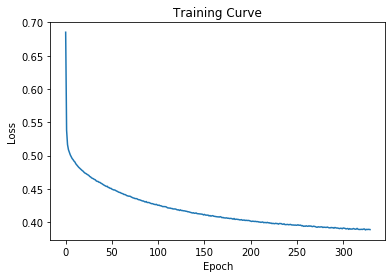

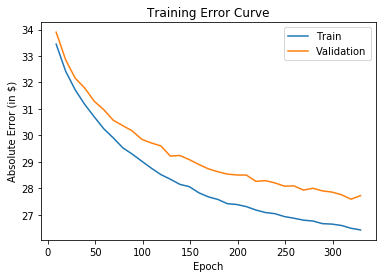

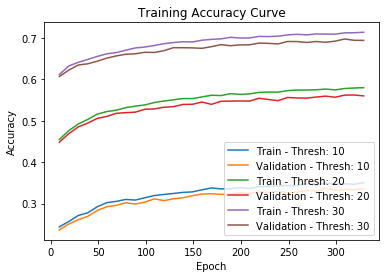

---[ITER 10] loss: 0.390672  time: 0.307
---[ITER 20] loss: 0.395328  time: 0.134
---[ITER 30] loss: 0.392764  time: 0.147
---[ITER 40] loss: 0.391836  time: 0.138
---[ITER 50] loss: 0.394249  time: 0.152
---[ITER 60] loss: 0.392171  time: 0.132
---[ITER 70] loss: 0.387720  time: 0.138
---[ITER 80] loss: 0.390405  time: 0.134
---[ITER 90] loss: 0.384315  time: 0.137
---[ITER 100] loss: 0.385519  time: 0.135
---[ITER 110] loss: 0.381037  time: 0.137
---[ITER 120] loss: 0.378537  time: 0.178
---[ITER 130] loss: 0.386993  time: 0.140
---[ITER 140] loss: 0.384552  time: 0.137
---[ITER 150] loss: 0.388224  time: 0.138
---[ITER 160] loss: 0.390670  time: 0.149
[EPOCH 331] loss: 0.388547  time: 2.561
---[ITER 10] loss: 0.394524  time: 0.308
---[ITER 20] loss: 0.391640  time: 0.134
---[ITER 30] loss: 0.381381  time: 0.140
---[ITER 40] loss: 0.394150  time: 0.139
---[ITER 50] loss: 0.391466  time: 0.140
---[ITER 60] loss: 0.388614  time: 0.134
---[ITER 70] loss: 0.388259  time: 0.135
---[ITER 8

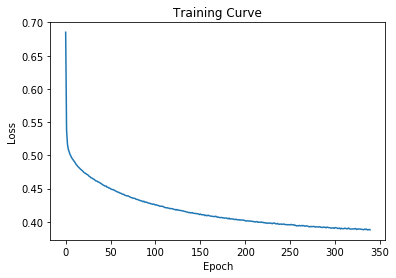

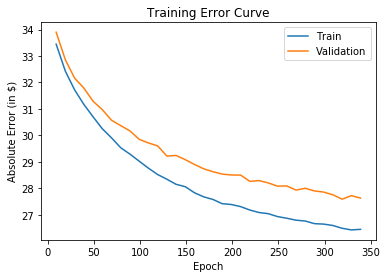

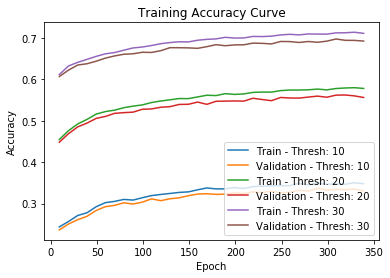

---[ITER 10] loss: 0.386666  time: 0.208
---[ITER 20] loss: 0.385029  time: 0.165
---[ITER 30] loss: 0.387361  time: 0.222
---[ITER 40] loss: 0.387830  time: 0.135
---[ITER 50] loss: 0.386419  time: 0.144
---[ITER 60] loss: 0.391340  time: 0.144
---[ITER 70] loss: 0.382240  time: 0.134
---[ITER 80] loss: 0.395593  time: 0.151
---[ITER 90] loss: 0.385023  time: 0.134
---[ITER 100] loss: 0.396459  time: 0.136
---[ITER 110] loss: 0.388823  time: 0.140
---[ITER 120] loss: 0.389724  time: 0.136
---[ITER 130] loss: 0.385855  time: 0.136
---[ITER 140] loss: 0.387221  time: 0.169
---[ITER 150] loss: 0.385487  time: 0.139
---[ITER 160] loss: 0.387605  time: 0.158
[EPOCH 341] loss: 0.388049  time: 2.567
---[ITER 10] loss: 0.386904  time: 0.198
---[ITER 20] loss: 0.400354  time: 0.140
---[ITER 30] loss: 0.383409  time: 0.232
---[ITER 40] loss: 0.382701  time: 0.135
---[ITER 50] loss: 0.387613  time: 0.139
---[ITER 60] loss: 0.388935  time: 0.136
---[ITER 70] loss: 0.392003  time: 0.149
---[ITER 8

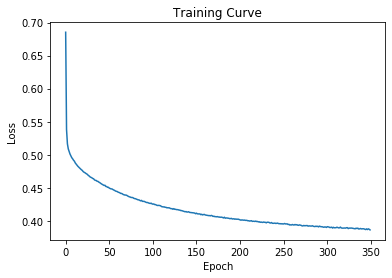

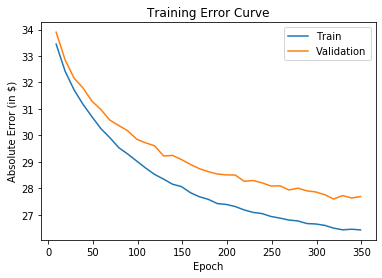

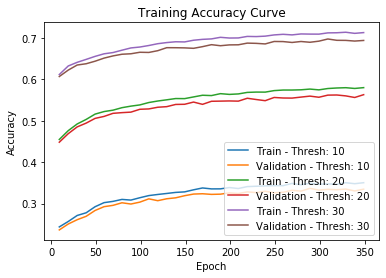

---[ITER 10] loss: 0.390238  time: 0.188
---[ITER 20] loss: 0.395485  time: 0.242
---[ITER 30] loss: 0.393803  time: 0.136
---[ITER 40] loss: 0.379518  time: 0.135
---[ITER 50] loss: 0.387646  time: 0.184
---[ITER 60] loss: 0.378543  time: 0.137
---[ITER 70] loss: 0.379474  time: 0.132
---[ITER 80] loss: 0.384326  time: 0.138
---[ITER 90] loss: 0.395543  time: 0.148
---[ITER 100] loss: 0.381703  time: 0.141
---[ITER 110] loss: 0.388952  time: 0.151
---[ITER 120] loss: 0.386297  time: 0.127
---[ITER 130] loss: 0.382269  time: 0.170
---[ITER 140] loss: 0.394843  time: 0.135
---[ITER 150] loss: 0.392388  time: 0.152
---[ITER 160] loss: 0.390086  time: 0.122
[EPOCH 351] loss: 0.387576  time: 2.557
---[ITER 10] loss: 0.386649  time: 0.198
---[ITER 20] loss: 0.386218  time: 0.238
---[ITER 30] loss: 0.389548  time: 0.134
---[ITER 40] loss: 0.400598  time: 0.135
---[ITER 50] loss: 0.378748  time: 0.146
---[ITER 60] loss: 0.384493  time: 0.148
---[ITER 70] loss: 0.395197  time: 0.135
---[ITER 8

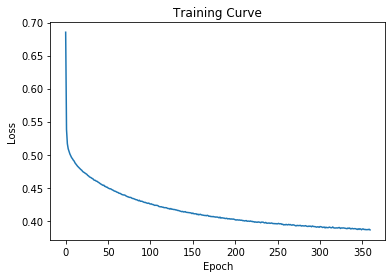

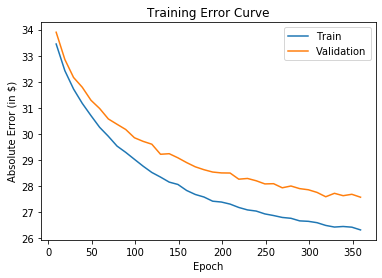

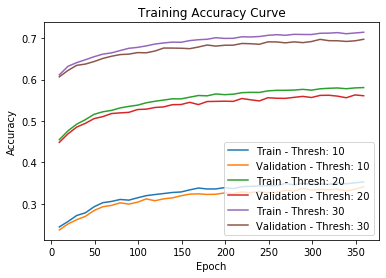

---[ITER 10] loss: 0.388331  time: 0.302
---[ITER 20] loss: 0.381516  time: 0.137
---[ITER 30] loss: 0.384669  time: 0.140
---[ITER 40] loss: 0.385848  time: 0.135
---[ITER 50] loss: 0.388185  time: 0.139
---[ITER 60] loss: 0.383199  time: 0.139
---[ITER 70] loss: 0.384471  time: 0.134
---[ITER 80] loss: 0.389560  time: 0.144
---[ITER 90] loss: 0.387392  time: 0.131
---[ITER 100] loss: 0.381301  time: 0.136
---[ITER 110] loss: 0.385692  time: 0.133
---[ITER 120] loss: 0.384322  time: 0.151
---[ITER 130] loss: 0.386284  time: 0.184
---[ITER 140] loss: 0.382817  time: 0.137
---[ITER 150] loss: 0.387712  time: 0.134
---[ITER 160] loss: 0.394188  time: 0.134
[EPOCH 361] loss: 0.386204  time: 2.537
---[ITER 10] loss: 0.389443  time: 0.318
---[ITER 20] loss: 0.382199  time: 0.127
---[ITER 30] loss: 0.383104  time: 0.138
---[ITER 40] loss: 0.388850  time: 0.133
---[ITER 50] loss: 0.401013  time: 0.147
---[ITER 60] loss: 0.385461  time: 0.134
---[ITER 70] loss: 0.385319  time: 0.135
---[ITER 8

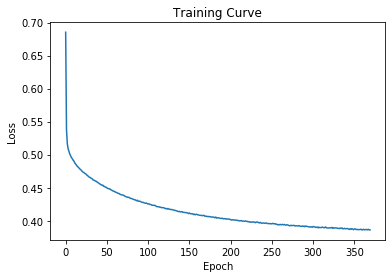

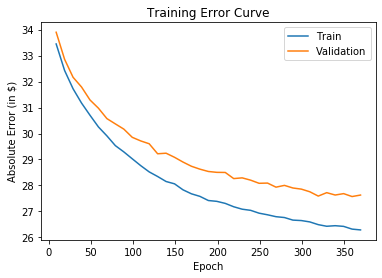

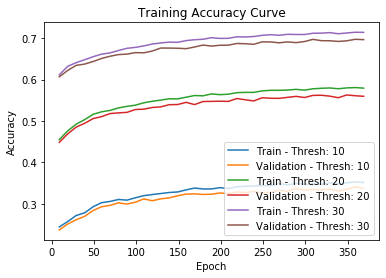

---[ITER 10] loss: 0.390020  time: 0.209
---[ITER 20] loss: 0.383528  time: 0.146
---[ITER 30] loss: 0.387585  time: 0.130
---[ITER 40] loss: 0.380146  time: 0.230
---[ITER 50] loss: 0.390298  time: 0.143
---[ITER 60] loss: 0.390164  time: 0.146
---[ITER 70] loss: 0.387301  time: 0.135
---[ITER 80] loss: 0.387866  time: 0.146
---[ITER 90] loss: 0.389763  time: 0.135
---[ITER 100] loss: 0.383336  time: 0.138
---[ITER 110] loss: 0.380234  time: 0.139
---[ITER 120] loss: 0.386148  time: 0.140
---[ITER 130] loss: 0.387924  time: 0.135
---[ITER 140] loss: 0.388803  time: 0.154
---[ITER 150] loss: 0.381623  time: 0.193
---[ITER 160] loss: 0.386788  time: 0.133
[EPOCH 371] loss: 0.386283  time: 2.573
---[ITER 10] loss: 0.383833  time: 0.203
---[ITER 20] loss: 0.384242  time: 0.145
---[ITER 30] loss: 0.393299  time: 0.138
---[ITER 40] loss: 0.388566  time: 0.237
---[ITER 50] loss: 0.389214  time: 0.123
---[ITER 60] loss: 0.389966  time: 0.132
---[ITER 70] loss: 0.387629  time: 0.146
---[ITER 8

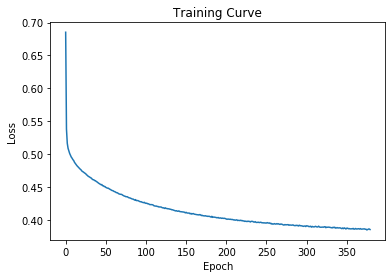

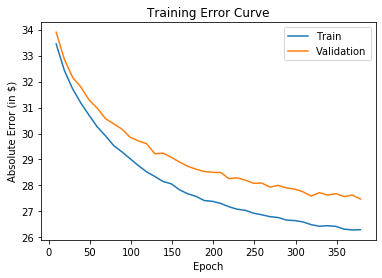

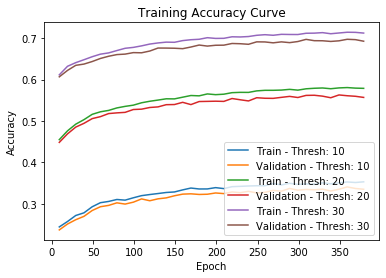

---[ITER 10] loss: 0.380750  time: 0.192
---[ITER 20] loss: 0.386430  time: 0.147
---[ITER 30] loss: 0.391657  time: 0.230
---[ITER 40] loss: 0.380861  time: 0.136
---[ITER 50] loss: 0.381012  time: 0.136
---[ITER 60] loss: 0.387545  time: 0.139
---[ITER 70] loss: 0.381166  time: 0.146
---[ITER 80] loss: 0.378863  time: 0.131
---[ITER 90] loss: 0.387113  time: 0.142
---[ITER 100] loss: 0.389889  time: 0.133
---[ITER 110] loss: 0.379636  time: 0.139
---[ITER 120] loss: 0.391849  time: 0.143
---[ITER 130] loss: 0.379877  time: 0.140
---[ITER 140] loss: 0.384698  time: 0.172
---[ITER 150] loss: 0.383277  time: 0.143
---[ITER 160] loss: 0.398596  time: 0.139
[EPOCH 381] loss: 0.385442  time: 2.530
---[ITER 10] loss: 0.386170  time: 0.201
---[ITER 20] loss: 0.395486  time: 0.139
---[ITER 30] loss: 0.387868  time: 0.229
---[ITER 40] loss: 0.384258  time: 0.160
---[ITER 50] loss: 0.373871  time: 0.183
---[ITER 60] loss: 0.389899  time: 0.134
---[ITER 70] loss: 0.381709  time: 0.131
---[ITER 8

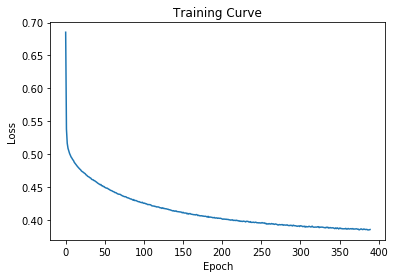

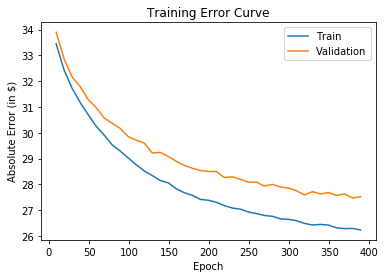

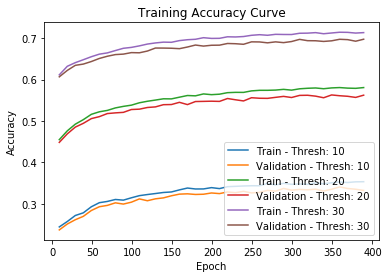

---[ITER 10] loss: 0.382527  time: 0.201
---[ITER 20] loss: 0.389105  time: 0.242
---[ITER 30] loss: 0.392379  time: 0.139
---[ITER 40] loss: 0.387653  time: 0.162
---[ITER 50] loss: 0.382410  time: 0.127
---[ITER 60] loss: 0.384509  time: 0.138
---[ITER 70] loss: 0.374454  time: 0.139
---[ITER 80] loss: 0.390606  time: 0.133
---[ITER 90] loss: 0.389556  time: 0.139
---[ITER 100] loss: 0.385582  time: 0.137
---[ITER 110] loss: 0.376811  time: 0.138
---[ITER 120] loss: 0.387054  time: 0.131
---[ITER 130] loss: 0.385790  time: 0.169
---[ITER 140] loss: 0.383548  time: 0.151
---[ITER 150] loss: 0.378745  time: 0.140
---[ITER 160] loss: 0.390814  time: 0.129
[EPOCH 391] loss: 0.385610  time: 2.536
---[ITER 10] loss: 0.390084  time: 0.199
---[ITER 20] loss: 0.384186  time: 0.239
---[ITER 30] loss: 0.381461  time: 0.135
---[ITER 40] loss: 0.380441  time: 0.134
---[ITER 50] loss: 0.386984  time: 0.126
---[ITER 60] loss: 0.383473  time: 0.139
---[ITER 70] loss: 0.382895  time: 0.150
---[ITER 8

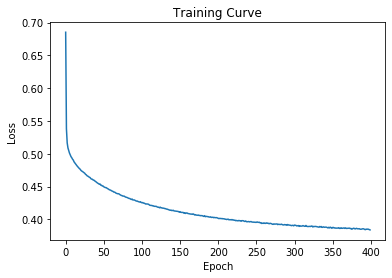

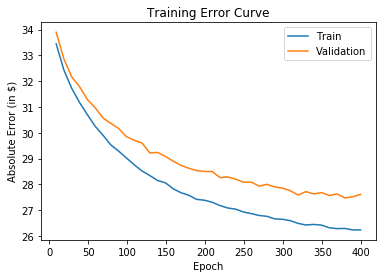

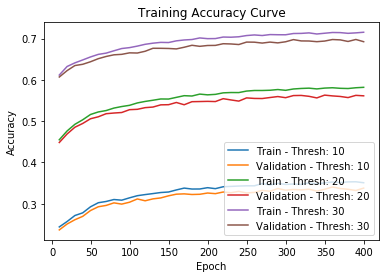

---[ITER 10] loss: 0.382473  time: 0.305
---[ITER 20] loss: 0.380211  time: 0.141
---[ITER 30] loss: 0.385868  time: 0.132
---[ITER 40] loss: 0.396091  time: 0.138
---[ITER 50] loss: 0.378164  time: 0.142
---[ITER 60] loss: 0.390427  time: 0.131
---[ITER 70] loss: 0.385634  time: 0.136
---[ITER 80] loss: 0.380870  time: 0.135
---[ITER 90] loss: 0.382208  time: 0.137
---[ITER 100] loss: 0.383539  time: 0.169
---[ITER 110] loss: 0.384201  time: 0.160
---[ITER 120] loss: 0.384842  time: 0.198
---[ITER 130] loss: 0.387667  time: 0.130
---[ITER 140] loss: 0.389028  time: 0.138
---[ITER 150] loss: 0.385316  time: 0.140
---[ITER 160] loss: 0.387254  time: 0.131
[EPOCH 401] loss: 0.385048  time: 2.590
---[ITER 10] loss: 0.381400  time: 0.312
---[ITER 20] loss: 0.382670  time: 0.135
---[ITER 30] loss: 0.386034  time: 0.138
---[ITER 40] loss: 0.388553  time: 0.135
---[ITER 50] loss: 0.385389  time: 0.140
---[ITER 60] loss: 0.376889  time: 0.146
---[ITER 70] loss: 0.382597  time: 0.131
---[ITER 8

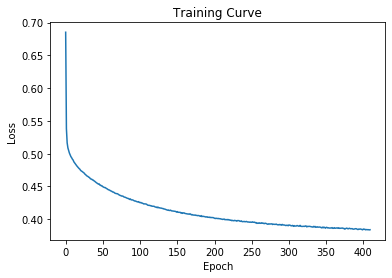

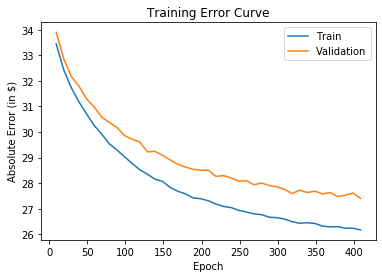

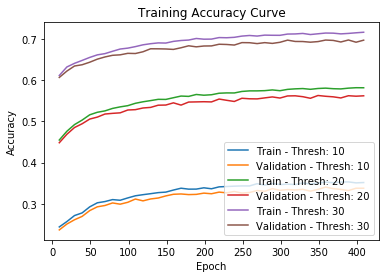

---[ITER 10] loss: 0.382250  time: 0.186
---[ITER 20] loss: 0.384311  time: 0.135
---[ITER 30] loss: 0.387513  time: 0.226
---[ITER 40] loss: 0.382066  time: 0.131
---[ITER 50] loss: 0.389398  time: 0.144
---[ITER 60] loss: 0.386289  time: 0.136
---[ITER 70] loss: 0.389822  time: 0.131
---[ITER 80] loss: 0.387594  time: 0.135
---[ITER 90] loss: 0.389554  time: 0.147
---[ITER 100] loss: 0.380000  time: 0.144
---[ITER 110] loss: 0.381890  time: 0.138
---[ITER 120] loss: 0.378545  time: 0.136
---[ITER 130] loss: 0.377675  time: 0.136
---[ITER 140] loss: 0.382878  time: 0.140
---[ITER 150] loss: 0.386818  time: 0.168
---[ITER 160] loss: 0.382185  time: 0.136
[EPOCH 411] loss: 0.384012  time: 2.493
---[ITER 10] loss: 0.378326  time: 0.201
---[ITER 20] loss: 0.380880  time: 0.135
---[ITER 30] loss: 0.388457  time: 0.224
---[ITER 40] loss: 0.378431  time: 0.138
---[ITER 50] loss: 0.389663  time: 0.131
---[ITER 60] loss: 0.376761  time: 0.135
---[ITER 70] loss: 0.381521  time: 0.147
---[ITER 8

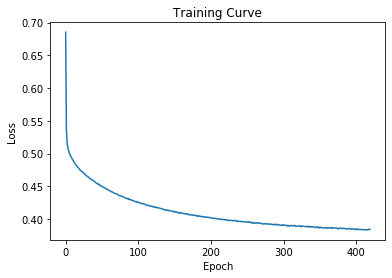

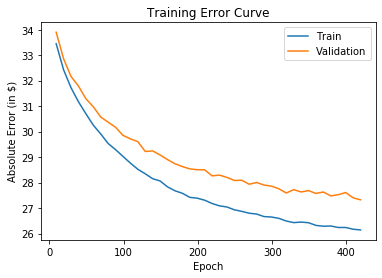

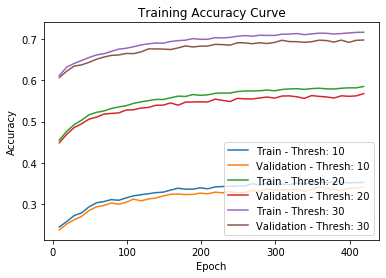

---[ITER 10] loss: 0.381956  time: 0.187
---[ITER 20] loss: 0.383518  time: 0.247
---[ITER 30] loss: 0.385051  time: 0.129
---[ITER 40] loss: 0.383020  time: 0.140
---[ITER 50] loss: 0.387266  time: 0.176
---[ITER 60] loss: 0.379717  time: 0.130
---[ITER 70] loss: 0.386411  time: 0.133
---[ITER 80] loss: 0.385452  time: 0.139
---[ITER 90] loss: 0.385126  time: 0.134
---[ITER 100] loss: 0.385026  time: 0.145
---[ITER 110] loss: 0.383449  time: 0.127
---[ITER 120] loss: 0.379087  time: 0.140
---[ITER 130] loss: 0.377147  time: 0.149
---[ITER 140] loss: 0.386864  time: 0.160
---[ITER 150] loss: 0.386800  time: 0.138
---[ITER 160] loss: 0.380021  time: 0.141
[EPOCH 421] loss: 0.383295  time: 2.535
---[ITER 10] loss: 0.382545  time: 0.193
---[ITER 20] loss: 0.387008  time: 0.238
---[ITER 30] loss: 0.385938  time: 0.136
---[ITER 40] loss: 0.391135  time: 0.139
---[ITER 50] loss: 0.376221  time: 0.135
---[ITER 60] loss: 0.383000  time: 0.136
---[ITER 70] loss: 0.380003  time: 0.141
---[ITER 8

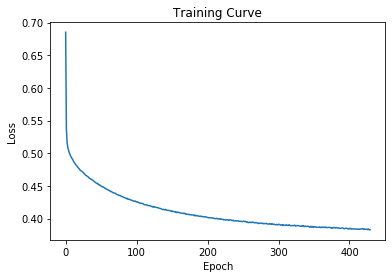

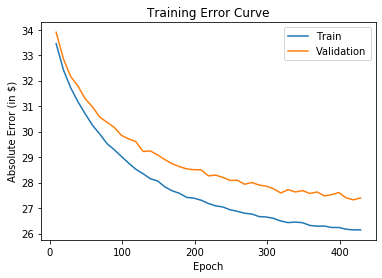

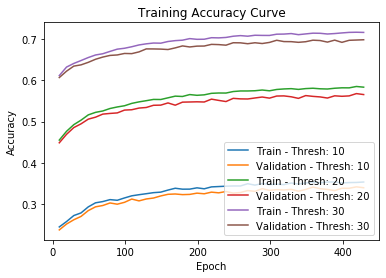

---[ITER 10] loss: 0.378851  time: 0.296
---[ITER 20] loss: 0.384316  time: 0.138
---[ITER 30] loss: 0.388953  time: 0.138
---[ITER 40] loss: 0.380982  time: 0.136
---[ITER 50] loss: 0.381715  time: 0.152
---[ITER 60] loss: 0.386767  time: 0.127
---[ITER 70] loss: 0.388174  time: 0.146
---[ITER 80] loss: 0.382579  time: 0.136
---[ITER 90] loss: 0.385487  time: 0.136
---[ITER 100] loss: 0.386847  time: 0.189
---[ITER 110] loss: 0.379217  time: 0.142
---[ITER 120] loss: 0.383739  time: 0.132
---[ITER 130] loss: 0.382115  time: 0.175
---[ITER 140] loss: 0.384124  time: 0.135
---[ITER 150] loss: 0.378971  time: 0.135
---[ITER 160] loss: 0.384870  time: 0.140
[EPOCH 431] loss: 0.383721  time: 2.577
---[ITER 10] loss: 0.385537  time: 0.307
---[ITER 20] loss: 0.376909  time: 0.144
---[ITER 30] loss: 0.387105  time: 0.134
---[ITER 40] loss: 0.381432  time: 0.139
---[ITER 50] loss: 0.380905  time: 0.132
---[ITER 60] loss: 0.392130  time: 0.140
---[ITER 70] loss: 0.388109  time: 0.140
---[ITER 8

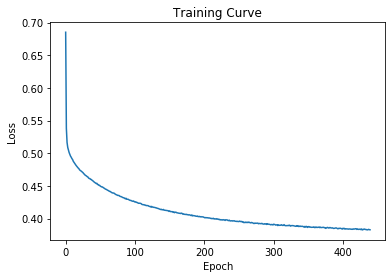

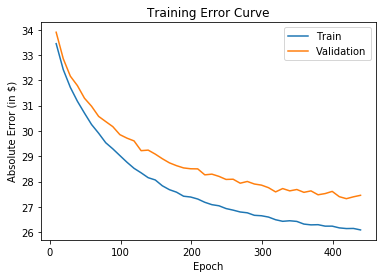

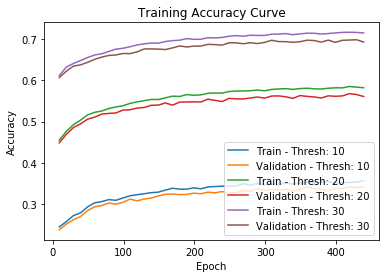

---[ITER 10] loss: 0.381475  time: 0.292
---[ITER 20] loss: 0.380762  time: 0.134
---[ITER 30] loss: 0.383475  time: 0.156
---[ITER 40] loss: 0.380701  time: 0.127
---[ITER 50] loss: 0.382770  time: 0.138
---[ITER 60] loss: 0.386962  time: 0.135
---[ITER 70] loss: 0.388270  time: 0.139
---[ITER 80] loss: 0.382980  time: 0.164
---[ITER 90] loss: 0.387032  time: 0.123
---[ITER 100] loss: 0.381836  time: 0.141
---[ITER 110] loss: 0.377381  time: 0.135
---[ITER 120] loss: 0.376239  time: 0.170
---[ITER 130] loss: 0.377188  time: 0.144
---[ITER 140] loss: 0.384005  time: 0.138
---[ITER 150] loss: 0.386391  time: 0.135
---[ITER 160] loss: 0.386620  time: 0.172
[EPOCH 441] loss: 0.382558  time: 2.567
---[ITER 10] loss: 0.376536  time: 0.308
---[ITER 20] loss: 0.392363  time: 0.137
---[ITER 30] loss: 0.380900  time: 0.137
---[ITER 40] loss: 0.383596  time: 0.132
---[ITER 50] loss: 0.380913  time: 0.139
---[ITER 60] loss: 0.383460  time: 0.136
---[ITER 70] loss: 0.384047  time: 0.132
---[ITER 8

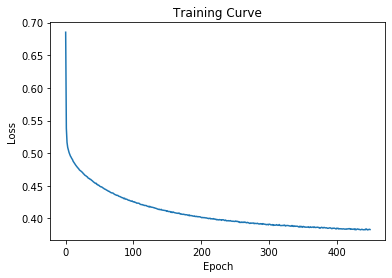

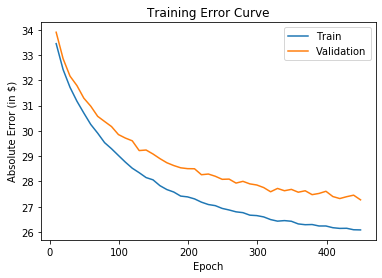

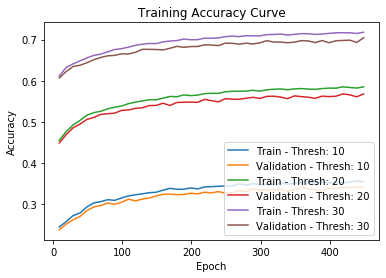

---[ITER 10] loss: 0.386668  time: 0.277
---[ITER 20] loss: 0.374906  time: 0.178
---[ITER 30] loss: 0.378763  time: 0.304
---[ITER 40] loss: 0.387873  time: 0.190
---[ITER 50] loss: 0.378534  time: 0.197
---[ITER 60] loss: 0.390812  time: 0.193
---[ITER 70] loss: 0.385838  time: 0.129
---[ITER 80] loss: 0.383419  time: 0.138
---[ITER 90] loss: 0.384908  time: 0.144
---[ITER 100] loss: 0.381119  time: 0.139
---[ITER 110] loss: 0.376673  time: 0.141
---[ITER 120] loss: 0.390846  time: 0.139
---[ITER 130] loss: 0.384216  time: 0.145
---[ITER 140] loss: 0.378297  time: 0.179
---[ITER 150] loss: 0.376599  time: 0.142
---[ITER 160] loss: 0.386551  time: 0.207
[EPOCH 451] loss: 0.382785  time: 2.960
---[ITER 10] loss: 0.375407  time: 0.204
---[ITER 20] loss: 0.383045  time: 0.146
---[ITER 30] loss: 0.386063  time: 0.225
---[ITER 40] loss: 0.382811  time: 0.139
---[ITER 50] loss: 0.384400  time: 0.137
---[ITER 60] loss: 0.388433  time: 0.135
---[ITER 70] loss: 0.378233  time: 0.147
---[ITER 8

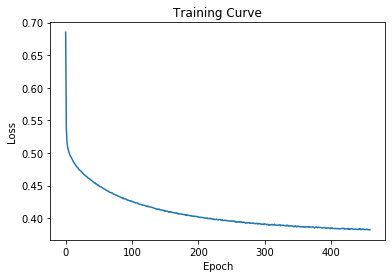

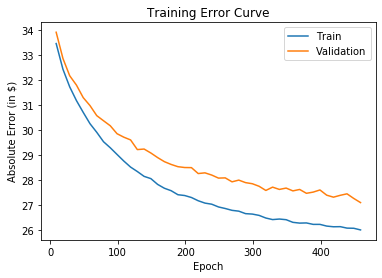

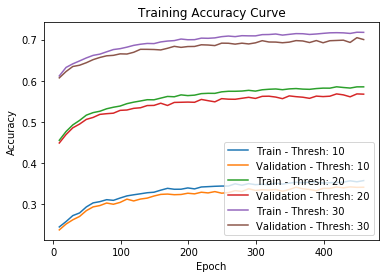

---[ITER 10] loss: 0.381412  time: 0.197
---[ITER 20] loss: 0.375982  time: 0.235
---[ITER 30] loss: 0.384755  time: 0.153
---[ITER 40] loss: 0.382886  time: 0.128
---[ITER 50] loss: 0.382392  time: 0.312
---[ITER 60] loss: 0.378712  time: 0.127
---[ITER 70] loss: 0.387028  time: 0.137
---[ITER 80] loss: 0.385929  time: 0.159
---[ITER 90] loss: 0.392746  time: 0.125
---[ITER 100] loss: 0.384728  time: 0.152
---[ITER 110] loss: 0.384283  time: 0.127
---[ITER 120] loss: 0.381383  time: 0.136
---[ITER 130] loss: 0.378293  time: 0.174
---[ITER 140] loss: 0.386013  time: 0.139
---[ITER 150] loss: 0.385113  time: 0.135
---[ITER 160] loss: 0.371499  time: 0.135
[EPOCH 461] loss: 0.382583  time: 2.694
---[ITER 10] loss: 0.379902  time: 0.200
---[ITER 20] loss: 0.391747  time: 0.246
---[ITER 30] loss: 0.377938  time: 0.144
---[ITER 40] loss: 0.375752  time: 0.130
---[ITER 50] loss: 0.381585  time: 0.169
---[ITER 60] loss: 0.382003  time: 0.135
---[ITER 70] loss: 0.386515  time: 0.139
---[ITER 8

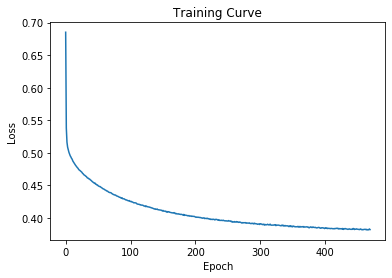

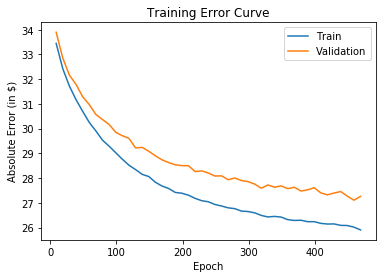

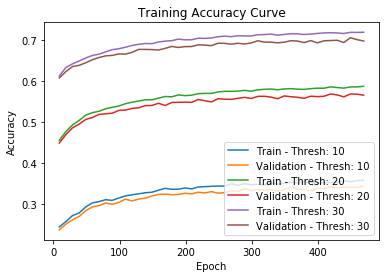

---[ITER 10] loss: 0.382587  time: 0.306
---[ITER 20] loss: 0.383634  time: 0.145
---[ITER 30] loss: 0.385326  time: 0.134
---[ITER 40] loss: 0.378769  time: 0.140
---[ITER 50] loss: 0.382287  time: 0.134
---[ITER 60] loss: 0.384441  time: 0.137
---[ITER 70] loss: 0.378608  time: 0.134
---[ITER 80] loss: 0.384516  time: 0.141
---[ITER 90] loss: 0.383932  time: 0.137
---[ITER 100] loss: 0.371992  time: 0.155
---[ITER 110] loss: 0.383103  time: 0.118
---[ITER 120] loss: 0.374660  time: 0.183
---[ITER 130] loss: 0.379411  time: 0.195
---[ITER 140] loss: 0.378915  time: 0.175
---[ITER 150] loss: 0.393708  time: 0.188
---[ITER 160] loss: 0.382915  time: 0.162
[EPOCH 471] loss: 0.381945  time: 2.704
---[ITER 10] loss: 0.390519  time: 0.348
---[ITER 20] loss: 0.381016  time: 0.191
---[ITER 30] loss: 0.378059  time: 0.183
---[ITER 40] loss: 0.388594  time: 0.125
---[ITER 50] loss: 0.383867  time: 0.136
---[ITER 60] loss: 0.385147  time: 0.138
---[ITER 70] loss: 0.378038  time: 0.138
---[ITER 8

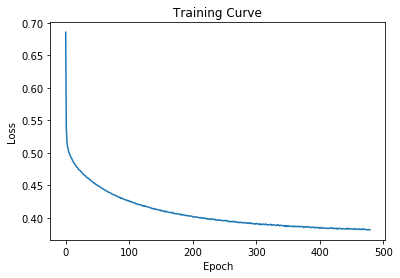

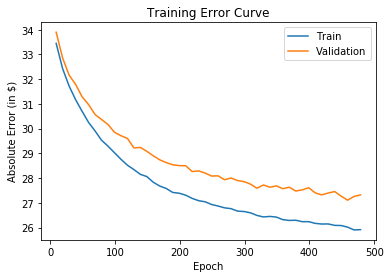

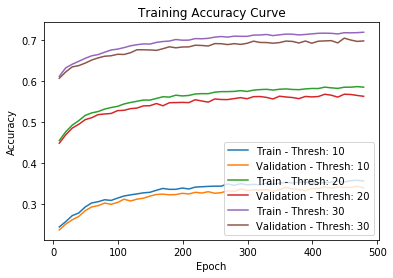

---[ITER 10] loss: 0.379141  time: 0.209
---[ITER 20] loss: 0.373464  time: 0.140
---[ITER 30] loss: 0.375261  time: 0.143
---[ITER 40] loss: 0.382117  time: 0.227
---[ITER 50] loss: 0.384604  time: 0.138
---[ITER 60] loss: 0.378260  time: 0.137
---[ITER 70] loss: 0.383770  time: 0.140
---[ITER 80] loss: 0.391146  time: 0.154
---[ITER 90] loss: 0.372968  time: 0.126
---[ITER 100] loss: 0.374248  time: 0.147
---[ITER 110] loss: 0.379479  time: 0.160
---[ITER 120] loss: 0.391117  time: 0.158
---[ITER 130] loss: 0.385306  time: 0.140
---[ITER 140] loss: 0.379133  time: 0.143
---[ITER 150] loss: 0.381875  time: 0.169
---[ITER 160] loss: 0.380803  time: 0.138
[EPOCH 481] loss: 0.380917  time: 2.587
---[ITER 10] loss: 0.387656  time: 0.204
---[ITER 20] loss: 0.385422  time: 0.145
---[ITER 30] loss: 0.374726  time: 0.268
---[ITER 40] loss: 0.380061  time: 0.204
---[ITER 50] loss: 0.379658  time: 0.132
---[ITER 60] loss: 0.381691  time: 0.141
---[ITER 70] loss: 0.389898  time: 0.189
---[ITER 8

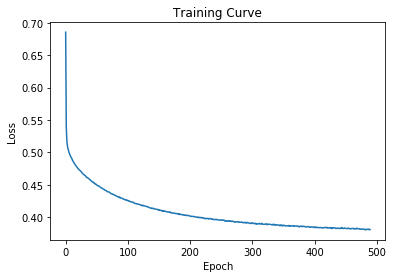

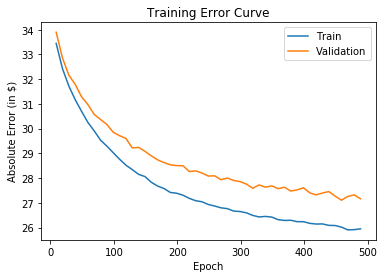

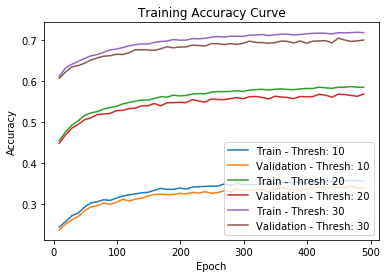

---[ITER 10] loss: 0.384024  time: 0.197
---[ITER 20] loss: 0.387867  time: 0.164
---[ITER 30] loss: 0.381290  time: 0.249
---[ITER 40] loss: 0.380802  time: 0.180
---[ITER 50] loss: 0.382462  time: 0.167
---[ITER 60] loss: 0.379993  time: 0.174
---[ITER 70] loss: 0.380723  time: 0.231
---[ITER 80] loss: 0.379123  time: 0.245
---[ITER 90] loss: 0.378224  time: 0.186
---[ITER 100] loss: 0.382442  time: 0.139
---[ITER 110] loss: 0.385416  time: 0.141
---[ITER 120] loss: 0.385544  time: 0.136
---[ITER 130] loss: 0.373895  time: 0.136
---[ITER 140] loss: 0.384016  time: 0.174
---[ITER 150] loss: 0.380210  time: 0.137
---[ITER 160] loss: 0.378462  time: 0.144
[EPOCH 491] loss: 0.381197  time: 2.922
---[ITER 10] loss: 0.382281  time: 0.206
---[ITER 20] loss: 0.384713  time: 0.133
---[ITER 30] loss: 0.381363  time: 0.239
---[ITER 40] loss: 0.373126  time: 0.139
---[ITER 50] loss: 0.383568  time: 0.146
---[ITER 60] loss: 0.381884  time: 0.141
---[ITER 70] loss: 0.378299  time: 0.146
---[ITER 8

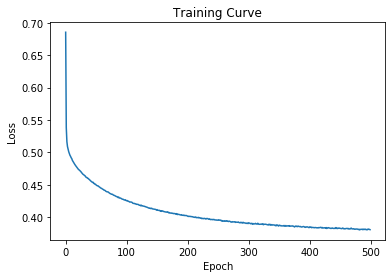

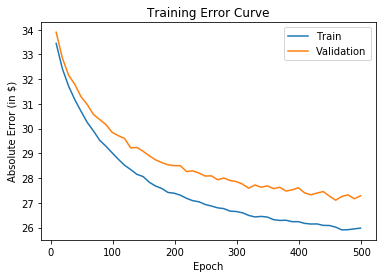

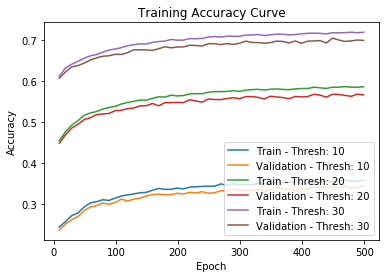

---[ITER 10] loss: 0.382106  time: 0.203
---[ITER 20] loss: 0.386618  time: 0.244
---[ITER 30] loss: 0.372378  time: 0.132
---[ITER 40] loss: 0.374269  time: 0.142
---[ITER 50] loss: 0.378636  time: 0.135
---[ITER 60] loss: 0.376489  time: 0.141
---[ITER 70] loss: 0.376126  time: 0.133
---[ITER 80] loss: 0.384932  time: 0.171
---[ITER 90] loss: 0.385362  time: 0.153
---[ITER 100] loss: 0.377022  time: 0.146
---[ITER 110] loss: 0.380337  time: 0.132
---[ITER 120] loss: 0.378091  time: 0.175
---[ITER 130] loss: 0.383685  time: 0.178
---[ITER 140] loss: 0.375031  time: 0.148
---[ITER 150] loss: 0.382213  time: 0.132
---[ITER 160] loss: 0.381345  time: 0.139
[EPOCH 501] loss: 0.380055  time: 2.626
---[ITER 10] loss: 0.372834  time: 0.199
---[ITER 20] loss: 0.382711  time: 0.239
---[ITER 30] loss: 0.378066  time: 0.134
---[ITER 40] loss: 0.378407  time: 0.144
---[ITER 50] loss: 0.380167  time: 0.133
---[ITER 60] loss: 0.387470  time: 0.143
---[ITER 70] loss: 0.381121  time: 0.136
---[ITER 8

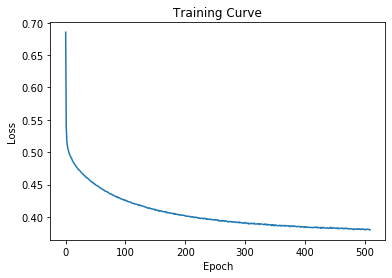

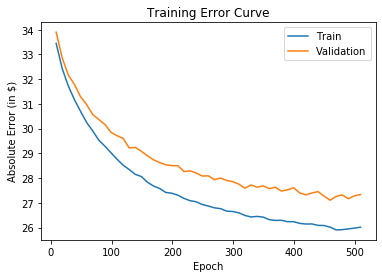

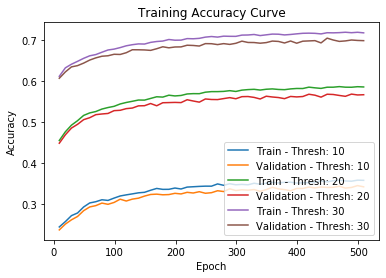

---[ITER 10] loss: 0.377679  time: 0.321
---[ITER 20] loss: 0.381269  time: 0.137
---[ITER 30] loss: 0.377373  time: 0.145
---[ITER 40] loss: 0.382631  time: 0.133
---[ITER 50] loss: 0.372129  time: 0.139
---[ITER 60] loss: 0.383412  time: 0.133
---[ITER 70] loss: 0.380995  time: 0.145
---[ITER 80] loss: 0.376073  time: 0.139
---[ITER 90] loss: 0.371390  time: 0.139
---[ITER 100] loss: 0.382528  time: 0.171
---[ITER 110] loss: 0.382286  time: 0.190
---[ITER 120] loss: 0.383216  time: 0.189
---[ITER 130] loss: 0.387979  time: 0.260
---[ITER 140] loss: 0.376247  time: 0.164
---[ITER 150] loss: 0.386628  time: 0.219
---[ITER 160] loss: 0.389020  time: 0.170
[EPOCH 511] loss: 0.380437  time: 2.937
---[ITER 10] loss: 0.381935  time: 0.319
---[ITER 20] loss: 0.377040  time: 0.132
---[ITER 30] loss: 0.374316  time: 0.138
---[ITER 40] loss: 0.377912  time: 0.143
---[ITER 50] loss: 0.382304  time: 0.135
---[ITER 60] loss: 0.373611  time: 0.141
---[ITER 70] loss: 0.385124  time: 0.137
---[ITER 8

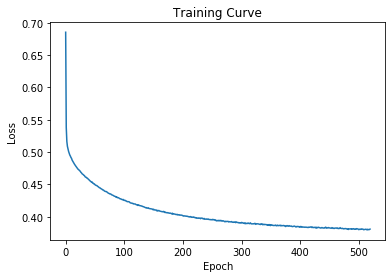

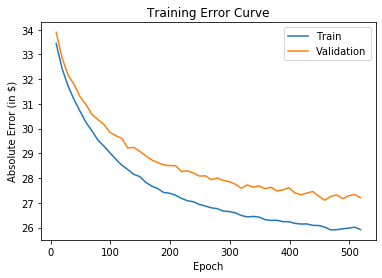

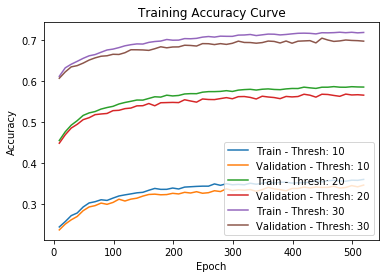

---[ITER 10] loss: 0.378967  time: 0.202
---[ITER 20] loss: 0.384297  time: 0.135
---[ITER 30] loss: 0.383184  time: 0.229
---[ITER 40] loss: 0.382510  time: 0.135
---[ITER 50] loss: 0.375902  time: 0.146
---[ITER 60] loss: 0.382161  time: 0.134
---[ITER 70] loss: 0.379428  time: 0.143
---[ITER 80] loss: 0.383313  time: 0.138
---[ITER 90] loss: 0.368380  time: 0.144
---[ITER 100] loss: 0.379920  time: 0.138
---[ITER 110] loss: 0.383967  time: 0.140
---[ITER 120] loss: 0.378618  time: 0.136
---[ITER 130] loss: 0.380675  time: 0.140
---[ITER 140] loss: 0.380718  time: 0.194
---[ITER 150] loss: 0.383536  time: 0.175
---[ITER 160] loss: 0.375283  time: 0.146
[EPOCH 521] loss: 0.380090  time: 2.599
---[ITER 10] loss: 0.383205  time: 0.200
---[ITER 20] loss: 0.380763  time: 0.143
---[ITER 30] loss: 0.371933  time: 0.230
---[ITER 40] loss: 0.386281  time: 0.139
---[ITER 50] loss: 0.378140  time: 0.141
---[ITER 60] loss: 0.379948  time: 0.141
---[ITER 70] loss: 0.382872  time: 0.143
---[ITER 8

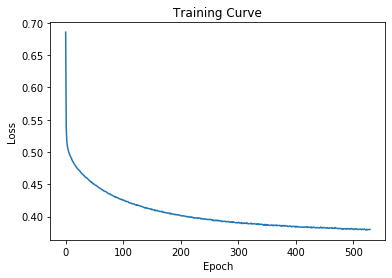

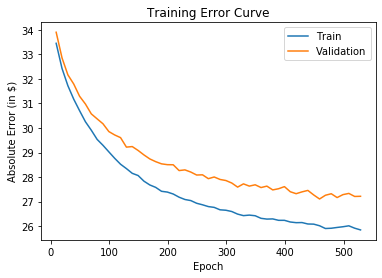

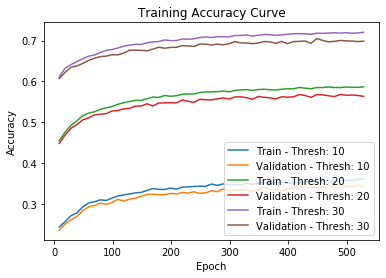

---[ITER 10] loss: 0.376943  time: 0.198
---[ITER 20] loss: 0.376318  time: 0.237
---[ITER 30] loss: 0.381717  time: 0.152
---[ITER 40] loss: 0.380565  time: 0.156
---[ITER 50] loss: 0.385120  time: 0.134
---[ITER 60] loss: 0.375143  time: 0.142
---[ITER 70] loss: 0.380072  time: 0.135
---[ITER 80] loss: 0.376779  time: 0.140
---[ITER 90] loss: 0.387961  time: 0.136
---[ITER 100] loss: 0.380840  time: 0.142
---[ITER 110] loss: 0.376175  time: 0.133
---[ITER 120] loss: 0.384352  time: 0.139
---[ITER 130] loss: 0.384462  time: 0.142
---[ITER 140] loss: 0.378941  time: 0.176
---[ITER 150] loss: 0.382071  time: 0.192
---[ITER 160] loss: 0.381005  time: 0.258
[EPOCH 531] loss: 0.380215  time: 2.757
---[ITER 10] loss: 0.376175  time: 0.261
---[ITER 20] loss: 0.373356  time: 0.258
---[ITER 30] loss: 0.380135  time: 0.190
---[ITER 40] loss: 0.377278  time: 0.171
---[ITER 50] loss: 0.390000  time: 0.160
---[ITER 60] loss: 0.378475  time: 0.209
---[ITER 70] loss: 0.382630  time: 0.124
---[ITER 8

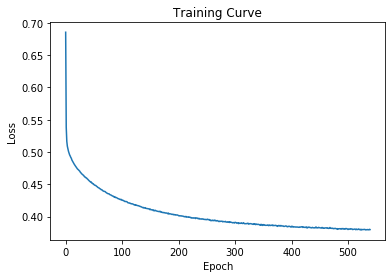

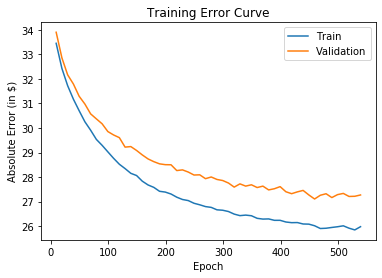

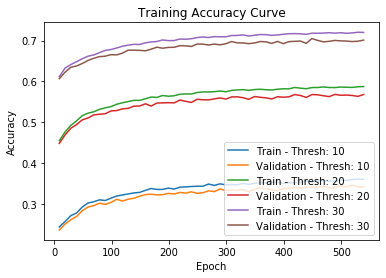

---[ITER 10] loss: 0.375481  time: 0.324
---[ITER 20] loss: 0.380442  time: 0.202
---[ITER 30] loss: 0.383482  time: 0.128
---[ITER 40] loss: 0.380329  time: 0.137
---[ITER 50] loss: 0.378507  time: 0.140
---[ITER 60] loss: 0.380527  time: 0.138
---[ITER 70] loss: 0.372985  time: 0.141
---[ITER 80] loss: 0.380971  time: 0.138
---[ITER 90] loss: 0.376707  time: 0.146
---[ITER 100] loss: 0.370182  time: 0.141
---[ITER 110] loss: 0.379395  time: 0.190
---[ITER 120] loss: 0.378530  time: 0.143
---[ITER 130] loss: 0.385165  time: 0.172
---[ITER 140] loss: 0.380440  time: 0.173
---[ITER 150] loss: 0.383270  time: 0.138
---[ITER 160] loss: 0.385678  time: 0.130
[EPOCH 541] loss: 0.379279  time: 2.712
---[ITER 10] loss: 0.384735  time: 0.314
---[ITER 20] loss: 0.371294  time: 0.132
---[ITER 30] loss: 0.379367  time: 0.146
---[ITER 40] loss: 0.374881  time: 0.141
---[ITER 50] loss: 0.381016  time: 0.142
---[ITER 60] loss: 0.384814  time: 0.134
---[ITER 70] loss: 0.376565  time: 0.149
---[ITER 8

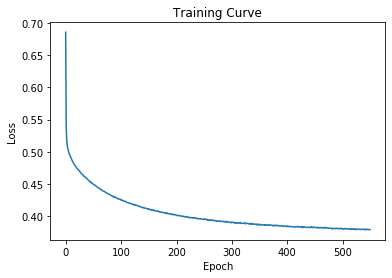

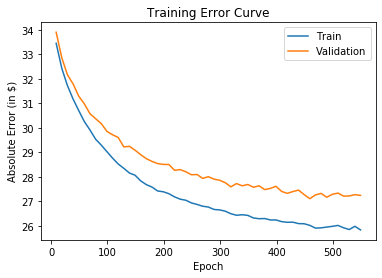

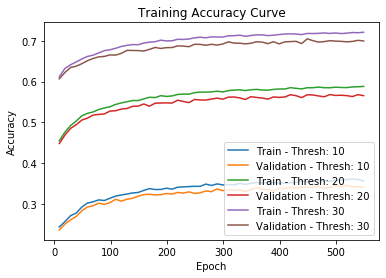

---[ITER 10] loss: 0.375397  time: 0.307
---[ITER 20] loss: 0.383446  time: 0.138
---[ITER 30] loss: 0.366773  time: 0.140
---[ITER 40] loss: 0.384281  time: 0.132
---[ITER 50] loss: 0.381212  time: 0.142
---[ITER 60] loss: 0.373100  time: 0.136
---[ITER 70] loss: 0.385276  time: 0.142
---[ITER 80] loss: 0.374940  time: 0.150
---[ITER 90] loss: 0.377166  time: 0.129
---[ITER 100] loss: 0.379766  time: 0.138
---[ITER 110] loss: 0.385928  time: 0.150
---[ITER 120] loss: 0.384225  time: 0.170
---[ITER 130] loss: 0.377701  time: 0.160
---[ITER 140] loss: 0.379450  time: 0.144
---[ITER 150] loss: 0.381103  time: 0.156
---[ITER 160] loss: 0.381978  time: 0.136
[EPOCH 551] loss: 0.379871  time: 2.599
---[ITER 10] loss: 0.378586  time: 0.350
---[ITER 20] loss: 0.385954  time: 0.163
---[ITER 30] loss: 0.376651  time: 0.175
---[ITER 40] loss: 0.384493  time: 0.164
---[ITER 50] loss: 0.378600  time: 0.181
---[ITER 60] loss: 0.388865  time: 0.176
---[ITER 70] loss: 0.373941  time: 0.175
---[ITER 8

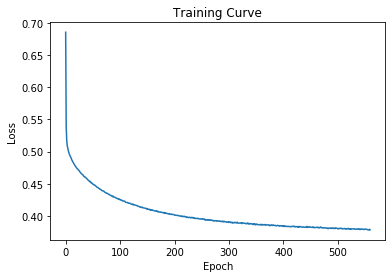

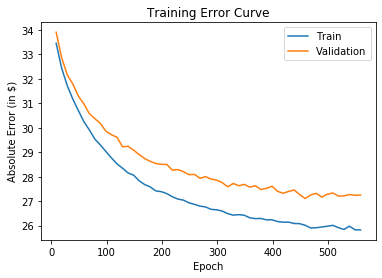

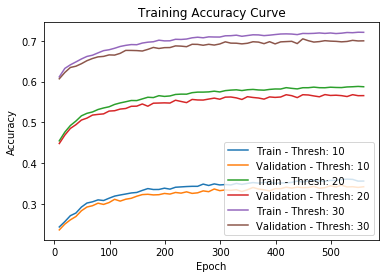

---[ITER 10] loss: 0.380912  time: 0.201
---[ITER 20] loss: 0.378185  time: 0.135
---[ITER 30] loss: 0.383335  time: 0.244
---[ITER 40] loss: 0.377913  time: 0.131
---[ITER 50] loss: 0.380647  time: 0.141
---[ITER 60] loss: 0.381207  time: 0.136
---[ITER 70] loss: 0.370328  time: 0.143
---[ITER 80] loss: 0.374741  time: 0.135
---[ITER 90] loss: 0.375036  time: 0.144
---[ITER 100] loss: 0.383622  time: 0.136
---[ITER 110] loss: 0.390583  time: 0.172
---[ITER 120] loss: 0.370011  time: 0.138
---[ITER 130] loss: 0.383194  time: 0.146
---[ITER 140] loss: 0.389492  time: 0.176
---[ITER 150] loss: 0.375966  time: 0.149
---[ITER 160] loss: 0.380324  time: 0.136
[EPOCH 561] loss: 0.379398  time: 2.589
---[ITER 10] loss: 0.374760  time: 0.200
---[ITER 20] loss: 0.382116  time: 0.148
---[ITER 30] loss: 0.380152  time: 0.221
---[ITER 40] loss: 0.376472  time: 0.142
---[ITER 50] loss: 0.388098  time: 0.141
---[ITER 60] loss: 0.379591  time: 0.134
---[ITER 70] loss: 0.380628  time: 0.152
---[ITER 8

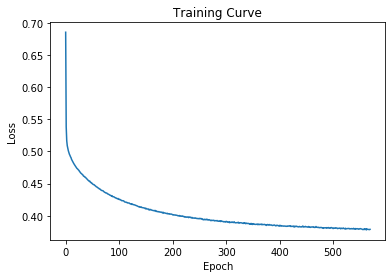

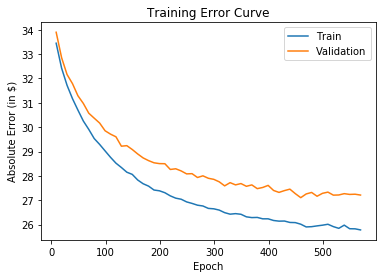

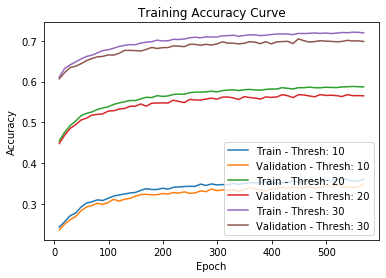

---[ITER 10] loss: 0.383916  time: 0.201
---[ITER 20] loss: 0.378634  time: 0.271
---[ITER 30] loss: 0.379370  time: 0.126
---[ITER 40] loss: 0.379169  time: 0.142
---[ITER 50] loss: 0.381483  time: 0.131
---[ITER 60] loss: 0.377575  time: 0.141
---[ITER 70] loss: 0.384083  time: 0.138
---[ITER 80] loss: 0.382043  time: 0.143
---[ITER 90] loss: 0.381852  time: 0.136
---[ITER 100] loss: 0.386159  time: 0.145
---[ITER 110] loss: 0.376130  time: 0.144
---[ITER 120] loss: 0.371143  time: 0.140
---[ITER 130] loss: 0.375905  time: 0.178
---[ITER 140] loss: 0.374545  time: 0.164
---[ITER 150] loss: 0.375692  time: 0.142
---[ITER 160] loss: 0.380224  time: 0.141
[EPOCH 571] loss: 0.379513  time: 2.639
---[ITER 10] loss: 0.382829  time: 0.203
---[ITER 20] loss: 0.372457  time: 0.237
---[ITER 30] loss: 0.379531  time: 0.142
---[ITER 40] loss: 0.375881  time: 0.143
---[ITER 50] loss: 0.380286  time: 0.138
---[ITER 60] loss: 0.373560  time: 0.200
---[ITER 70] loss: 0.373982  time: 0.155
---[ITER 8

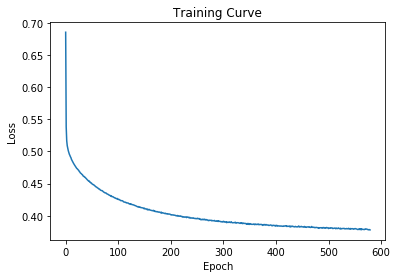

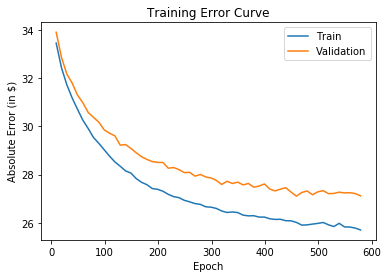

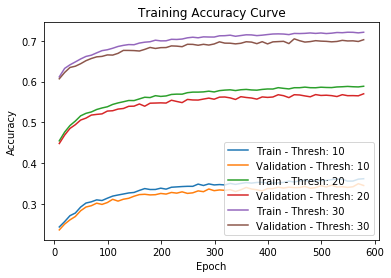

---[ITER 10] loss: 0.386795  time: 0.324
---[ITER 20] loss: 0.376152  time: 0.132
---[ITER 30] loss: 0.378169  time: 0.139
---[ITER 40] loss: 0.379404  time: 0.142
---[ITER 50] loss: 0.383361  time: 0.139
---[ITER 60] loss: 0.377922  time: 0.131
---[ITER 70] loss: 0.380211  time: 0.144
---[ITER 80] loss: 0.375591  time: 0.136
---[ITER 90] loss: 0.374410  time: 0.141
---[ITER 100] loss: 0.385588  time: 0.157
---[ITER 110] loss: 0.383240  time: 0.144
---[ITER 120] loss: 0.373476  time: 0.137
---[ITER 130] loss: 0.372818  time: 0.173
---[ITER 140] loss: 0.379784  time: 0.179
---[ITER 150] loss: 0.380536  time: 0.135
---[ITER 160] loss: 0.373152  time: 0.132
[EPOCH 581] loss: 0.379170  time: 2.611
---[ITER 10] loss: 0.378164  time: 0.308
---[ITER 20] loss: 0.375299  time: 0.148
---[ITER 30] loss: 0.381859  time: 0.135
---[ITER 40] loss: 0.374225  time: 0.139
---[ITER 50] loss: 0.374961  time: 0.144
---[ITER 60] loss: 0.374078  time: 0.130
---[ITER 70] loss: 0.380523  time: 0.143
---[ITER 8

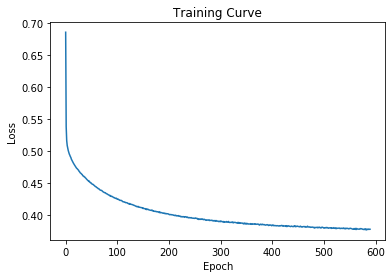

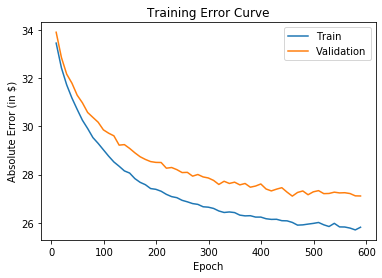

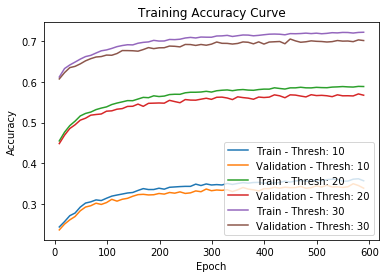

---[ITER 10] loss: 0.384573  time: 0.198
---[ITER 20] loss: 0.375485  time: 0.143
---[ITER 30] loss: 0.380730  time: 0.142
---[ITER 40] loss: 0.375984  time: 0.235
---[ITER 50] loss: 0.378592  time: 0.134
---[ITER 60] loss: 0.374976  time: 0.140
---[ITER 70] loss: 0.377492  time: 0.136
---[ITER 80] loss: 0.378408  time: 0.140
---[ITER 90] loss: 0.374600  time: 0.140
---[ITER 100] loss: 0.382725  time: 0.145
---[ITER 110] loss: 0.381388  time: 0.137
---[ITER 120] loss: 0.379544  time: 0.141
---[ITER 130] loss: 0.375911  time: 0.136
---[ITER 140] loss: 0.375479  time: 0.155
---[ITER 150] loss: 0.377755  time: 0.157
---[ITER 160] loss: 0.378661  time: 0.182
[EPOCH 591] loss: 0.378592  time: 2.575
---[ITER 10] loss: 0.378442  time: 0.205
---[ITER 20] loss: 0.377531  time: 0.145
---[ITER 30] loss: 0.376442  time: 0.147
---[ITER 40] loss: 0.370022  time: 0.233
---[ITER 50] loss: 0.377377  time: 0.137
---[ITER 60] loss: 0.372976  time: 0.146
---[ITER 70] loss: 0.376311  time: 0.136
---[ITER 8

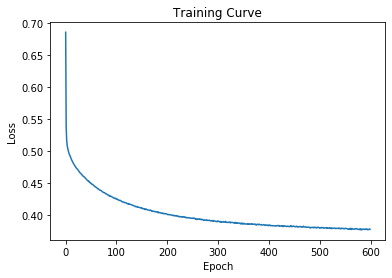

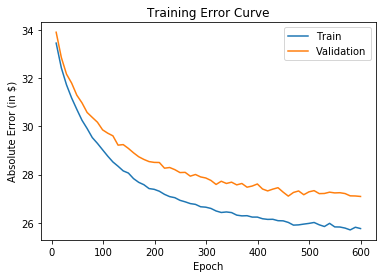

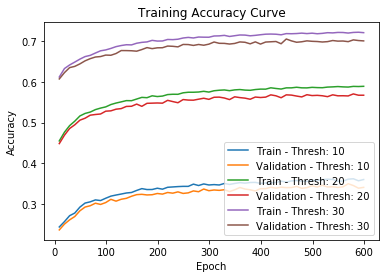

---[ITER 10] loss: 0.371954  time: 0.218
---[ITER 20] loss: 0.380414  time: 0.130
---[ITER 30] loss: 0.378193  time: 0.250
---[ITER 40] loss: 0.376155  time: 0.139
---[ITER 50] loss: 0.375232  time: 0.142
---[ITER 60] loss: 0.376559  time: 0.167
---[ITER 70] loss: 0.381366  time: 0.149
---[ITER 80] loss: 0.381951  time: 0.145
---[ITER 90] loss: 0.374020  time: 0.134
---[ITER 100] loss: 0.374640  time: 0.140
---[ITER 110] loss: 0.372904  time: 0.146
---[ITER 120] loss: 0.381919  time: 0.140
---[ITER 130] loss: 0.372310  time: 0.148
---[ITER 140] loss: 0.376683  time: 0.168
---[ITER 150] loss: 0.381444  time: 0.140
---[ITER 160] loss: 0.375890  time: 0.135
[EPOCH 601] loss: 0.377130  time: 2.615
---[ITER 10] loss: 0.379437  time: 0.251
---[ITER 20] loss: 0.383808  time: 0.125
---[ITER 30] loss: 0.375657  time: 0.236
---[ITER 40] loss: 0.376074  time: 0.138
---[ITER 50] loss: 0.379078  time: 0.147
---[ITER 60] loss: 0.379067  time: 0.133
---[ITER 70] loss: 0.383740  time: 0.144
---[ITER 8

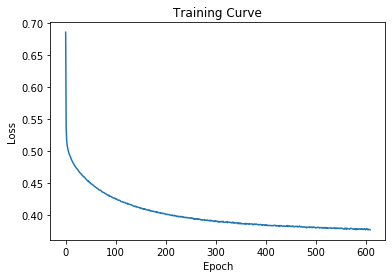

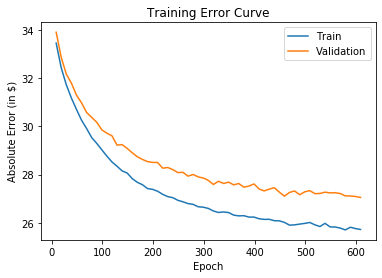

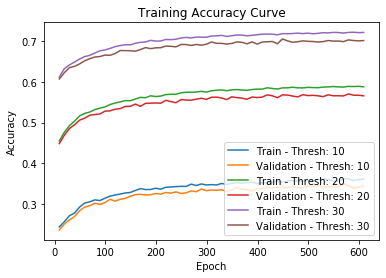

---[ITER 10] loss: 0.375145  time: 0.216
---[ITER 20] loss: 0.378213  time: 0.238
---[ITER 30] loss: 0.377718  time: 0.140
---[ITER 40] loss: 0.376228  time: 0.147
---[ITER 50] loss: 0.380394  time: 0.139
---[ITER 60] loss: 0.374716  time: 0.140
---[ITER 70] loss: 0.372415  time: 0.137
---[ITER 80] loss: 0.377310  time: 0.140
---[ITER 90] loss: 0.377610  time: 0.143
---[ITER 100] loss: 0.376182  time: 0.168
---[ITER 110] loss: 0.377113  time: 0.130
---[ITER 120] loss: 0.373092  time: 0.147
---[ITER 130] loss: 0.377279  time: 0.167
---[ITER 140] loss: 0.382907  time: 0.142
---[ITER 150] loss: 0.381292  time: 0.135
---[ITER 160] loss: 0.372830  time: 0.152
[EPOCH 611] loss: 0.377161  time: 2.609
---[ITER 10] loss: 0.374417  time: 0.201
---[ITER 20] loss: 0.383777  time: 0.260
---[ITER 30] loss: 0.380061  time: 0.197
---[ITER 40] loss: 0.378133  time: 0.180
---[ITER 50] loss: 0.377469  time: 0.190
---[ITER 60] loss: 0.373252  time: 0.167
---[ITER 70] loss: 0.378075  time: 0.193
---[ITER 8

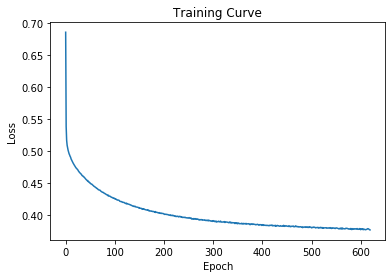

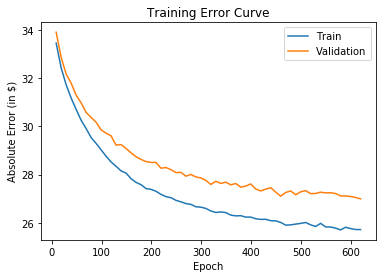

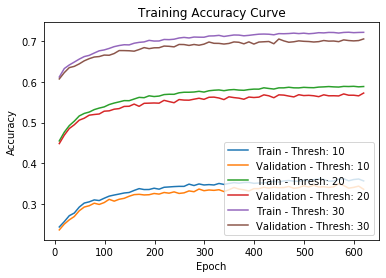

---[ITER 10] loss: 0.379268  time: 0.300
---[ITER 20] loss: 0.378521  time: 0.140
---[ITER 30] loss: 0.375872  time: 0.141
---[ITER 40] loss: 0.373869  time: 0.140
---[ITER 50] loss: 0.370346  time: 0.138
---[ITER 60] loss: 0.377460  time: 0.139
---[ITER 70] loss: 0.379490  time: 0.140
---[ITER 80] loss: 0.379094  time: 0.135
---[ITER 90] loss: 0.382463  time: 0.147
---[ITER 100] loss: 0.378563  time: 0.135
---[ITER 110] loss: 0.380729  time: 0.139
---[ITER 120] loss: 0.379186  time: 0.167
---[ITER 130] loss: 0.379037  time: 0.142
---[ITER 140] loss: 0.380802  time: 0.151
---[ITER 150] loss: 0.365214  time: 0.132
---[ITER 160] loss: 0.374600  time: 0.133
[EPOCH 621] loss: 0.377166  time: 2.546
---[ITER 10] loss: 0.379664  time: 0.307
---[ITER 20] loss: 0.376792  time: 0.134
---[ITER 30] loss: 0.370403  time: 0.138
---[ITER 40] loss: 0.378242  time: 0.138
---[ITER 50] loss: 0.374518  time: 0.176
---[ITER 60] loss: 0.383004  time: 0.142
---[ITER 70] loss: 0.379323  time: 0.136
---[ITER 8

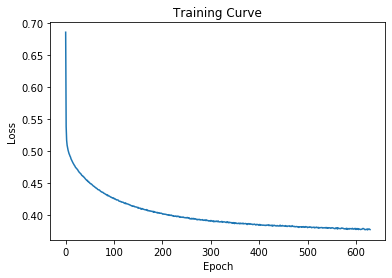

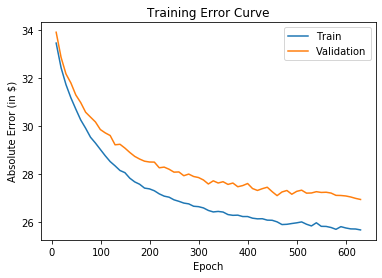

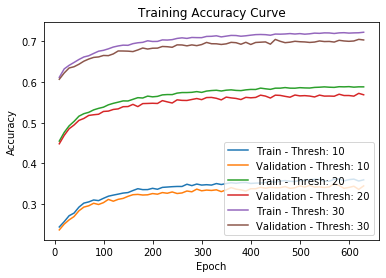

---[ITER 10] loss: 0.370135  time: 0.191
---[ITER 20] loss: 0.377068  time: 0.134
---[ITER 30] loss: 0.376147  time: 0.231
---[ITER 40] loss: 0.377162  time: 0.136
---[ITER 50] loss: 0.373143  time: 0.156
---[ITER 60] loss: 0.380747  time: 0.162
---[ITER 70] loss: 0.381716  time: 0.189
---[ITER 80] loss: 0.373828  time: 0.158
---[ITER 90] loss: 0.386230  time: 0.186
---[ITER 100] loss: 0.373153  time: 0.171
---[ITER 110] loss: 0.378397  time: 0.189
---[ITER 120] loss: 0.377263  time: 0.166
---[ITER 130] loss: 0.372428  time: 0.166
---[ITER 140] loss: 0.378026  time: 0.137
---[ITER 150] loss: 0.382626  time: 0.178
---[ITER 160] loss: 0.378152  time: 0.136
[EPOCH 631] loss: 0.377460  time: 2.849
---[ITER 10] loss: 0.373411  time: 0.216
---[ITER 20] loss: 0.378907  time: 0.145
---[ITER 30] loss: 0.387001  time: 0.236
---[ITER 40] loss: 0.372766  time: 0.135
---[ITER 50] loss: 0.373998  time: 0.140
---[ITER 60] loss: 0.382906  time: 0.141
---[ITER 70] loss: 0.379582  time: 0.134
---[ITER 8

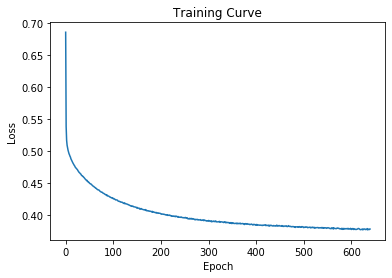

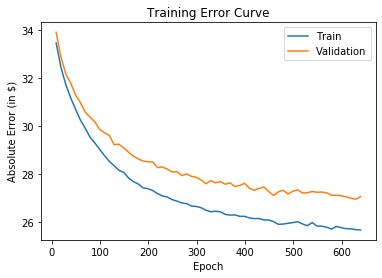

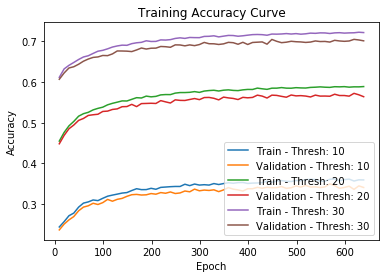

---[ITER 10] loss: 0.378799  time: 0.194
---[ITER 20] loss: 0.376884  time: 0.239
---[ITER 30] loss: 0.374252  time: 0.163
---[ITER 40] loss: 0.381688  time: 0.138
---[ITER 50] loss: 0.381699  time: 0.150
---[ITER 60] loss: 0.372769  time: 0.146
---[ITER 70] loss: 0.376840  time: 0.139
---[ITER 80] loss: 0.380271  time: 0.139
---[ITER 90] loss: 0.376294  time: 0.135
---[ITER 100] loss: 0.386525  time: 0.149
---[ITER 110] loss: 0.378627  time: 0.135
---[ITER 120] loss: 0.374634  time: 0.128
---[ITER 130] loss: 0.375204  time: 0.132
---[ITER 140] loss: 0.369924  time: 0.173
---[ITER 150] loss: 0.382577  time: 0.144
---[ITER 160] loss: 0.376407  time: 0.133
[EPOCH 641] loss: 0.377984  time: 2.559
---[ITER 10] loss: 0.382760  time: 0.198
---[ITER 20] loss: 0.379467  time: 0.233
---[ITER 30] loss: 0.376600  time: 0.138
---[ITER 40] loss: 0.373262  time: 0.135
---[ITER 50] loss: 0.377422  time: 0.137
---[ITER 60] loss: 0.372789  time: 0.182
---[ITER 70] loss: 0.366499  time: 0.130
---[ITER 8

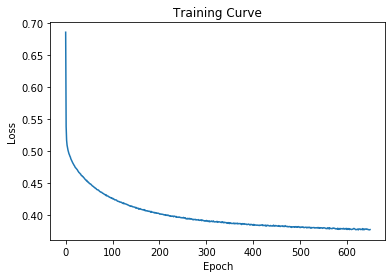

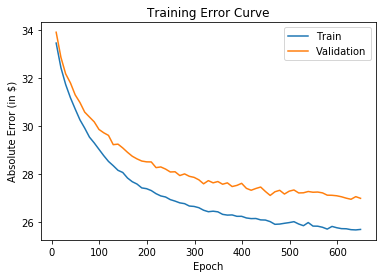

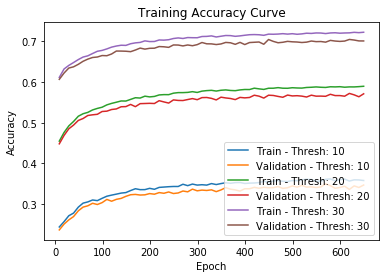

---[ITER 10] loss: 0.379857  time: 0.299
---[ITER 20] loss: 0.377415  time: 0.150
---[ITER 30] loss: 0.375025  time: 0.142
---[ITER 40] loss: 0.371666  time: 0.148
---[ITER 50] loss: 0.381032  time: 0.126
---[ITER 60] loss: 0.382109  time: 0.136
---[ITER 70] loss: 0.371865  time: 0.130
---[ITER 80] loss: 0.380662  time: 0.141
---[ITER 90] loss: 0.372781  time: 0.141
---[ITER 100] loss: 0.384595  time: 0.135
---[ITER 110] loss: 0.378104  time: 0.138
---[ITER 120] loss: 0.376888  time: 0.144
---[ITER 130] loss: 0.383350  time: 0.166
---[ITER 140] loss: 0.369774  time: 0.138
---[ITER 150] loss: 0.379265  time: 0.140
---[ITER 160] loss: 0.384633  time: 0.147
[EPOCH 651] loss: 0.377979  time: 2.541
---[ITER 10] loss: 0.377800  time: 0.376
---[ITER 20] loss: 0.382911  time: 0.169
---[ITER 30] loss: 0.379672  time: 0.172
---[ITER 40] loss: 0.377712  time: 0.191
---[ITER 50] loss: 0.373068  time: 0.193
---[ITER 60] loss: 0.380828  time: 0.252
---[ITER 70] loss: 0.378238  time: 0.171
---[ITER 8

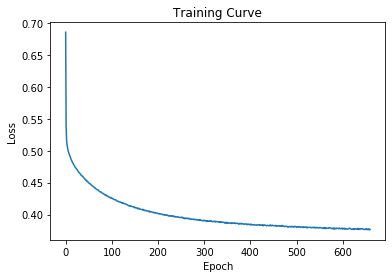

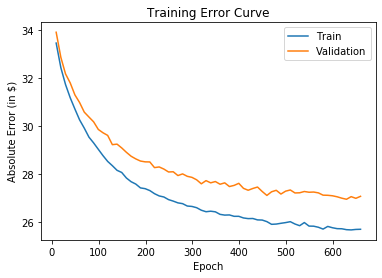

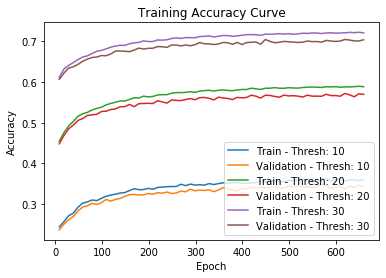

---[ITER 10] loss: 0.376338  time: 0.297
---[ITER 20] loss: 0.379527  time: 0.146
---[ITER 30] loss: 0.379720  time: 0.140
---[ITER 40] loss: 0.376811  time: 0.138
---[ITER 50] loss: 0.374605  time: 0.153
---[ITER 60] loss: 0.375710  time: 0.136
---[ITER 70] loss: 0.383304  time: 0.132
---[ITER 80] loss: 0.376239  time: 0.138
---[ITER 90] loss: 0.375108  time: 0.141
---[ITER 100] loss: 0.377606  time: 0.139
---[ITER 110] loss: 0.369749  time: 0.133
---[ITER 120] loss: 0.383031  time: 0.176
---[ITER 130] loss: 0.377106  time: 0.133
---[ITER 140] loss: 0.375242  time: 0.138
---[ITER 150] loss: 0.380199  time: 0.139
---[ITER 160] loss: 0.373424  time: 0.145
[EPOCH 661] loss: 0.376706  time: 2.544
---[ITER 10] loss: 0.378695  time: 0.321
---[ITER 20] loss: 0.382432  time: 0.130
---[ITER 30] loss: 0.377444  time: 0.137
---[ITER 40] loss: 0.374095  time: 0.134
---[ITER 50] loss: 0.375824  time: 0.143
---[ITER 60] loss: 0.368479  time: 0.136
---[ITER 70] loss: 0.378668  time: 0.138
---[ITER 8

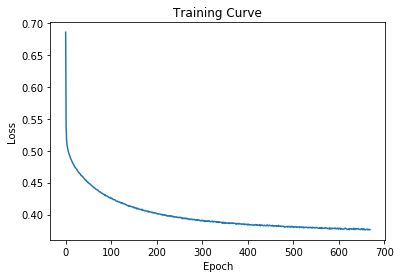

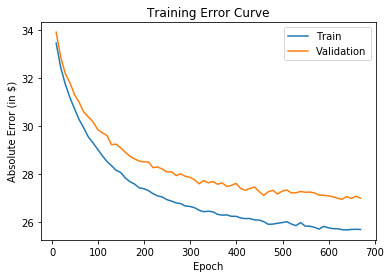

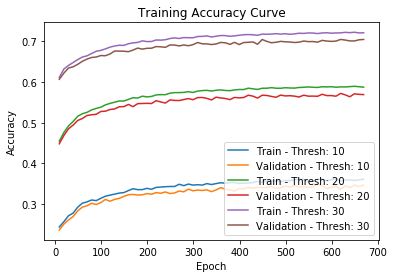

---[ITER 10] loss: 0.374598  time: 0.192
---[ITER 20] loss: 0.375871  time: 0.136
---[ITER 30] loss: 0.372906  time: 0.235
---[ITER 40] loss: 0.372259  time: 0.135
---[ITER 50] loss: 0.374553  time: 0.133
---[ITER 60] loss: 0.376378  time: 0.139
---[ITER 70] loss: 0.380423  time: 0.168
---[ITER 80] loss: 0.375817  time: 0.152
---[ITER 90] loss: 0.374924  time: 0.161
---[ITER 100] loss: 0.373175  time: 0.131
---[ITER 110] loss: 0.381928  time: 0.142
---[ITER 120] loss: 0.374767  time: 0.142
---[ITER 130] loss: 0.378052  time: 0.140
---[ITER 140] loss: 0.375175  time: 0.178
---[ITER 150] loss: 0.378342  time: 0.130
---[ITER 160] loss: 0.373051  time: 0.146
[EPOCH 671] loss: 0.376541  time: 2.586
---[ITER 10] loss: 0.370208  time: 0.201
---[ITER 20] loss: 0.370845  time: 0.138
---[ITER 30] loss: 0.375714  time: 0.223
---[ITER 40] loss: 0.379824  time: 0.136
---[ITER 50] loss: 0.373308  time: 0.137
---[ITER 60] loss: 0.376964  time: 0.145
---[ITER 70] loss: 0.381609  time: 0.138
---[ITER 8

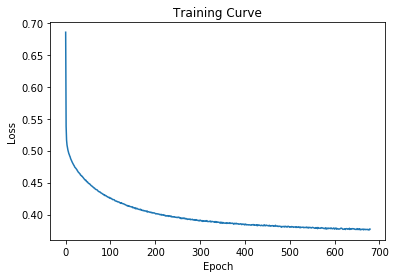

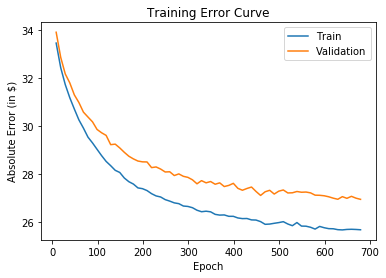

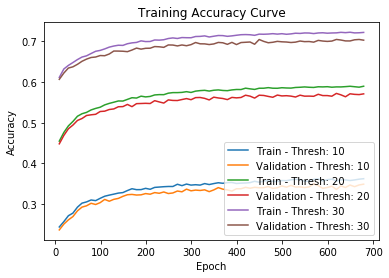

---[ITER 10] loss: 0.377677  time: 0.236
---[ITER 20] loss: 0.370327  time: 0.219
---[ITER 30] loss: 0.375027  time: 0.134
---[ITER 40] loss: 0.379141  time: 0.140
---[ITER 50] loss: 0.374754  time: 0.143
---[ITER 60] loss: 0.379093  time: 0.136
---[ITER 70] loss: 0.370992  time: 0.136
---[ITER 80] loss: 0.370978  time: 0.143
---[ITER 90] loss: 0.373374  time: 0.136
---[ITER 100] loss: 0.375366  time: 0.133
---[ITER 110] loss: 0.380085  time: 0.137
---[ITER 120] loss: 0.374914  time: 0.145
---[ITER 130] loss: 0.379187  time: 0.166
---[ITER 140] loss: 0.378294  time: 0.137
---[ITER 150] loss: 0.379170  time: 0.142
---[ITER 160] loss: 0.382762  time: 0.133
[EPOCH 681] loss: 0.376127  time: 2.531
---[ITER 10] loss: 0.371910  time: 0.199
---[ITER 20] loss: 0.374984  time: 0.241
---[ITER 30] loss: 0.376948  time: 0.142
---[ITER 40] loss: 0.366478  time: 0.141
---[ITER 50] loss: 0.379292  time: 0.142
---[ITER 60] loss: 0.376621  time: 0.136
---[ITER 70] loss: 0.378485  time: 0.136
---[ITER 8

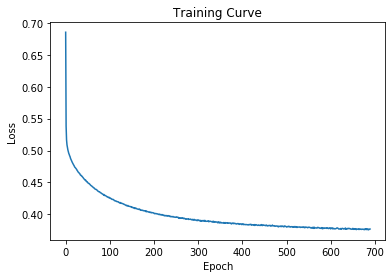

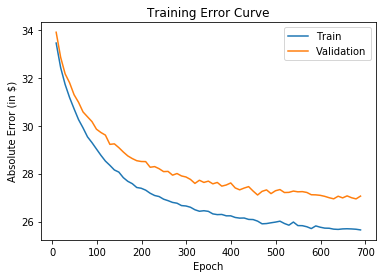

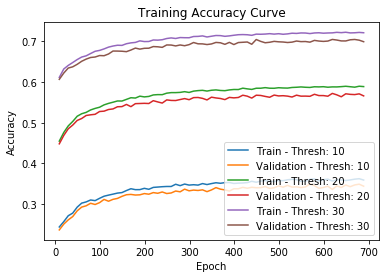

---[ITER 10] loss: 0.383905  time: 0.291
---[ITER 20] loss: 0.370506  time: 0.142
---[ITER 30] loss: 0.374324  time: 0.141
---[ITER 40] loss: 0.366191  time: 0.166
---[ITER 50] loss: 0.380389  time: 0.136
---[ITER 60] loss: 0.381785  time: 0.152
---[ITER 70] loss: 0.382182  time: 0.135
---[ITER 80] loss: 0.376495  time: 0.143
---[ITER 90] loss: 0.373352  time: 0.139
---[ITER 100] loss: 0.383101  time: 0.133
---[ITER 110] loss: 0.375303  time: 0.134
---[ITER 120] loss: 0.375906  time: 0.141
---[ITER 130] loss: 0.374017  time: 0.169
---[ITER 140] loss: 0.377225  time: 0.132
---[ITER 150] loss: 0.380846  time: 0.137
---[ITER 160] loss: 0.376621  time: 0.141
[EPOCH 691] loss: 0.376993  time: 2.556
---[ITER 10] loss: 0.380812  time: 0.322
---[ITER 20] loss: 0.384443  time: 0.126
---[ITER 30] loss: 0.365398  time: 0.138
---[ITER 40] loss: 0.381109  time: 0.138
---[ITER 50] loss: 0.382325  time: 0.133
---[ITER 60] loss: 0.379490  time: 0.137
---[ITER 70] loss: 0.378840  time: 0.140
---[ITER 8

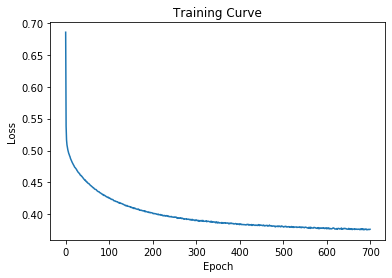

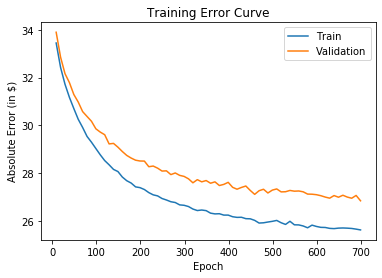

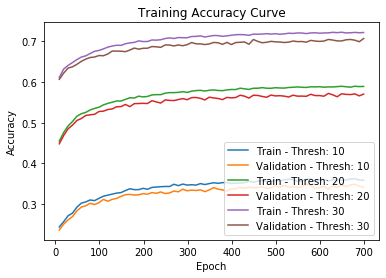

---[ITER 10] loss: 0.371540  time: 0.208
---[ITER 20] loss: 0.382995  time: 0.142
---[ITER 30] loss: 0.368689  time: 0.132
---[ITER 40] loss: 0.380512  time: 0.232
---[ITER 50] loss: 0.375667  time: 0.138
---[ITER 60] loss: 0.375702  time: 0.177
---[ITER 70] loss: 0.375215  time: 0.138
---[ITER 80] loss: 0.372534  time: 0.134
---[ITER 90] loss: 0.382180  time: 0.143
---[ITER 100] loss: 0.371657  time: 0.144
---[ITER 110] loss: 0.373230  time: 0.130
---[ITER 120] loss: 0.385088  time: 0.141
---[ITER 130] loss: 0.380674  time: 0.134
---[ITER 140] loss: 0.376900  time: 0.138
---[ITER 150] loss: 0.376431  time: 0.176
---[ITER 160] loss: 0.368241  time: 0.135
[EPOCH 701] loss: 0.375873  time: 2.563
---[ITER 10] loss: 0.378941  time: 0.205
---[ITER 20] loss: 0.382070  time: 0.146
---[ITER 30] loss: 0.375594  time: 0.132
---[ITER 40] loss: 0.373990  time: 0.230
---[ITER 50] loss: 0.372130  time: 0.134
---[ITER 60] loss: 0.374248  time: 0.136
---[ITER 70] loss: 0.378499  time: 0.134
---[ITER 8

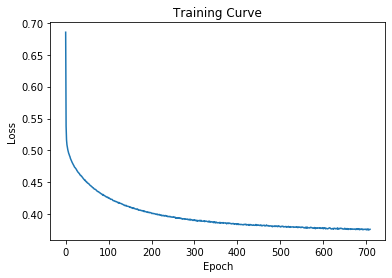

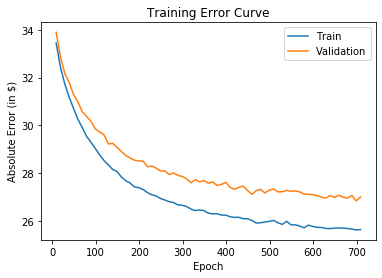

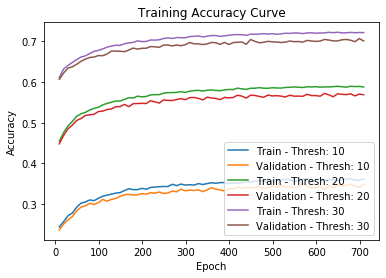

---[ITER 10] loss: 0.376961  time: 0.193
---[ITER 20] loss: 0.366136  time: 0.134
---[ITER 30] loss: 0.374201  time: 0.245
---[ITER 40] loss: 0.375617  time: 0.134
---[ITER 50] loss: 0.377414  time: 0.135
---[ITER 60] loss: 0.378980  time: 0.139
---[ITER 70] loss: 0.377426  time: 0.140
---[ITER 80] loss: 0.374699  time: 0.144
---[ITER 90] loss: 0.374688  time: 0.138
---[ITER 100] loss: 0.369079  time: 0.157
---[ITER 110] loss: 0.372214  time: 0.166
---[ITER 120] loss: 0.375317  time: 0.141
---[ITER 130] loss: 0.382852  time: 0.145
---[ITER 140] loss: 0.378716  time: 0.173
---[ITER 150] loss: 0.378905  time: 0.133
---[ITER 160] loss: 0.377311  time: 0.138
[EPOCH 711] loss: 0.375433  time: 2.573
---[ITER 10] loss: 0.374979  time: 0.199
---[ITER 20] loss: 0.373715  time: 0.132
---[ITER 30] loss: 0.366716  time: 0.261
---[ITER 40] loss: 0.372326  time: 0.135
---[ITER 50] loss: 0.374000  time: 0.151
---[ITER 60] loss: 0.378745  time: 0.125
---[ITER 70] loss: 0.370832  time: 0.139
---[ITER 8

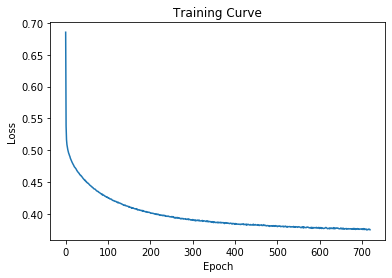

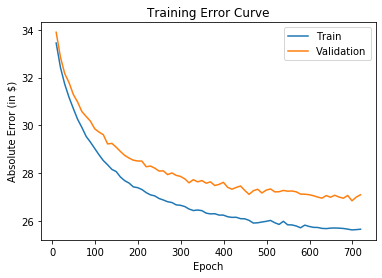

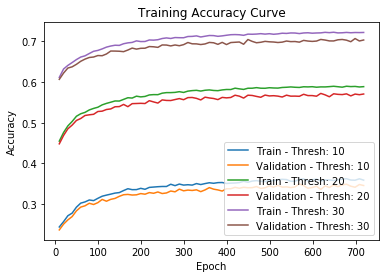

---[ITER 10] loss: 0.373597  time: 0.195
---[ITER 20] loss: 0.377557  time: 0.242
---[ITER 30] loss: 0.372764  time: 0.148
---[ITER 40] loss: 0.369948  time: 0.137
---[ITER 50] loss: 0.374519  time: 0.145
---[ITER 60] loss: 0.376784  time: 0.140
---[ITER 70] loss: 0.375901  time: 0.134
---[ITER 80] loss: 0.380864  time: 0.135
---[ITER 90] loss: 0.381499  time: 0.138
---[ITER 100] loss: 0.375436  time: 0.136
---[ITER 110] loss: 0.376266  time: 0.144
---[ITER 120] loss: 0.377821  time: 0.137
---[ITER 130] loss: 0.368394  time: 0.166
---[ITER 140] loss: 0.374036  time: 0.141
---[ITER 150] loss: 0.374308  time: 0.125
---[ITER 160] loss: 0.368309  time: 0.155
[EPOCH 721] loss: 0.375339  time: 2.532
---[ITER 10] loss: 0.380638  time: 0.198
---[ITER 20] loss: 0.365829  time: 0.259
---[ITER 30] loss: 0.376140  time: 0.135
---[ITER 40] loss: 0.372457  time: 0.133
---[ITER 50] loss: 0.380965  time: 0.134
---[ITER 60] loss: 0.374460  time: 0.137
---[ITER 70] loss: 0.364124  time: 0.131
---[ITER 8

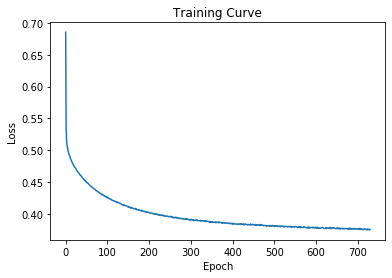

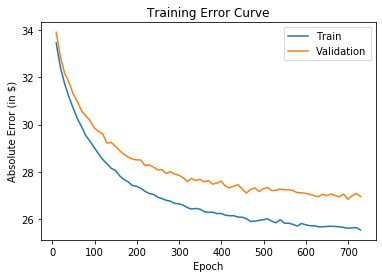

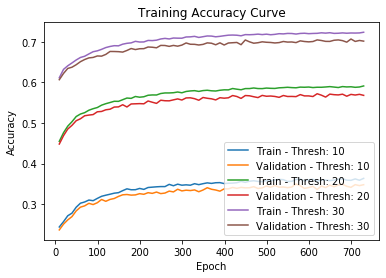

---[ITER 10] loss: 0.375510  time: 0.314
---[ITER 20] loss: 0.371390  time: 0.139
---[ITER 30] loss: 0.378750  time: 0.140
---[ITER 40] loss: 0.374122  time: 0.158
---[ITER 50] loss: 0.377033  time: 0.126
---[ITER 60] loss: 0.375200  time: 0.200
---[ITER 70] loss: 0.374113  time: 0.137
---[ITER 80] loss: 0.376909  time: 0.141
---[ITER 90] loss: 0.368890  time: 0.130
---[ITER 100] loss: 0.381074  time: 0.139
---[ITER 110] loss: 0.371420  time: 0.148
---[ITER 120] loss: 0.377719  time: 0.176
---[ITER 130] loss: 0.377516  time: 0.146
---[ITER 140] loss: 0.378989  time: 0.130
---[ITER 150] loss: 0.375178  time: 0.134
---[ITER 160] loss: 0.378963  time: 0.134
[EPOCH 731] loss: 0.375833  time: 2.619
---[ITER 10] loss: 0.380401  time: 0.320
---[ITER 20] loss: 0.381264  time: 0.141
---[ITER 30] loss: 0.373942  time: 0.166
---[ITER 40] loss: 0.380555  time: 0.117
---[ITER 50] loss: 0.379548  time: 0.141
---[ITER 60] loss: 0.377872  time: 0.138
---[ITER 70] loss: 0.370969  time: 0.131
---[ITER 8

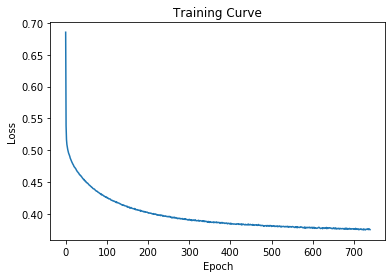

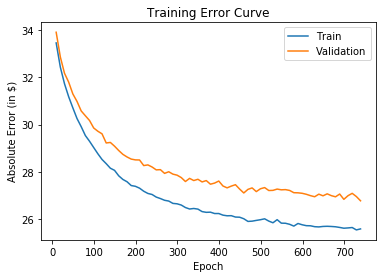

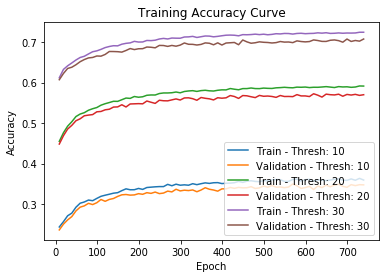

---[ITER 10] loss: 0.374853  time: 0.236
---[ITER 20] loss: 0.375863  time: 0.150
---[ITER 30] loss: 0.371850  time: 0.250
---[ITER 40] loss: 0.377556  time: 0.252
---[ITER 50] loss: 0.375829  time: 0.198
---[ITER 60] loss: 0.385294  time: 0.367
---[ITER 70] loss: 0.377468  time: 0.242
---[ITER 80] loss: 0.377331  time: 0.214
---[ITER 90] loss: 0.370585  time: 0.222
---[ITER 100] loss: 0.374751  time: 0.219
---[ITER 110] loss: 0.377542  time: 0.286
---[ITER 120] loss: 0.376908  time: 0.180
---[ITER 130] loss: 0.376108  time: 0.177
---[ITER 140] loss: 0.371437  time: 0.172
---[ITER 150] loss: 0.370474  time: 0.222
---[ITER 160] loss: 0.373868  time: 0.192
[EPOCH 741] loss: 0.375173  time: 3.751
---[ITER 10] loss: 0.373591  time: 0.239
---[ITER 20] loss: 0.372270  time: 0.191
---[ITER 30] loss: 0.370368  time: 0.284
---[ITER 40] loss: 0.369277  time: 0.154
---[ITER 50] loss: 0.369601  time: 0.149
---[ITER 60] loss: 0.374846  time: 0.140
---[ITER 70] loss: 0.377500  time: 0.173
---[ITER 8

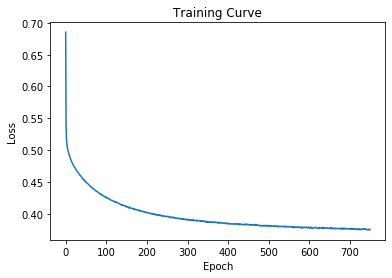

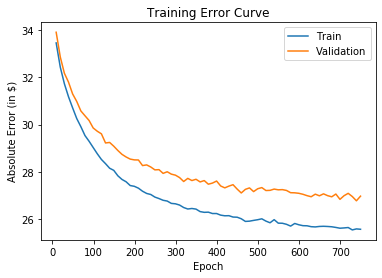

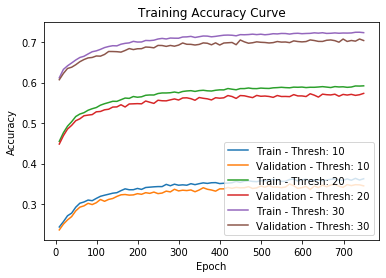

---[ITER 10] loss: 0.370207  time: 0.199
---[ITER 20] loss: 0.375170  time: 0.226
---[ITER 30] loss: 0.375459  time: 0.136
---[ITER 40] loss: 0.375738  time: 0.147
---[ITER 50] loss: 0.371624  time: 0.133
---[ITER 60] loss: 0.375049  time: 0.136
---[ITER 70] loss: 0.369947  time: 0.168
---[ITER 80] loss: 0.376262  time: 0.125
---[ITER 90] loss: 0.377935  time: 0.137
---[ITER 100] loss: 0.375778  time: 0.136
---[ITER 110] loss: 0.377370  time: 0.148
---[ITER 120] loss: 0.380549  time: 0.137
---[ITER 130] loss: 0.376965  time: 0.137
---[ITER 140] loss: 0.373814  time: 0.168
---[ITER 150] loss: 0.368715  time: 0.140
---[ITER 160] loss: 0.370761  time: 0.135
[EPOCH 751] loss: 0.374975  time: 2.529
---[ITER 10] loss: 0.373292  time: 0.202
---[ITER 20] loss: 0.385082  time: 0.235
---[ITER 30] loss: 0.367336  time: 0.129
---[ITER 40] loss: 0.376172  time: 0.136
---[ITER 50] loss: 0.373819  time: 0.139
---[ITER 60] loss: 0.381487  time: 0.138
---[ITER 70] loss: 0.368391  time: 0.182
---[ITER 8

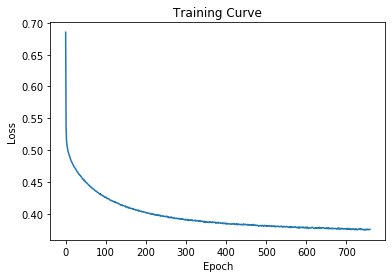

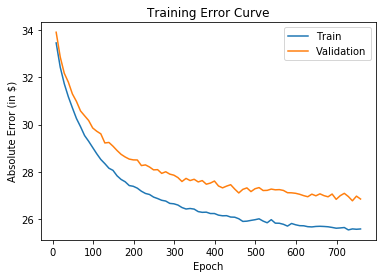

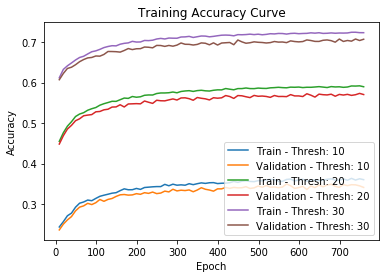

---[ITER 10] loss: 0.376954  time: 0.631
---[ITER 20] loss: 0.378691  time: 0.362
---[ITER 30] loss: 0.374927  time: 0.239
---[ITER 40] loss: 0.371911  time: 0.312
---[ITER 50] loss: 0.369347  time: 0.197
---[ITER 60] loss: 0.381975  time: 0.225
---[ITER 70] loss: 0.370652  time: 0.162
---[ITER 80] loss: 0.383743  time: 0.137
---[ITER 90] loss: 0.374519  time: 0.142
---[ITER 100] loss: 0.373293  time: 0.259
---[ITER 110] loss: 0.374773  time: 0.164
---[ITER 120] loss: 0.368396  time: 0.309
---[ITER 130] loss: 0.370726  time: 0.367
---[ITER 140] loss: 0.374704  time: 0.165
---[ITER 150] loss: 0.377937  time: 0.171
---[ITER 160] loss: 0.375619  time: 0.201
[EPOCH 761] loss: 0.375181  time: 4.161
---[ITER 10] loss: 0.370936  time: 0.343
---[ITER 20] loss: 0.374057  time: 0.195
---[ITER 30] loss: 0.378550  time: 0.193
---[ITER 40] loss: 0.377582  time: 0.177
---[ITER 50] loss: 0.371491  time: 0.154
---[ITER 60] loss: 0.373078  time: 0.179
---[ITER 70] loss: 0.372731  time: 0.190
---[ITER 8

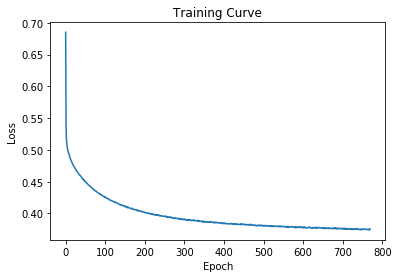

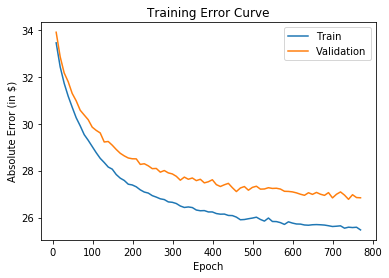

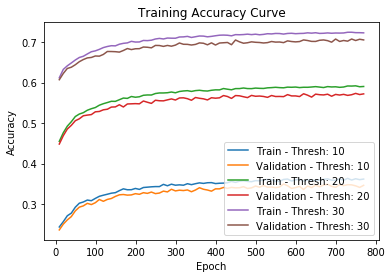

---[ITER 10] loss: 0.370297  time: 0.551
---[ITER 20] loss: 0.373157  time: 0.241
---[ITER 30] loss: 0.374594  time: 0.253
---[ITER 40] loss: 0.364113  time: 0.318
---[ITER 50] loss: 0.369689  time: 0.291
---[ITER 60] loss: 0.372193  time: 0.236
---[ITER 70] loss: 0.380271  time: 0.249
---[ITER 80] loss: 0.378310  time: 0.225
---[ITER 90] loss: 0.374890  time: 0.259
---[ITER 100] loss: 0.381927  time: 0.225
---[ITER 110] loss: 0.380084  time: 0.411
---[ITER 120] loss: 0.377552  time: 0.265
---[ITER 130] loss: 0.371854  time: 0.221
---[ITER 140] loss: 0.374555  time: 0.254
---[ITER 150] loss: 0.375454  time: 0.242
---[ITER 160] loss: 0.373573  time: 0.574
[EPOCH 771] loss: 0.374235  time: 5.167
---[ITER 10] loss: 0.370961  time: 14.785
---[ITER 20] loss: 0.368750  time: 0.254
---[ITER 30] loss: 0.373562  time: 0.588
---[ITER 40] loss: 0.373328  time: 0.195
---[ITER 50] loss: 0.375392  time: 0.169
---[ITER 60] loss: 0.370312  time: 0.188
---[ITER 70] loss: 0.373760  time: 0.267
---[ITER 

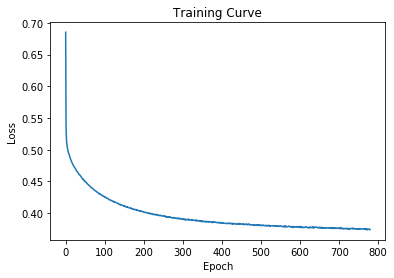

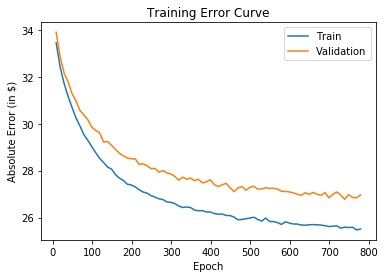

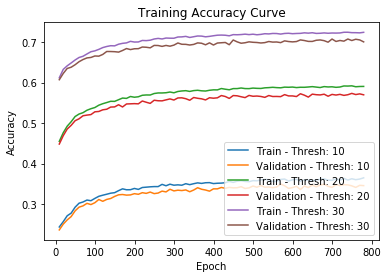

---[ITER 10] loss: 0.373040  time: 0.422
---[ITER 20] loss: 0.372701  time: 0.338
---[ITER 30] loss: 0.379865  time: 0.404
---[ITER 40] loss: 0.371280  time: 0.257
---[ITER 50] loss: 0.378486  time: 0.241
---[ITER 60] loss: 0.376872  time: 0.252
---[ITER 70] loss: 0.370802  time: 0.239
---[ITER 80] loss: 0.371752  time: 0.254
---[ITER 90] loss: 0.376981  time: 0.272
---[ITER 100] loss: 0.375083  time: 0.223
---[ITER 110] loss: 0.373166  time: 0.214
---[ITER 120] loss: 0.372806  time: 0.233
---[ITER 130] loss: 0.372103  time: 0.275
---[ITER 140] loss: 0.376608  time: 0.230
---[ITER 150] loss: 0.368042  time: 0.277
---[ITER 160] loss: 0.365608  time: 0.254
[EPOCH 781] loss: 0.373477  time: 4.546
---[ITER 10] loss: 0.375929  time: 0.365
---[ITER 20] loss: 0.372776  time: 0.269
---[ITER 30] loss: 0.379453  time: 0.356
---[ITER 40] loss: 0.377951  time: 0.368
---[ITER 50] loss: 0.376401  time: 0.229
---[ITER 60] loss: 0.370377  time: 0.244
---[ITER 70] loss: 0.361883  time: 0.230
---[ITER 8

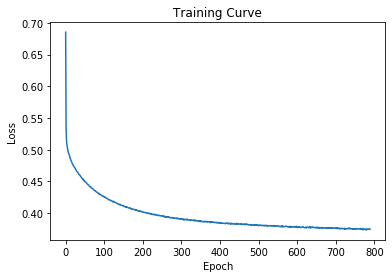

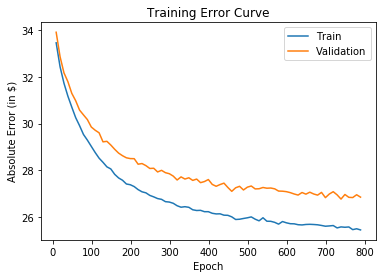

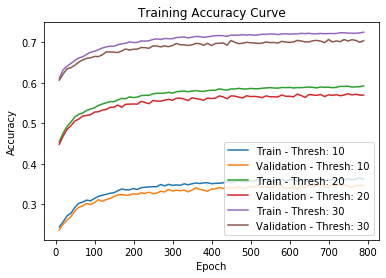

---[ITER 10] loss: 0.373722  time: 0.229
---[ITER 20] loss: 0.372117  time: 0.268
---[ITER 30] loss: 0.374600  time: 0.163
---[ITER 40] loss: 0.378345  time: 0.193
---[ITER 50] loss: 0.378402  time: 0.168
---[ITER 60] loss: 0.383358  time: 0.197
---[ITER 70] loss: 0.379497  time: 0.210
---[ITER 80] loss: 0.369576  time: 0.249
---[ITER 90] loss: 0.371106  time: 0.277
---[ITER 100] loss: 0.370515  time: 0.168
---[ITER 110] loss: 0.372154  time: 0.160
---[ITER 120] loss: 0.368748  time: 0.214
---[ITER 130] loss: 0.378506  time: 0.175
---[ITER 140] loss: 0.377208  time: 0.227
---[ITER 150] loss: 0.377919  time: 0.175
---[ITER 160] loss: 0.370160  time: 0.161
[EPOCH 791] loss: 0.374758  time: 3.360
---[ITER 10] loss: 0.374351  time: 0.241
---[ITER 20] loss: 0.372346  time: 0.312
---[ITER 30] loss: 0.375583  time: 0.187
---[ITER 40] loss: 0.375182  time: 0.220
---[ITER 50] loss: 0.372554  time: 0.172
---[ITER 60] loss: 0.376008  time: 0.164
---[ITER 70] loss: 0.371572  time: 0.160
---[ITER 8

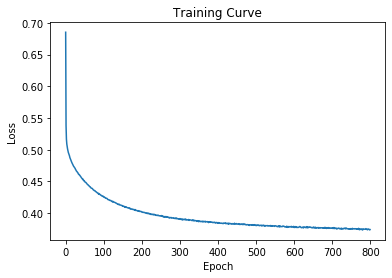

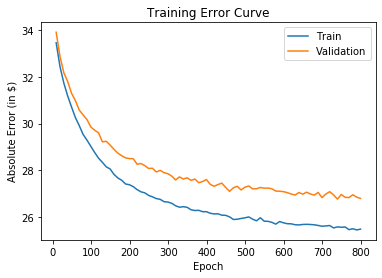

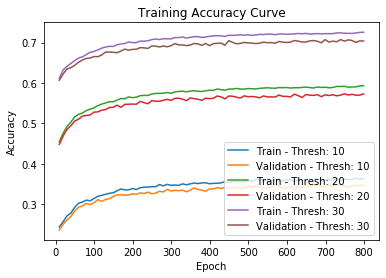

---[ITER 10] loss: 0.372330  time: 0.688
---[ITER 20] loss: 0.370737  time: 0.178
---[ITER 30] loss: 0.370709  time: 0.172
---[ITER 40] loss: 0.370322  time: 0.164
---[ITER 50] loss: 0.379668  time: 0.225
---[ITER 60] loss: 0.373543  time: 0.212
---[ITER 70] loss: 0.373768  time: 0.292
---[ITER 80] loss: 0.378282  time: 0.145
---[ITER 90] loss: 0.375656  time: 0.188
---[ITER 100] loss: 0.375221  time: 0.205
---[ITER 110] loss: 0.369442  time: 0.154
---[ITER 120] loss: 0.373098  time: 0.161
---[ITER 130] loss: 0.372900  time: 0.197
---[ITER 140] loss: 0.375109  time: 0.162
---[ITER 150] loss: 0.372359  time: 0.230
---[ITER 160] loss: 0.374994  time: 0.166
[EPOCH 801] loss: 0.373777  time: 3.696
---[ITER 10] loss: 0.376720  time: 0.357
---[ITER 20] loss: 0.372003  time: 0.168
---[ITER 30] loss: 0.376882  time: 0.188
---[ITER 40] loss: 0.380541  time: 0.186
---[ITER 50] loss: 0.378357  time: 0.204
---[ITER 60] loss: 0.375854  time: 0.164
---[ITER 70] loss: 0.373120  time: 0.162
---[ITER 8

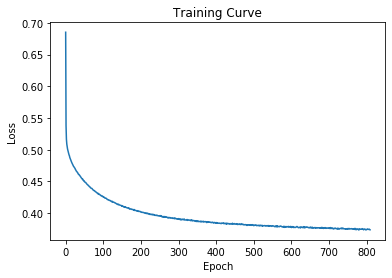

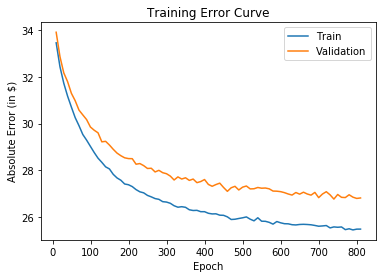

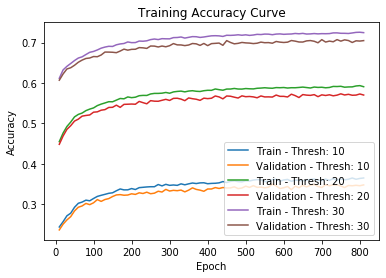

---[ITER 10] loss: 0.378805  time: 0.364
---[ITER 20] loss: 0.376701  time: 0.224
---[ITER 30] loss: 0.374613  time: 0.554
---[ITER 40] loss: 0.377973  time: 0.241
---[ITER 50] loss: 0.369302  time: 0.237
---[ITER 60] loss: 0.365194  time: 0.292
---[ITER 70] loss: 0.370785  time: 0.266
---[ITER 80] loss: 0.378471  time: 0.232
---[ITER 90] loss: 0.374879  time: 0.233
---[ITER 100] loss: 0.374784  time: 0.542
---[ITER 110] loss: 0.379334  time: 0.593
---[ITER 120] loss: 0.365252  time: 0.297
---[ITER 130] loss: 0.376805  time: 0.249
---[ITER 140] loss: 0.380113  time: 0.266
---[ITER 150] loss: 0.369759  time: 0.345
---[ITER 160] loss: 0.375951  time: 0.321
[EPOCH 811] loss: 0.374227  time: 5.567
---[ITER 10] loss: 0.375727  time: 0.489
---[ITER 20] loss: 0.367932  time: 0.260
---[ITER 30] loss: 0.380041  time: 0.314
---[ITER 40] loss: 0.378205  time: 0.444
---[ITER 50] loss: 0.374843  time: 0.256
---[ITER 60] loss: 0.372973  time: 0.253
---[ITER 70] loss: 0.371567  time: 0.249
---[ITER 8

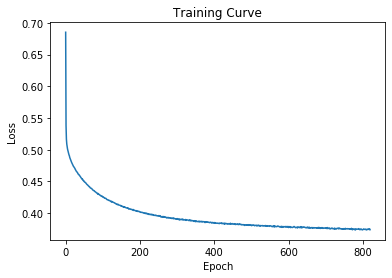

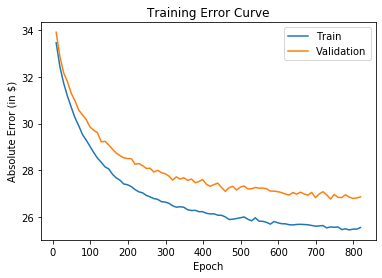

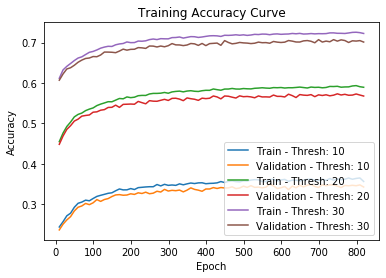

---[ITER 10] loss: 0.378422  time: 0.198
---[ITER 20] loss: 0.372130  time: 0.133
---[ITER 30] loss: 0.375466  time: 0.317
---[ITER 40] loss: 0.365783  time: 0.121
---[ITER 50] loss: 0.375788  time: 0.135
---[ITER 60] loss: 0.378531  time: 0.145
---[ITER 70] loss: 0.374700  time: 0.142
---[ITER 80] loss: 0.373836  time: 0.147
---[ITER 90] loss: 0.374343  time: 0.143
---[ITER 100] loss: 0.370507  time: 0.940
---[ITER 110] loss: 0.371886  time: 0.171
---[ITER 120] loss: 0.371848  time: 0.552
---[ITER 130] loss: 0.376393  time: 2.759
---[ITER 140] loss: 0.367165  time: 2.080
---[ITER 150] loss: 0.369479  time: 1.322
---[ITER 160] loss: 0.382606  time: 1.900
[EPOCH 821] loss: 0.373893  time: 12.766
---[ITER 10] loss: 0.368553  time: 1.665
---[ITER 20] loss: 0.386470  time: 0.373
---[ITER 30] loss: 0.374201  time: 0.405
---[ITER 40] loss: 0.369206  time: 0.203
---[ITER 50] loss: 0.370516  time: 0.202
---[ITER 60] loss: 0.373660  time: 0.151
---[ITER 70] loss: 0.375800  time: 0.146
---[ITER 

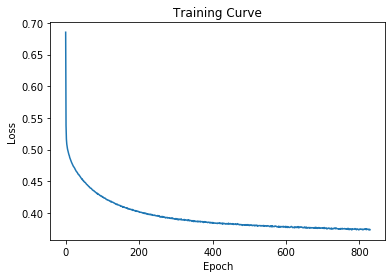

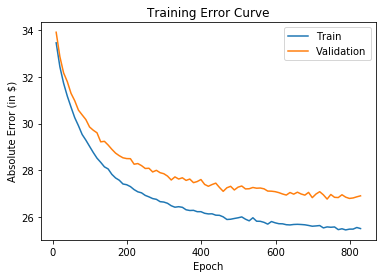

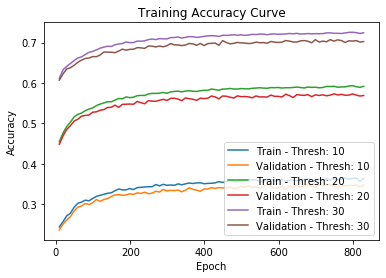

---[ITER 10] loss: 0.378168  time: 0.366
---[ITER 20] loss: 0.378645  time: 0.398
---[ITER 30] loss: 0.366278  time: 0.179
---[ITER 40] loss: 0.371650  time: 0.190
---[ITER 50] loss: 0.381487  time: 0.218
---[ITER 60] loss: 0.372472  time: 0.219
---[ITER 70] loss: 0.369879  time: 0.186
---[ITER 80] loss: 0.372116  time: 0.188
---[ITER 90] loss: 0.371263  time: 0.198
---[ITER 100] loss: 0.377991  time: 0.193
---[ITER 110] loss: 0.378822  time: 0.206
---[ITER 120] loss: 0.369755  time: 0.193
---[ITER 130] loss: 0.370236  time: 0.230
---[ITER 140] loss: 0.370473  time: 0.191
---[ITER 150] loss: 0.377400  time: 0.252
---[ITER 160] loss: 0.366944  time: 0.185
[EPOCH 831] loss: 0.373454  time: 3.758
---[ITER 10] loss: 0.376773  time: 0.294
---[ITER 20] loss: 0.375030  time: 0.306
---[ITER 30] loss: 0.370879  time: 0.202
---[ITER 40] loss: 0.379695  time: 559.518
---[ITER 50] loss: 0.368110  time: 0.269
---[ITER 60] loss: 0.374328  time: 0.421
---[ITER 70] loss: 0.373831  time: 0.809
---[ITER

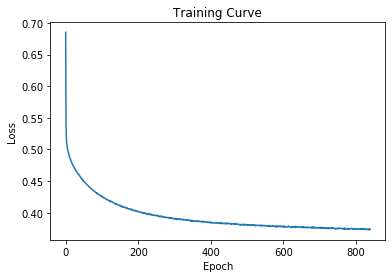

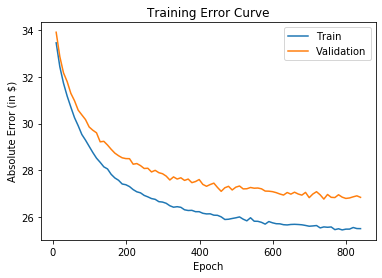

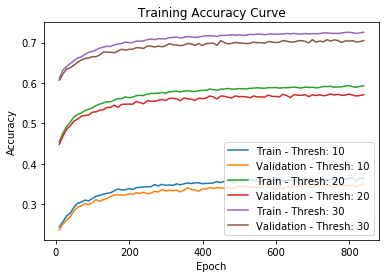

---[ITER 10] loss: 0.368630  time: 0.310
---[ITER 20] loss: 0.370767  time: 0.141
---[ITER 30] loss: 0.377756  time: 0.135
---[ITER 40] loss: 0.364981  time: 0.215
---[ITER 50] loss: 0.370140  time: 0.171
---[ITER 60] loss: 0.372941  time: 0.242
---[ITER 70] loss: 0.378748  time: 0.254
---[ITER 80] loss: 0.375838  time: 0.303
---[ITER 90] loss: 0.374544  time: 0.166
---[ITER 100] loss: 0.379724  time: 0.183
---[ITER 110] loss: 0.370200  time: 0.128
---[ITER 120] loss: 0.373218  time: 0.190
---[ITER 130] loss: 0.382307  time: 0.189
---[ITER 140] loss: 0.372086  time: 0.212
---[ITER 150] loss: 0.371288  time: 0.117
---[ITER 160] loss: 0.377345  time: 0.137
[EPOCH 841] loss: 0.373854  time: 3.214
---[ITER 10] loss: 0.379090  time: 0.306
---[ITER 20] loss: 0.372714  time: 0.136
---[ITER 30] loss: 0.378794  time: 0.148
---[ITER 40] loss: 0.370896  time: 0.137
---[ITER 50] loss: 0.376689  time: 0.145
---[ITER 60] loss: 0.371437  time: 0.131
---[ITER 70] loss: 0.382505  time: 0.142
---[ITER 8

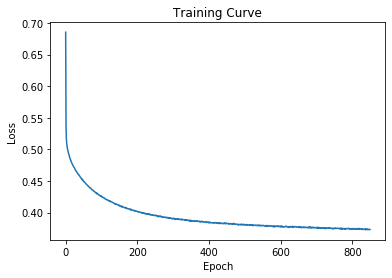

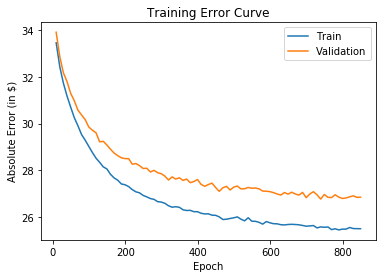

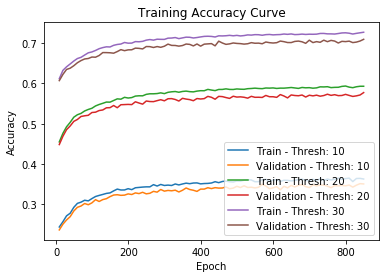

---[ITER 10] loss: 0.373307  time: 0.280
---[ITER 20] loss: 0.376792  time: 0.179
---[ITER 30] loss: 0.366525  time: 0.254
---[ITER 40] loss: 0.380095  time: 0.171
---[ITER 50] loss: 0.374905  time: 0.187
---[ITER 60] loss: 0.373049  time: 0.151
---[ITER 70] loss: 0.371174  time: 0.146
---[ITER 80] loss: 0.372711  time: 0.175
---[ITER 90] loss: 0.370499  time: 0.141
---[ITER 100] loss: 0.374776  time: 0.158
---[ITER 110] loss: 0.369708  time: 0.160
---[ITER 120] loss: 0.375922  time: 0.139
---[ITER 130] loss: 0.374709  time: 0.162
---[ITER 140] loss: 0.376912  time: 0.165
---[ITER 150] loss: 0.373839  time: 0.207
---[ITER 160] loss: 0.380287  time: 0.139
[EPOCH 851] loss: 0.374134  time: 2.941
---[ITER 10] loss: 0.375771  time: 0.233
---[ITER 20] loss: 0.367970  time: 0.150
---[ITER 30] loss: 0.372160  time: 0.301
---[ITER 40] loss: 0.372762  time: 0.145
---[ITER 50] loss: 0.369543  time: 0.155
---[ITER 60] loss: 0.376646  time: 0.154
---[ITER 70] loss: 0.377087  time: 0.176
---[ITER 8

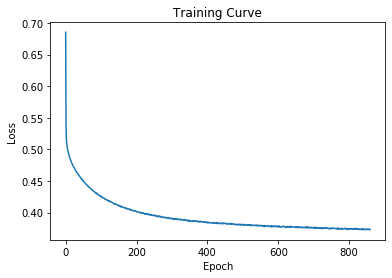

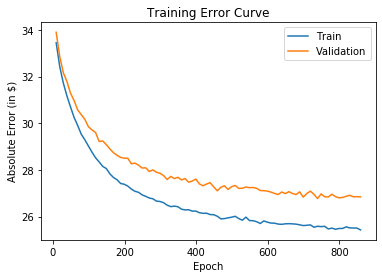

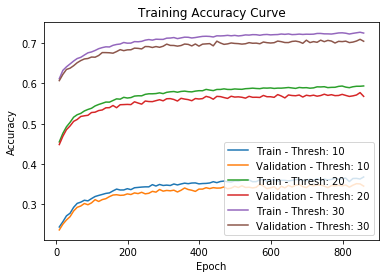

---[ITER 10] loss: 0.378149  time: 0.636
---[ITER 20] loss: 0.372086  time: 0.749
---[ITER 30] loss: 0.371125  time: 0.744
---[ITER 40] loss: 0.369622  time: 0.609
---[ITER 50] loss: 0.371197  time: 0.542
---[ITER 60] loss: 0.376856  time: 0.355
---[ITER 70] loss: 0.376477  time: 0.257
---[ITER 80] loss: 0.370758  time: 0.392
---[ITER 90] loss: 0.370066  time: 0.580
---[ITER 100] loss: 0.372766  time: 0.612
---[ITER 110] loss: 0.376109  time: 0.157
---[ITER 120] loss: 0.371689  time: 0.302
---[ITER 130] loss: 0.381126  time: 0.153
---[ITER 140] loss: 0.367643  time: 0.188
---[ITER 150] loss: 0.373490  time: 0.150
---[ITER 160] loss: 0.378789  time: 0.149
[EPOCH 861] loss: 0.373219  time: 6.714
---[ITER 10] loss: 0.368343  time: 0.215
---[ITER 20] loss: 0.362964  time: 0.255
---[ITER 30] loss: 0.374249  time: 0.217
---[ITER 40] loss: 0.378344  time: 0.137
---[ITER 50] loss: 0.373203  time: 0.197
---[ITER 60] loss: 0.373700  time: 0.145
---[ITER 70] loss: 0.376407  time: 0.148
---[ITER 8

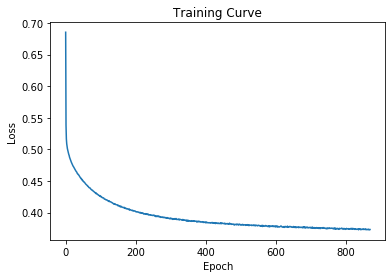

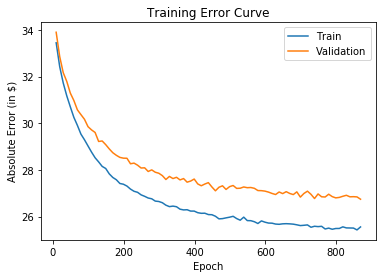

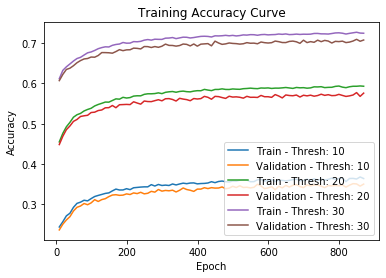

---[ITER 10] loss: 0.381334  time: 0.361
---[ITER 20] loss: 0.365699  time: 0.138
---[ITER 30] loss: 0.377825  time: 0.144
---[ITER 40] loss: 0.371838  time: 0.173
---[ITER 50] loss: 0.364794  time: 0.132
---[ITER 60] loss: 0.376047  time: 0.370
---[ITER 70] loss: 0.374107  time: 0.355
---[ITER 80] loss: 0.367103  time: 0.305
---[ITER 90] loss: 0.377119  time: 0.380
---[ITER 100] loss: 0.368205  time: 0.248
---[ITER 110] loss: 0.375638  time: 0.271
---[ITER 120] loss: 0.372338  time: 0.163
---[ITER 130] loss: 0.374635  time: 0.216
---[ITER 140] loss: 0.376160  time: 0.196
---[ITER 150] loss: 0.375558  time: 0.215
---[ITER 160] loss: 0.379336  time: 0.291
[EPOCH 871] loss: 0.373310  time: 4.470
---[ITER 10] loss: 0.370165  time: 0.506
---[ITER 20] loss: 0.365413  time: 0.175
---[ITER 30] loss: 0.379659  time: 0.227
---[ITER 40] loss: 0.366686  time: 0.159
---[ITER 50] loss: 0.369876  time: 0.158
---[ITER 60] loss: 0.373563  time: 0.241
---[ITER 70] loss: 0.371294  time: 0.149
---[ITER 8

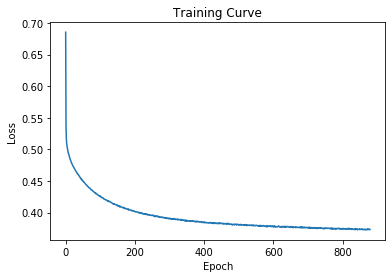

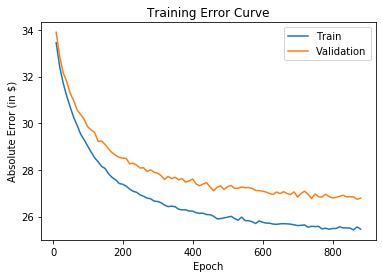

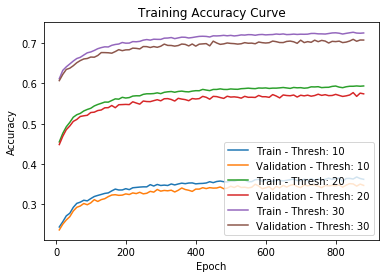

---[ITER 10] loss: 0.374054  time: 0.355
---[ITER 20] loss: 0.367388  time: 0.187
---[ITER 30] loss: 0.370824  time: 0.205
---[ITER 40] loss: 0.359414  time: 0.143
---[ITER 50] loss: 0.373966  time: 0.172
---[ITER 60] loss: 0.367844  time: 0.177
---[ITER 70] loss: 0.371881  time: 0.254
---[ITER 80] loss: 0.376546  time: 0.319
---[ITER 90] loss: 0.382231  time: 0.370
---[ITER 100] loss: 0.375807  time: 0.161
---[ITER 110] loss: 0.371170  time: 0.160
---[ITER 120] loss: 0.377491  time: 0.240
---[ITER 130] loss: 0.373180  time: 0.244
---[ITER 140] loss: 0.381596  time: 0.131
---[ITER 150] loss: 0.370605  time: 0.144
---[ITER 160] loss: 0.382025  time: 0.166
[EPOCH 881] loss: 0.373449  time: 3.555
---[ITER 10] loss: 0.372908  time: 0.335
---[ITER 20] loss: 0.373959  time: 0.207
---[ITER 30] loss: 0.381069  time: 0.145
---[ITER 40] loss: 0.364597  time: 0.231
---[ITER 50] loss: 0.370971  time: 0.384
---[ITER 60] loss: 0.371398  time: 0.153
---[ITER 70] loss: 0.380996  time: 0.175
---[ITER 8

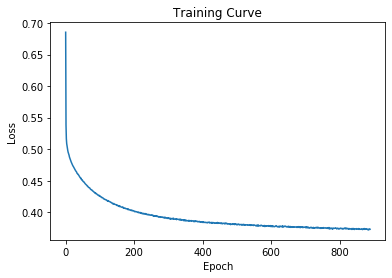

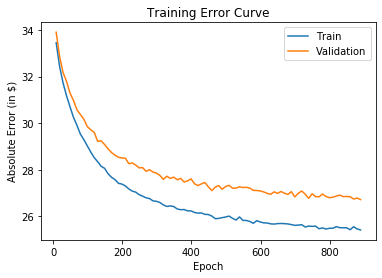

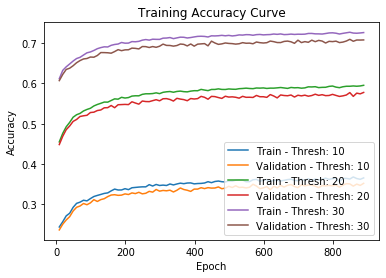

---[ITER 10] loss: 0.380700  time: 0.294
---[ITER 20] loss: 0.368459  time: 0.299
---[ITER 30] loss: 0.371869  time: 0.257
---[ITER 40] loss: 0.369507  time: 0.136
---[ITER 50] loss: 0.371787  time: 0.160
---[ITER 60] loss: 0.365629  time: 0.151
---[ITER 70] loss: 0.382920  time: 0.156
---[ITER 80] loss: 0.373522  time: 0.154
---[ITER 90] loss: 0.374475  time: 0.151
---[ITER 100] loss: 0.366169  time: 0.195
---[ITER 110] loss: 0.370507  time: 0.191
---[ITER 120] loss: 0.373514  time: 0.243
---[ITER 130] loss: 0.377276  time: 0.140
---[ITER 140] loss: 0.374584  time: 0.191
---[ITER 150] loss: 0.380622  time: 0.156
---[ITER 160] loss: 0.366495  time: 0.156
[EPOCH 891] loss: 0.372948  time: 3.158
---[ITER 10] loss: 0.377999  time: 0.222
---[ITER 20] loss: 0.378549  time: 0.185
---[ITER 30] loss: 0.376354  time: 0.235
---[ITER 40] loss: 0.368750  time: 0.172
---[ITER 50] loss: 0.370101  time: 0.143
---[ITER 60] loss: 0.376160  time: 0.160
---[ITER 70] loss: 0.367621  time: 0.167
---[ITER 8

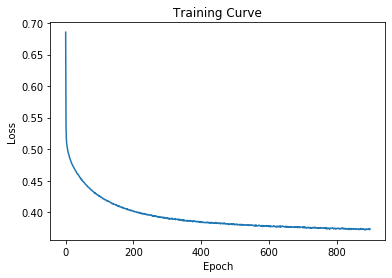

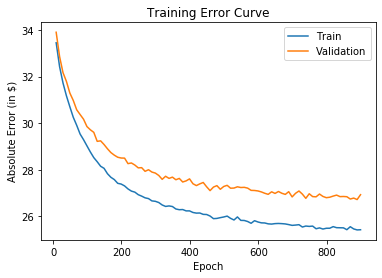

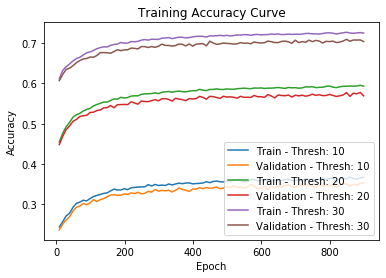

---[ITER 10] loss: 0.372732  time: 0.205
---[ITER 20] loss: 0.372968  time: 0.228
---[ITER 30] loss: 0.376070  time: 0.141
---[ITER 40] loss: 0.378912  time: 0.130
---[ITER 50] loss: 0.374329  time: 0.142
---[ITER 60] loss: 0.378300  time: 0.135
---[ITER 70] loss: 0.374193  time: 0.158
---[ITER 80] loss: 0.373661  time: 0.142
---[ITER 90] loss: 0.361034  time: 0.135
---[ITER 100] loss: 0.375519  time: 0.141
---[ITER 110] loss: 0.370583  time: 0.186
---[ITER 120] loss: 0.366889  time: 0.129
---[ITER 130] loss: 0.367599  time: 0.175
---[ITER 140] loss: 0.375342  time: 0.154
---[ITER 150] loss: 0.378820  time: 0.132
---[ITER 160] loss: 0.372050  time: 0.145
[EPOCH 901] loss: 0.373005  time: 2.602
---[ITER 10] loss: 0.368004  time: 0.207
---[ITER 20] loss: 0.375469  time: 0.291
---[ITER 30] loss: 0.368834  time: 0.135
---[ITER 40] loss: 0.374164  time: 0.142
---[ITER 50] loss: 0.365255  time: 0.137
---[ITER 60] loss: 0.380365  time: 0.139
---[ITER 70] loss: 0.370185  time: 0.135
---[ITER 8

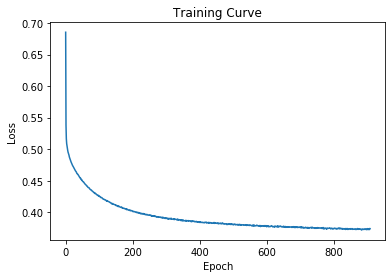

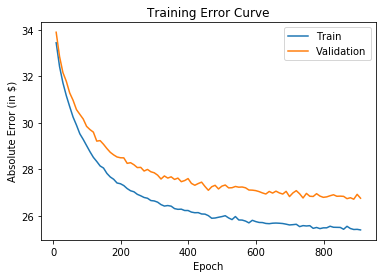

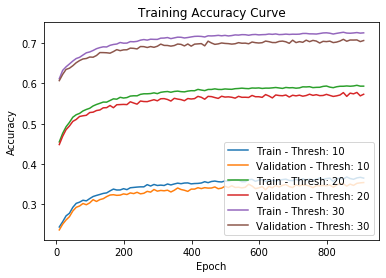

---[ITER 10] loss: 0.379911  time: 0.298
---[ITER 20] loss: 0.377321  time: 0.137
---[ITER 30] loss: 0.369587  time: 0.153
---[ITER 40] loss: 0.368656  time: 0.132
---[ITER 50] loss: 0.375539  time: 0.148
---[ITER 60] loss: 0.377894  time: 0.133
---[ITER 70] loss: 0.373349  time: 0.141
---[ITER 80] loss: 0.365047  time: 0.133
---[ITER 90] loss: 0.369561  time: 0.147
---[ITER 100] loss: 0.380640  time: 0.149
---[ITER 110] loss: 0.373372  time: 0.136
---[ITER 120] loss: 0.367656  time: 0.136
---[ITER 130] loss: 0.367048  time: 0.173
---[ITER 140] loss: 0.381857  time: 0.148
---[ITER 150] loss: 0.369491  time: 0.139
---[ITER 160] loss: 0.372943  time: 0.151
[EPOCH 911] loss: 0.373796  time: 2.578
---[ITER 10] loss: 0.369608  time: 0.305
---[ITER 20] loss: 0.368624  time: 0.139
---[ITER 30] loss: 0.372004  time: 0.148
---[ITER 40] loss: 0.370897  time: 0.139
---[ITER 50] loss: 0.363359  time: 0.204
---[ITER 60] loss: 0.366689  time: 0.121
---[ITER 70] loss: 0.376583  time: 0.143
---[ITER 8

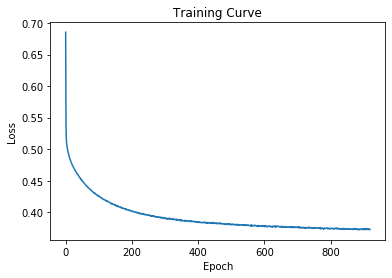

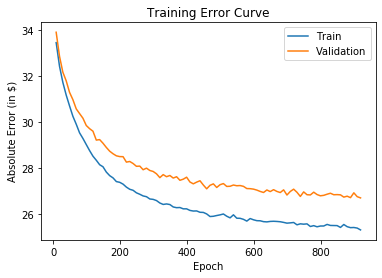

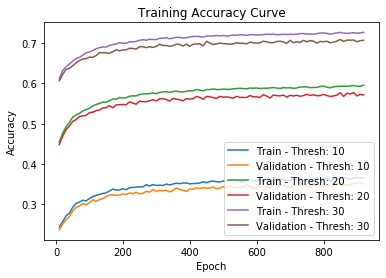

---[ITER 10] loss: 0.370196  time: 0.187
---[ITER 20] loss: 0.367856  time: 0.141
---[ITER 30] loss: 0.363950  time: 0.135
---[ITER 40] loss: 0.368064  time: 0.225
---[ITER 50] loss: 0.370468  time: 0.165
---[ITER 60] loss: 0.372469  time: 0.126
---[ITER 70] loss: 0.373151  time: 0.137
---[ITER 80] loss: 0.374607  time: 0.135
---[ITER 90] loss: 0.381183  time: 0.136
---[ITER 100] loss: 0.371908  time: 0.180
---[ITER 110] loss: 0.373979  time: 0.287
---[ITER 120] loss: 0.368969  time: 0.142
---[ITER 130] loss: 0.373437  time: 0.141
---[ITER 140] loss: 0.371472  time: 0.132
---[ITER 150] loss: 0.382865  time: 0.179
---[ITER 160] loss: 0.373238  time: 0.139
[EPOCH 921] loss: 0.372663  time: 2.713
---[ITER 10] loss: 0.370754  time: 0.208
---[ITER 20] loss: 0.367954  time: 0.163
---[ITER 30] loss: 0.378385  time: 0.199
---[ITER 40] loss: 0.372844  time: 0.267
---[ITER 50] loss: 0.371529  time: 0.152
---[ITER 60] loss: 0.375785  time: 0.238
---[ITER 70] loss: 0.366836  time: 0.186
---[ITER 8

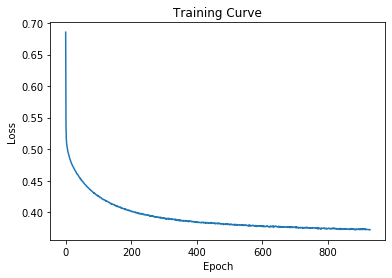

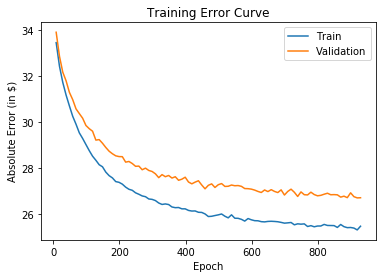

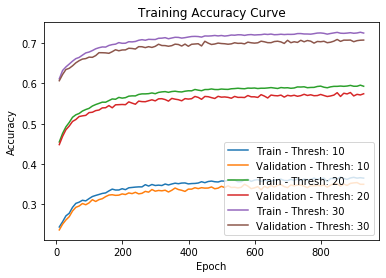

---[ITER 10] loss: 0.368005  time: 0.202
---[ITER 20] loss: 0.379584  time: 0.120
---[ITER 30] loss: 0.374977  time: 0.234
---[ITER 40] loss: 0.373949  time: 0.138
---[ITER 50] loss: 0.369773  time: 0.137
---[ITER 60] loss: 0.372239  time: 0.139
---[ITER 70] loss: 0.378503  time: 0.140
---[ITER 80] loss: 0.377085  time: 0.136
---[ITER 90] loss: 0.373952  time: 0.133
---[ITER 100] loss: 0.380169  time: 0.158
---[ITER 110] loss: 0.369956  time: 0.128
---[ITER 120] loss: 0.369129  time: 0.139
---[ITER 130] loss: 0.368688  time: 0.195
---[ITER 140] loss: 0.370027  time: 0.155
---[ITER 150] loss: 0.371597  time: 0.135
---[ITER 160] loss: 0.373699  time: 0.137
[EPOCH 931] loss: 0.372894  time: 2.549
---[ITER 10] loss: 0.368827  time: 0.198
---[ITER 20] loss: 0.370177  time: 0.138
---[ITER 30] loss: 0.375277  time: 0.241
---[ITER 40] loss: 0.376697  time: 0.149
---[ITER 50] loss: 0.371282  time: 0.128
---[ITER 60] loss: 0.377030  time: 0.133
---[ITER 70] loss: 0.374782  time: 0.137
---[ITER 8

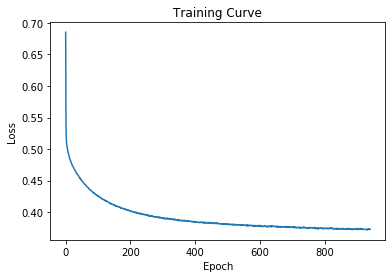

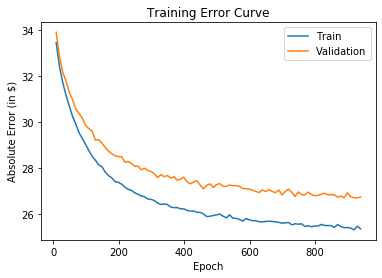

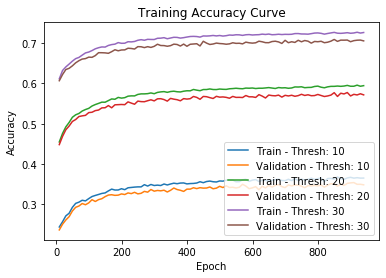

---[ITER 10] loss: 0.377251  time: 0.195
---[ITER 20] loss: 0.375823  time: 0.257
---[ITER 30] loss: 0.371319  time: 0.132
---[ITER 40] loss: 0.369488  time: 0.140
---[ITER 50] loss: 0.373570  time: 0.153
---[ITER 60] loss: 0.366525  time: 0.138
---[ITER 70] loss: 0.374922  time: 0.137
---[ITER 80] loss: 0.377949  time: 0.136
---[ITER 90] loss: 0.371897  time: 0.143
---[ITER 100] loss: 0.373016  time: 0.137
---[ITER 110] loss: 0.374084  time: 0.136
---[ITER 120] loss: 0.375910  time: 0.147
---[ITER 130] loss: 0.363900  time: 0.186
---[ITER 140] loss: 0.374110  time: 0.151
---[ITER 150] loss: 0.374464  time: 0.193
---[ITER 160] loss: 0.378121  time: 0.150
[EPOCH 941] loss: 0.372769  time: 2.649
---[ITER 10] loss: 0.371447  time: 0.201
---[ITER 20] loss: 0.375557  time: 0.239
---[ITER 30] loss: 0.372687  time: 0.140
---[ITER 40] loss: 0.370003  time: 0.162
---[ITER 50] loss: 0.364771  time: 0.139
---[ITER 60] loss: 0.379156  time: 0.140
---[ITER 70] loss: 0.369255  time: 0.135
---[ITER 8

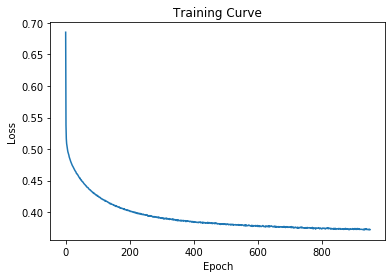

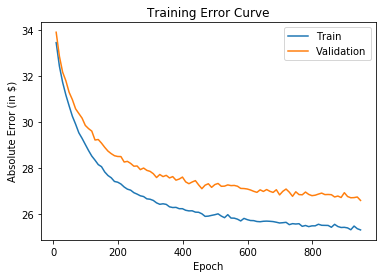

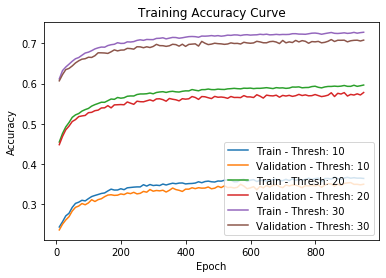

---[ITER 10] loss: 0.377198  time: 0.333
---[ITER 20] loss: 0.372254  time: 0.153
---[ITER 30] loss: 0.372832  time: 0.180
---[ITER 40] loss: 0.372162  time: 0.161
---[ITER 50] loss: 0.371431  time: 0.173
---[ITER 60] loss: 0.366395  time: 0.165
---[ITER 70] loss: 0.371446  time: 0.154
---[ITER 80] loss: 0.370462  time: 0.149
---[ITER 90] loss: 0.373959  time: 0.208
---[ITER 100] loss: 0.370633  time: 0.151
---[ITER 110] loss: 0.371793  time: 0.140
---[ITER 120] loss: 0.372676  time: 0.173
---[ITER 130] loss: 0.372509  time: 0.150
---[ITER 140] loss: 0.362160  time: 0.157
---[ITER 150] loss: 0.368152  time: 0.176
---[ITER 160] loss: 0.374391  time: 0.203
[EPOCH 951] loss: 0.371402  time: 3.032
---[ITER 10] loss: 0.370734  time: 0.350
---[ITER 20] loss: 0.375409  time: 0.138
---[ITER 30] loss: 0.364894  time: 0.179
---[ITER 40] loss: 0.370536  time: 0.190
---[ITER 50] loss: 0.372362  time: 0.181
---[ITER 60] loss: 0.368369  time: 0.150
---[ITER 70] loss: 0.371370  time: 0.152
---[ITER 8

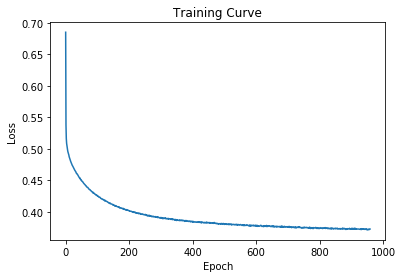

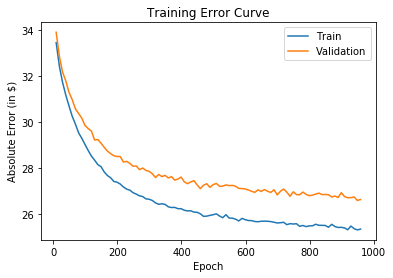

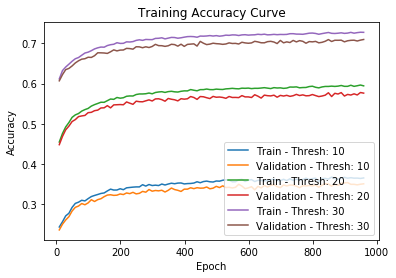

---[ITER 10] loss: 0.375571  time: 0.341
---[ITER 20] loss: 0.364354  time: 0.134
---[ITER 30] loss: 0.375037  time: 0.265
---[ITER 40] loss: 0.371463  time: 0.152
---[ITER 50] loss: 0.372132  time: 0.140
---[ITER 60] loss: 0.374518  time: 0.150
---[ITER 70] loss: 0.370257  time: 0.172
---[ITER 80] loss: 0.375454  time: 0.163
---[ITER 90] loss: 0.365889  time: 0.180
---[ITER 100] loss: 0.373264  time: 0.140
---[ITER 110] loss: 0.380422  time: 0.148
---[ITER 120] loss: 0.364858  time: 0.153
---[ITER 130] loss: 0.374407  time: 0.165
---[ITER 140] loss: 0.372398  time: 0.170
---[ITER 150] loss: 0.381013  time: 0.192
---[ITER 160] loss: 0.368764  time: 0.166
[EPOCH 961] loss: 0.372795  time: 2.957
---[ITER 10] loss: 0.367647  time: 0.342
---[ITER 20] loss: 0.371716  time: 0.331
---[ITER 30] loss: 0.375305  time: 0.305
---[ITER 40] loss: 0.374164  time: 0.146
---[ITER 50] loss: 0.372618  time: 0.179
---[ITER 60] loss: 0.371945  time: 0.232
---[ITER 70] loss: 0.360624  time: 0.152
---[ITER 8

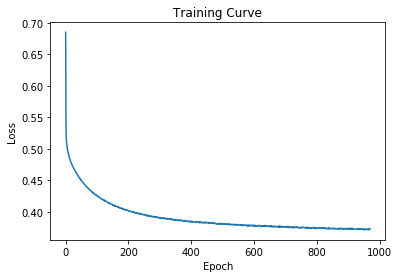

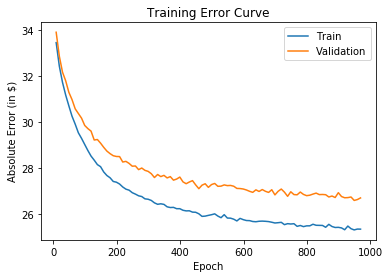

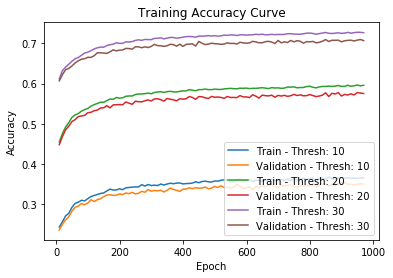

---[ITER 10] loss: 0.374162  time: 0.237
---[ITER 20] loss: 0.364217  time: 0.319
---[ITER 30] loss: 0.369612  time: 0.154
---[ITER 40] loss: 0.366327  time: 0.158
---[ITER 50] loss: 0.371040  time: 0.187
---[ITER 60] loss: 0.370218  time: 0.182
---[ITER 70] loss: 0.366207  time: 0.184
---[ITER 80] loss: 0.378373  time: 0.198
---[ITER 90] loss: 0.366897  time: 0.200
---[ITER 100] loss: 0.372589  time: 0.184
---[ITER 110] loss: 0.369669  time: 0.265
---[ITER 120] loss: 0.379228  time: 0.156
---[ITER 130] loss: 0.371075  time: 0.198
---[ITER 140] loss: 0.373150  time: 0.241
---[ITER 150] loss: 0.375704  time: 0.140
---[ITER 160] loss: 0.382512  time: 0.168
[EPOCH 971] loss: 0.372091  time: 3.329
---[ITER 10] loss: 0.372279  time: 0.233
---[ITER 20] loss: 0.367020  time: 0.282
---[ITER 30] loss: 0.373617  time: 0.149
---[ITER 40] loss: 0.372484  time: 0.156
---[ITER 50] loss: 0.371252  time: 0.138
---[ITER 60] loss: 0.369427  time: 0.146
---[ITER 70] loss: 0.371621  time: 0.158
---[ITER 8

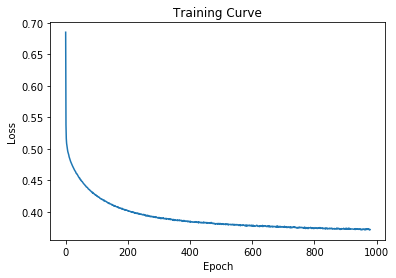

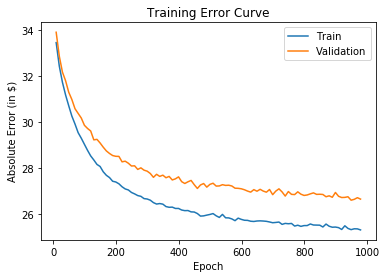

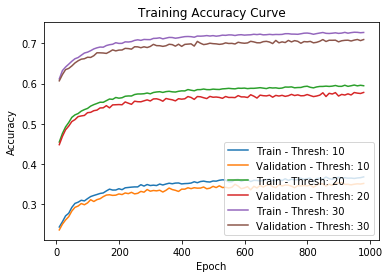

---[ITER 10] loss: 0.379912  time: 0.328
---[ITER 20] loss: 0.369781  time: 0.149
---[ITER 30] loss: 0.374688  time: 0.151
---[ITER 40] loss: 0.378280  time: 0.161
---[ITER 50] loss: 0.364720  time: 0.143
---[ITER 60] loss: 0.370009  time: 0.150
---[ITER 70] loss: 0.371676  time: 0.157
---[ITER 80] loss: 0.381122  time: 0.154
---[ITER 90] loss: 0.362514  time: 0.160
---[ITER 100] loss: 0.370503  time: 0.152
---[ITER 110] loss: 0.373347  time: 0.141
---[ITER 120] loss: 0.361545  time: 0.337
---[ITER 130] loss: 0.374126  time: 0.236
---[ITER 140] loss: 0.369917  time: 0.136
---[ITER 150] loss: 0.374623  time: 0.191
---[ITER 160] loss: 0.367392  time: 0.210
[EPOCH 981] loss: 0.371814  time: 3.103
---[ITER 10] loss: 0.364500  time: 0.348
---[ITER 20] loss: 0.378016  time: 0.137
---[ITER 30] loss: 0.370989  time: 0.166
---[ITER 40] loss: 0.370900  time: 0.164
---[ITER 50] loss: 0.379878  time: 0.178
---[ITER 60] loss: 0.371705  time: 0.192
---[ITER 70] loss: 0.373389  time: 0.164
---[ITER 8

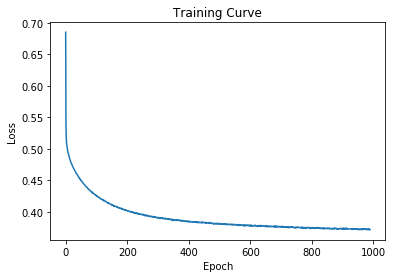

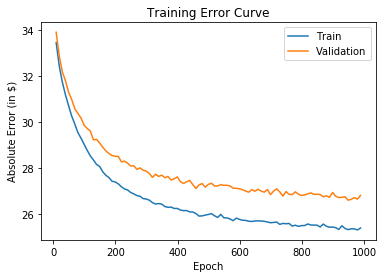

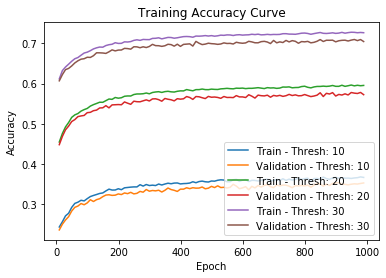

---[ITER 10] loss: 0.371768  time: 0.352
---[ITER 20] loss: 0.368297  time: 0.183
---[ITER 30] loss: 0.377751  time: 0.241
---[ITER 40] loss: 0.374845  time: 0.210
---[ITER 50] loss: 0.373966  time: 0.177
---[ITER 60] loss: 0.369450  time: 0.166
---[ITER 70] loss: 0.368686  time: 0.485
---[ITER 80] loss: 0.373767  time: 0.980
---[ITER 90] loss: 0.368865  time: 1.355
---[ITER 100] loss: 0.379116  time: 1.180
---[ITER 110] loss: 0.376360  time: 0.616
---[ITER 120] loss: 0.369141  time: 1.058
---[ITER 130] loss: 0.372845  time: 0.396
---[ITER 140] loss: 0.360959  time: 2.916
---[ITER 150] loss: 0.377730  time: 0.809
---[ITER 160] loss: 0.371587  time: 0.682
[EPOCH 991] loss: 0.372373  time: 12.202
---[ITER 10] loss: 0.370630  time: 0.958
---[ITER 20] loss: 0.370572  time: 0.170
---[ITER 30] loss: 0.373591  time: 0.134
---[ITER 40] loss: 0.368958  time: 0.149
---[ITER 50] loss: 0.377860  time: 0.167
---[ITER 60] loss: 0.371318  time: 0.169
---[ITER 70] loss: 0.373914  time: 0.161
---[ITER 

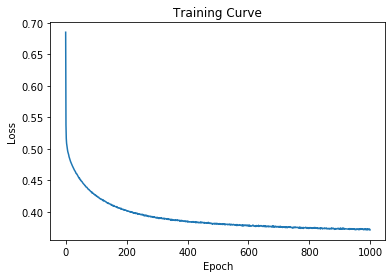

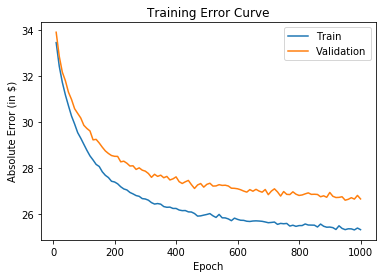

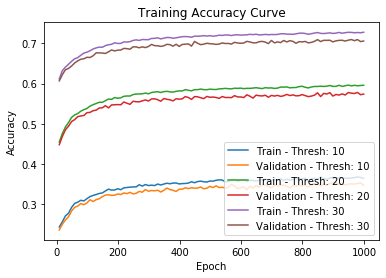

Training Completed...
[FINAL] loss: 0.371226  time: 6712.223


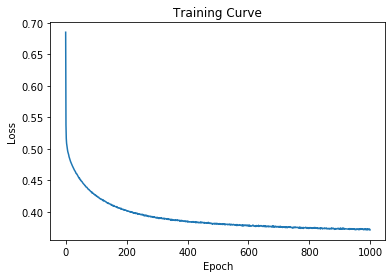

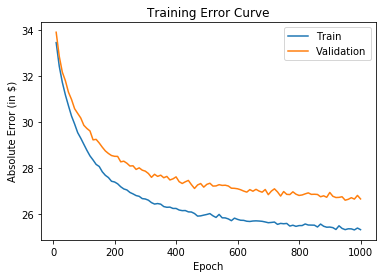

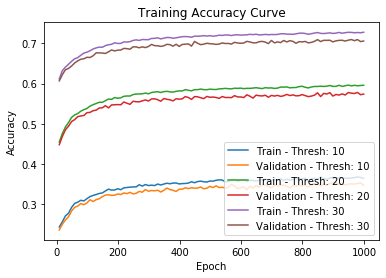

In [11]:
net = airbnb_net()

path = os.getcwd() # get current path
path = path[:-5]+"test/Brian/"
now = datetime.datetime.now()
date = now.strftime("%b").lower()+now.strftime("%d")
i = 1

while True:
    try:
        rootdir = path+"/"+date+"_test"+'{:02d}'.format(i)
        os.mkdir(rootdir)
        break
    except:
        i += 1
        
os.mkdir(rootdir+'/lossplot')
os.mkdir(rootdir+'/checkpoint')
os.mkdir(rootdir+'/accplot')
os.mkdir(rootdir+'/errorplot')
os.mkdir(rootdir+'/final')

torch.manual_seed(1)
train(net, train_loader, val_loader, rootdir, lr = 0.0001, num_epoch = 1000)

In [17]:
checkpoint = torch.load("../test/Brian/nov19_test27/final/checkpoint_final.tar")

In [18]:
print("Minimum Train Error:\t\t", min(checkpoint["train_error"]))
print("Index of Min Train Error:\t", checkpoint["train_error"].index(min(checkpoint["train_error"])))
print("Minimum Val Error:\t\t", min(checkpoint["val_error"]))
print("Index of Min Val Error:\t\t", checkpoint["val_error"].index(min(checkpoint["val_error"])))

Minimum Train Error:		 25.3038503299576
Index of Min Train Error:	 97
Minimum Val Error:		 26.596228349960644
Index of Min Val Error:		 94


In [19]:
print("For Threshold=20")
print("Maximum Train Accuracy:\t", max(checkpoint["train_acc"][1]))
print("Index of Max Train Acc:\t", checkpoint["train_acc"][1].index(max(checkpoint["train_acc"][1])))
print("Maximum Val Accuracy:\t", max(checkpoint["val_acc"][1]))
print("Index of Max Val Acc:\t", checkpoint["val_acc"][1].index(max(checkpoint["val_acc"][1])))

For Threshold=20
Maximum Train Accuracy:	 0.5964029291796865
Index of Max Train Acc:	 94
Maximum Val Accuracy:	 0.5779982826066216
Index of Max Val Acc:	 97
